# Checking waveforms with lalsimulation

For safely using `tiwave`, we need to ensure the implemented waveforms are consistent with `lalsimulation`. We first check waveforms using a test case arbitrarily chosen, by comparing values of ansatz coefficients. and comparing difference of built waveforms visually in plots. In some models, the waveform construction is slightly adjusted for different area of parameter space. To cover all pieces, we compute the mismatch of waveforms at samples drawn randomly in the allowed parameter space of the model.

In [1]:
# TODO: improving the installation
import sys

sys.path.append("/home/hydrogen/workspace/Space_GW/tiwave")

import taichi as ti

ti.init(arch=ti.cpu, default_fp=ti.f64, offline_cache=False, cpu_max_num_threads=1)

[Taichi] version 1.7.2, llvm 15.0.4, commit 0131dce9, linux, python 3.10.12


[I 05/28/25 10:19:20.100 1522939] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=x64


In [2]:
from functools import partial
from multiprocessing import Pool

import lal
import lalsimulation as lalsim
from tiwave.waveforms import IMRPhenomXAS, IMRPhenomXHM
import bilby
import numpy as np
import scipy
from matplotlib import pyplot as plt
import matplotlib

rng = np.random.default_rng(seed=20250305)

%matplotlib inline
fig_width_pt = 3 * 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27  # Convert pt to inch
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_mean  # height in inches
fig_size = [fig_width, fig_height]
plot_params = {
    "axes.labelsize": 24,
    "font.family": "serif",
    "font.serif": "Computer Modern Raman",
    "font.size": 28,
    "legend.fontsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.grid": True,
    "text.usetex": True,
    "savefig.dpi": 500,
    "lines.markersize": 18,
    "figure.figsize": fig_size,
}
matplotlib.rcParams.update(plot_params)

/tmp/ipykernel_1522939/1854735297.py:4: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
reference_frequency = 20.0
minimum_frequency = 20.0
maximum_frequency = 2048.0
sampling_rate = 4096
duration = 32.0

long_asc_nodes = 0.0
eccentricity = 0.0
mean_per_ano = 0.0

num_samples = int(duration * sampling_rate)
full_freqs = np.fft.rfftfreq(num_samples, 1 / sampling_rate)
freqs_mask = (full_freqs <= maximum_frequency) * (full_freqs >= minimum_frequency)
freqs = full_freqs[freqs_mask]
delta_f = freqs[1] - freqs[0]
freqs_ti = ti.field(ti.f64, shape=freqs.shape)
freqs_ti.from_numpy(freqs)


def is_equal(lal_value, tiw_value, name, tolerance_abs=1.0e-8, tolerance_rel=1.0e-10):
    if not lal_value == 0.0:
        err_abs = np.abs(lal_value - tiw_value)
        err_rel = np.abs(lal_value - tiw_value) / np.abs(lal_value)
        ret = (err_abs < tolerance_abs) and (err_rel < tolerance_rel)
    else:  # only comparing absolute error
        err_abs = np.abs(lal_value - tiw_value)
        err_rel = None
        ret = err_abs < tolerance_abs

    print(name)
    print("lalsim: ", lal_value, "tiwave: ", tiw_value)
    print("err abs: ", err_abs, "err rel: ", err_rel)
    print(ret)

    return ret


# psd_array = np.ones(shape=freqs.shape)
PSD_Aplus = bilby.gw.detector.PowerSpectralDensity(asd_file="Aplus_asd.txt")
psd_array = PSD_Aplus.get_power_spectral_density_array(freqs)


def normalising(hf, psd_array, delta_f):
    return hf / np.sqrt(
        bilby.gw.utils.noise_weighted_inner_product(hf, hf, psd_array, 1 / delta_f).real
    )


def mismatch_core(h1_norm, h2_norm, psd_array, delta_f):
    return (
        1.0
        - bilby.gw.utils.noise_weighted_inner_product(
            h1_norm, h2_norm, psd_array, 1 / delta_f
        ).real
    )


def mismatch(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
    luminosity_distance,
    inclination,
    reference_phase,
    tiw_wf_func,
    lal_wf_func,
    psd_array,
    delta_f,
):

    wf_tiw = tiw_wf_func(
        mass_1,
        mass_2,
        chi_1,
        chi_2,
        luminosity_distance,
        inclination,
        reference_phase,
    )
    wf_lal = lal_wf_func(
        mass_1,
        mass_2,
        chi_1,
        chi_2,
        luminosity_distance,
        inclination,
        reference_phase,
    )

    hp_norm_tiw = normalising(wf_tiw["plus"], psd_array, delta_f)
    hc_norm_tiw = normalising(wf_tiw["cross"], psd_array, delta_f)
    hp_norm_lal = normalising(wf_lal["plus"], psd_array, delta_f)
    hc_norm_lal = normalising(wf_lal["cross"], psd_array, delta_f)

    return (
        mismatch_core(hp_norm_tiw, hp_norm_lal, psd_array, delta_f),
        mismatch_core(hc_norm_tiw, hc_norm_lal, psd_array, delta_f),
    )

In [4]:
# fmt: off
def plot_waveform_comparison(waveform_tiw, waveform_lal):
    
    fig, axs = plt.subplots(4, 2, figsize=[fig_width * 2, fig_height * 4])

    axs[0, 0].set_title("Amplitude")
    axs[0, 0].loglog(freqs, np.abs(waveform_tiw["plus"]), label="tiwave")
    axs[0, 0].loglog(freqs, np.abs(waveform_lal["plus"]), linestyle="dashed", label="lalsim")
    axs[0, 0].set_xlim(minimum_frequency, maximum_frequency)
    axs[0, 0].set_xlabel("Frequency (Hz)")
    axs[0, 0].set_ylabel(r"$|h_+|$")
    axs[0, 0].legend()

    axs[0, 1].set_title("Amplitude")
    axs[0, 1].loglog(freqs, np.abs(waveform_tiw["cross"]), label="tiwave")
    axs[0, 1].loglog(freqs, np.abs(waveform_lal["cross"]), linestyle="dashed", label="lalsim")
    axs[0, 1].set_xlim(minimum_frequency, maximum_frequency)
    axs[0, 1].set_xlabel("Frequency (Hz)")
    axs[0, 1].set_ylabel(r"$|h_\times|$")
    axs[0, 1].legend()

    axs[1, 0].set_title("Real part")
    axs[1, 0].semilogx(freqs, waveform_tiw["plus"].real, label="tiwave")
    axs[1, 0].semilogx(freqs, waveform_lal["plus"].real, linestyle="dashed", label="lalsim")
    axs[1, 0].set_xlim(minimum_frequency, maximum_frequency)
    axs[1, 0].set_xlabel("Frequency (Hz)")
    axs[1, 0].set_ylabel(r"$h_+^{\rm Re}$")
    axs[1, 0].legend()

    axs[1, 1].set_title("Real part")
    axs[1, 1].semilogx(freqs, waveform_tiw["cross"].real, label="tiwave")
    axs[1, 1].semilogx(freqs, waveform_lal["cross"].real, linestyle="dashed", label="lalsim")
    axs[1, 1].set_xlim(minimum_frequency, maximum_frequency)
    axs[1, 1].set_xlabel("Frequency (Hz)")
    axs[1, 1].set_ylabel(r"$h_\times^{\rm Re}$")
    axs[1, 1].legend()

    axs[2, 0].set_title("Imaginary part")
    axs[2, 0].semilogx(freqs, waveform_tiw["plus"].imag, label="tiwave")
    axs[2, 0].semilogx(freqs, waveform_lal["plus"].imag, linestyle="dashed", label="lalsim")
    axs[2, 0].set_xlim(minimum_frequency, maximum_frequency)
    axs[2, 0].set_xlabel("Frequency (Hz)")
    axs[2, 0].set_ylabel(r"$h_+^{\rm Im}$")
    axs[2, 0].legend()

    axs[2, 1].set_title("Imaginary part")
    axs[2, 1].semilogx(freqs, waveform_tiw["cross"].imag, label="tiwave")
    axs[2, 1].semilogx(freqs, waveform_lal["cross"].imag, linestyle="dashed", label="lalsim")
    axs[2, 1].set_xlim(minimum_frequency, maximum_frequency)
    axs[2, 1].set_xlabel("Frequency (Hz)")
    axs[2, 1].set_ylabel(r"$h_\times^{\rm Im}$")
    axs[2, 1].legend()

    axs[3, 0].set_title("Difference")
    axs[3, 0].loglog(freqs, np.abs(waveform_tiw["plus"] - waveform_lal["plus"])/np.abs(waveform_lal["plus"]))
    axs[3, 0].set_xlim(minimum_frequency, maximum_frequency)
    axs[3, 0].set_xlabel("Frequency (Hz)")
    axs[3, 0].set_ylabel(r"$|h_+^{\rm tiw} - h_+^{\rm lal}|/|h_+^{\rm lal}|$")

    axs[3, 1].set_title("Difference")
    axs[3, 1].loglog(freqs, np.abs(waveform_tiw["cross"] - waveform_lal["cross"])/np.abs(waveform_lal["cross"]))
    axs[3, 1].set_xlim(minimum_frequency, maximum_frequency)
    axs[3, 1].set_xlabel("Frequency (Hz)")
    axs[3, 1].set_ylabel(r"$|h_\times^{\rm tiw} - h_\times^{\rm lal}|/|h_\times^{\rm lal}|$")

    return fig
# fmt: on

In [5]:
# an arbitrarily chosen test case
parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    chi_1=-0.4,
    chi_2=0.02,
    luminosity_distance=800.0,
    inclination=0.4,
    reference_phase=1.2,
)

In [6]:
num = 10000

# samples for PhenomX family
samples_x = {}
samples_x["total_mass"] = rng.uniform(20, 250, num)
# XAS model is calibrated to mass ratio from 1 to 1000, using log-uniform to cover more case with extreme mass ratio
samples_x["mass_ratio"] = 10 ** rng.uniform(-3, 0, num)
samples_x["chi_1"] = rng.uniform(-0.99, 0.99, num)
samples_x["chi_2"] = rng.uniform(-0.99, 0.99, num)
samples_x["luminosity_distance"] = parameters["luminosity_distance"] * np.ones(num)
# samples_x['luminosity_distance'] = rng.uniform(20, 1000, num) * np.ones(num)
samples_x["cos_iota"] = rng.uniform(-1, 1, num)
samples_x["inclination"] = np.arccos(samples_x["cos_iota"])
samples_x["reference_phase"] = rng.uniform(0, 2 * np.pi, num)
samples_x = bilby.gw.conversion.generate_component_masses(samples_x)

## IMRPhenomD

## IMRPhenomXAS

In [7]:
xas_tiw = IMRPhenomXAS(freqs_ti, reference_frequency)
xas_tiw.update_waveform(parameters)

/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/base_waveform.py:45: UserWarning: check_parameters is disable, make sure all parameters passed in are valid.
  warnings.warn(


### 1. Comparing values of coefficients in the waveform ansatz (TL; DR)

In [8]:
# values of ansatz coefficients given by lalsimlation
# setting CFLAGS='-g -D PHENOMXHMDEBUG' to obtain the debug information

# using default configuration
# Inspiral Amp Version      : 103
# Intermediate Amp Version  : 104
# Ringdown Amp Version      : 103

# Inspiral Phase Version        : 104
# Intermediate Phase Version    : 105
# Ringdown Phase Version        : 105

# phase coefficients
lalsim_XAS_coeffs_phase = dict(
    # inspiral
    pn_phi0=1.0000000000000000e00,
    pn_phi1=0.0000000000000000e00,
    pn_phi2=1.3779841169305184e01,
    pn_phi3=-1.7933661579771422e02,
    pn_phi4=2.0122909161443940e02,
    pn_phi5=0.0000000000000000e00,
    pn_phi6=-1.6199727883136980e04,
    pn_phi7=3.0704777032881244e04,
    pn_phi8=2.0488988904432222e03,
    pn_phi5l=1.4103375172207761e03,
    pn_phi6l=-1.0728103323596813e03,
    pn_phi8l=1.4156709088924592e04,
    ins_a0=-1.2559580256860478e04,
    ins_a1=3.1430403649084282e05,
    ins_a2=-4.8479183822615136e05,
    ins_a3=-1.0353446809946555e06,
    # intermediate
    int_b0=-3.3240287669887664e01,
    int_b1=-5.6647349547531487e00,
    int_b2=2.9996549097364633e-01,
    int_b3=-5.1558188989106850e-03,
    int_b4=4.0595492463932989e-05,
    # merge-ringdown
    MRD_c0=-4.1355092775620896e01,
    MRD_c1=-2.5867019814145003e01,
    MRD_c2=1.3880539241153048e-01,
    MRD_c4=-6.8605062875088936e-05,
    MRD_cL=-3.6257425875162686e-03,
    # connection conditions
    C0_int=1.7918077676584005e01,
    C1_int=4.2632564145606011e-14,
    C0_MRD=3.8197416973029668e01,
    C1_MRD=4.6685996352340453e-01,
    # time and phase shift
    linb=2.9910171154608679e02,
    phifRef=-8.5126647519295858e01,
    # joint frequency
    fPhaseMatchIN=1.8103333600837271e-02,
    fPhaseMatchIM=4.8757024630749296e-02,
)
# amplitude coefficients
lalsim_XAS_coeffs_amp = dict(
    # inspiral
    A2=-1.6701560621633178e00,
    A3=-1.9839269143253400e00,
    A4=-2.1413435529985417e01,
    A5=-1.8346767804579585e01,
    A6=-4.1562282579462995e01,
    ins_alpha1=2.4373597823426589e00,
    ins_alpha2=-1.2885037133169333e04,
    ins_alpha3=5.1995528782820737e04,
    # intermediate
    int_delta0=2.6824399290321672e-03,
    int_delta1=1.6474779937163808e-01,
    int_delta2=3.6480625205557487e01,
    int_delta3=-8.0466024177036797e02,
    int_delta4=5.1991385440590884e03,
    # merge-ringdown
    MRD_gamma1=1.6254892668290152e-02,
    MRD_gamma2=8.2259850887065455e-01,
    MRD_gamma3=1.3076726769239482e00,
    # joint frequency
    fAmpIN=2.4097267483853609e-02,
    fAmpIM=7.2641868507279592e-02,
)

In [9]:
# fmt: off
# PN coefficients
pn_phi_tiw_to_lal = 1/(-3/(128 * np.pi**(5/3) * xas_tiw.source_parameters[None].eta))
is_equal(lalsim_XAS_coeffs_phase["pn_phi0"], xas_tiw.pn_coefficients[None].phi_0*pn_phi_tiw_to_lal, "pn phi0")
is_equal(lalsim_XAS_coeffs_phase["pn_phi1"], xas_tiw.pn_coefficients[None].phi_1*pn_phi_tiw_to_lal, "pn phi1")
is_equal(lalsim_XAS_coeffs_phase["pn_phi2"], xas_tiw.pn_coefficients[None].phi_2*pn_phi_tiw_to_lal, "pn phi2")
is_equal(lalsim_XAS_coeffs_phase["pn_phi3"], xas_tiw.pn_coefficients[None].phi_3*pn_phi_tiw_to_lal, "pn phi3")
is_equal(lalsim_XAS_coeffs_phase["pn_phi4"], xas_tiw.pn_coefficients[None].phi_4*pn_phi_tiw_to_lal, "pn phi4")
is_equal(lalsim_XAS_coeffs_phase["pn_phi6"], (xas_tiw.pn_coefficients[None].phi_6 + xas_tiw.pn_coefficients[None].phi_6l*np.log(np.pi))*pn_phi_tiw_to_lal, "pn phi6")
is_equal(lalsim_XAS_coeffs_phase["pn_phi7"], xas_tiw.pn_coefficients[None].phi_7*pn_phi_tiw_to_lal, "pn phi7")
is_equal(lalsim_XAS_coeffs_phase["pn_phi8"], (xas_tiw.pn_coefficients[None].phi_8 + xas_tiw.pn_coefficients[None].phi_8l*np.log(np.pi))*pn_phi_tiw_to_lal, "pn phi8")
is_equal(lalsim_XAS_coeffs_phase["pn_phi5l"], xas_tiw.pn_coefficients[None].phi_5l*pn_phi_tiw_to_lal, "pn phi5l")
is_equal(lalsim_XAS_coeffs_phase["pn_phi6l"], xas_tiw.pn_coefficients[None].phi_6l*pn_phi_tiw_to_lal, "pn phi6l")
is_equal(lalsim_XAS_coeffs_phase["pn_phi8l"], xas_tiw.pn_coefficients[None].phi_8l*pn_phi_tiw_to_lal, "pn phi8l")
is_equal(1.0, xas_tiw.pn_coefficients[None].A_0, "pn A_0")
is_equal(0.0, xas_tiw.pn_coefficients[None].A_1, "pn A_1")
is_equal(lalsim_XAS_coeffs_amp["A2"], xas_tiw.pn_coefficients[None].A_2, "pn A_2")
is_equal(lalsim_XAS_coeffs_amp["A3"], xas_tiw.pn_coefficients[None].A_3, "pn A_3")
is_equal(lalsim_XAS_coeffs_amp["A4"], xas_tiw.pn_coefficients[None].A_4, "pn A_4")
is_equal(lalsim_XAS_coeffs_amp["A5"], xas_tiw.pn_coefficients[None].A_5, "pn A_5")
is_equal(lalsim_XAS_coeffs_amp["A6"], xas_tiw.pn_coefficients[None].A_6, "pn A_6")

# Phase coefficients
sigma_to_a = 1/(5/(128*np.pi**(5/3)*xas_tiw.source_parameters[None].eta))
is_equal(lalsim_XAS_coeffs_phase["ins_a0"], xas_tiw.phase_coefficients[None].sigma_1*sigma_to_a, "phase ins_a0")
is_equal(lalsim_XAS_coeffs_phase["ins_a1"], xas_tiw.phase_coefficients[None].sigma_2*sigma_to_a, "phase ins_a1")
is_equal(lalsim_XAS_coeffs_phase["ins_a2"], xas_tiw.phase_coefficients[None].sigma_3*sigma_to_a, "phase ins_a2")
is_equal(lalsim_XAS_coeffs_phase["ins_a3"], xas_tiw.phase_coefficients[None].sigma_4*sigma_to_a, "phase ins_a3")

beta_to_b = xas_tiw.source_parameters[None].eta
is_equal(lalsim_XAS_coeffs_phase["int_b0"], xas_tiw.phase_coefficients[None].beta_0*beta_to_b, "phase int_b0")
is_equal(lalsim_XAS_coeffs_phase["int_b1"], xas_tiw.phase_coefficients[None].beta_1*beta_to_b, "phase int_b1")
is_equal(lalsim_XAS_coeffs_phase["int_b2"], xas_tiw.phase_coefficients[None].beta_2*beta_to_b, "phase int_b2")
is_equal(lalsim_XAS_coeffs_phase["int_b3"], xas_tiw.phase_coefficients[None].beta_3*beta_to_b, "phase int_b3")
is_equal(lalsim_XAS_coeffs_phase["int_b4"], xas_tiw.phase_coefficients[None].beta_4*beta_to_b, "phase int_b4")

c_tiw_to_lal = xas_tiw.source_parameters[None].eta
is_equal(lalsim_XAS_coeffs_phase["MRD_c0"], xas_tiw.phase_coefficients[None].c_0*c_tiw_to_lal, "phase MRD_c0")
is_equal(lalsim_XAS_coeffs_phase["MRD_c1"], xas_tiw.phase_coefficients[None].c_1*c_tiw_to_lal, "phase MRD_c1")
is_equal(lalsim_XAS_coeffs_phase["MRD_c2"], xas_tiw.phase_coefficients[None].c_2*c_tiw_to_lal, "phase MRD_c2")
is_equal(lalsim_XAS_coeffs_phase["MRD_c4"], xas_tiw.phase_coefficients[None].c_4*c_tiw_to_lal, "phase MRD_c4")
is_equal(lalsim_XAS_coeffs_phase["MRD_cL"], xas_tiw.phase_coefficients[None].c_L*c_tiw_to_lal, "phase MRD_cL")

conn_tiw_to_lal = xas_tiw.source_parameters[None].eta
is_equal(lalsim_XAS_coeffs_phase["C0_int"], xas_tiw.phase_coefficients[None].C0_int*conn_tiw_to_lal, "phase C0_int")
is_equal(0.0, xas_tiw.phase_coefficients[None].C1_int*conn_tiw_to_lal, "phase C1_int")
is_equal(lalsim_XAS_coeffs_phase["C0_MRD"], xas_tiw.phase_coefficients[None].C0_MRD*conn_tiw_to_lal, "phase C0_MRD")
is_equal(lalsim_XAS_coeffs_phase["C1_MRD"], xas_tiw.phase_coefficients[None].C1_MRD*conn_tiw_to_lal, "phase C1_MRD")

is_equal(lalsim_XAS_coeffs_phase["linb"], xas_tiw.phase_coefficients[None].time_shift, "time shift")
is_equal(lalsim_XAS_coeffs_phase["phifRef"], xas_tiw.phase_coefficients[None].phase_shift, "phase shift")

is_equal(lalsim_XAS_coeffs_phase["fPhaseMatchIN"], xas_tiw.phase_coefficients[None].fjoin_int_ins, "phase fjoin int ins")
is_equal(lalsim_XAS_coeffs_phase["fPhaseMatchIM"], xas_tiw.phase_coefficients[None].fjoin_MRD_int, "phase fjoin MRD int")

# Amplitude coefficients
is_equal(lalsim_XAS_coeffs_amp["ins_alpha1"], xas_tiw.amplitude_coefficients[None].rho_1, "amp psuedo PN 1")
is_equal(lalsim_XAS_coeffs_amp["ins_alpha2"], xas_tiw.amplitude_coefficients[None].rho_2, "amp psuedo PN 2")
is_equal(lalsim_XAS_coeffs_amp["ins_alpha3"], xas_tiw.amplitude_coefficients[None].rho_3, "amp psuedo PN 3")

is_equal(lalsim_XAS_coeffs_amp["int_delta0"], xas_tiw.amplitude_coefficients[None].alpha_0, "amp int 0")
is_equal(lalsim_XAS_coeffs_amp["int_delta1"], xas_tiw.amplitude_coefficients[None].alpha_1, "amp int 1")
is_equal(lalsim_XAS_coeffs_amp["int_delta2"], xas_tiw.amplitude_coefficients[None].alpha_2, "amp int 2")
is_equal(lalsim_XAS_coeffs_amp["int_delta3"], xas_tiw.amplitude_coefficients[None].alpha_3, "amp int 3")
is_equal(lalsim_XAS_coeffs_amp["int_delta4"], xas_tiw.amplitude_coefficients[None].alpha_4, "amp int 4")

is_equal(lalsim_XAS_coeffs_amp["MRD_gamma1"], xas_tiw.amplitude_coefficients[None].gamma_1, "amp MRD gamma1")
is_equal(lalsim_XAS_coeffs_amp["MRD_gamma2"], xas_tiw.amplitude_coefficients[None].gamma_2, "amp MRD gamma2")
is_equal(lalsim_XAS_coeffs_amp["MRD_gamma3"], xas_tiw.amplitude_coefficients[None].gamma_3, "amp MRD gamma3")

is_equal(lalsim_XAS_coeffs_amp["fAmpIN"], xas_tiw.amplitude_coefficients[None].fjoin_int_ins, "amp fjoin_int_ins")
is_equal(lalsim_XAS_coeffs_amp["fAmpIM"], xas_tiw.amplitude_coefficients[None].fjoin_MRD_int, "amp fjoin_MRD_int")
# fmt: on

pn phi0
lalsim:  1.0 tiwave:  1.0000000000000002
err abs:  2.220446049250313e-16 err rel:  2.220446049250313e-16
True
pn phi1
lalsim:  0.0 tiwave:  -0.0
err abs:  0.0 err rel:  None
True
pn phi2
lalsim:  13.779841169305184 tiwave:  13.779841169305184
err abs:  0.0 err rel:  0.0
True
pn phi3
lalsim:  -179.33661579771422 tiwave:  -179.33661579771427
err abs:  5.684341886080802e-14 err rel:  3.1696493550946405e-16
True
pn phi4
lalsim:  201.2290916144394 tiwave:  201.2290916144393
err abs:  8.526512829121202e-14 err rel:  4.237216776517702e-16
True
pn phi6
lalsim:  -16199.72788313698 tiwave:  -16199.727883136979
err abs:  1.8189894035458565e-12 err rel:  1.1228518260725378e-16
True
pn phi7
lalsim:  30704.777032881244 tiwave:  30704.77703288123
err abs:  1.4551915228366852e-11 err rel:  4.739300081151361e-16
True
pn phi8
lalsim:  2048.898890443222 tiwave:  2048.89889044322
err abs:  2.2737367544323206e-12 err rel:  1.1097359489225263e-15
True
pn phi5l
lalsim:  1410.3375172207761 tiwave:  14

True

### 2. Comparing the waveform visually

/tmp/ipykernel_1425051/427251378.py:55: RuntimeWarning: invalid value encountered in divide
  axs[3, 0].loglog(freqs, np.abs(waveform_tiw["plus"] - waveform_lal["plus"])/np.abs(waveform_lal["plus"]))
/tmp/ipykernel_1425051/427251378.py:61: RuntimeWarning: invalid value encountered in divide
  axs[3, 1].loglog(freqs, np.abs(waveform_tiw["cross"] - waveform_lal["cross"])/np.abs(waveform_lal["cross"]))


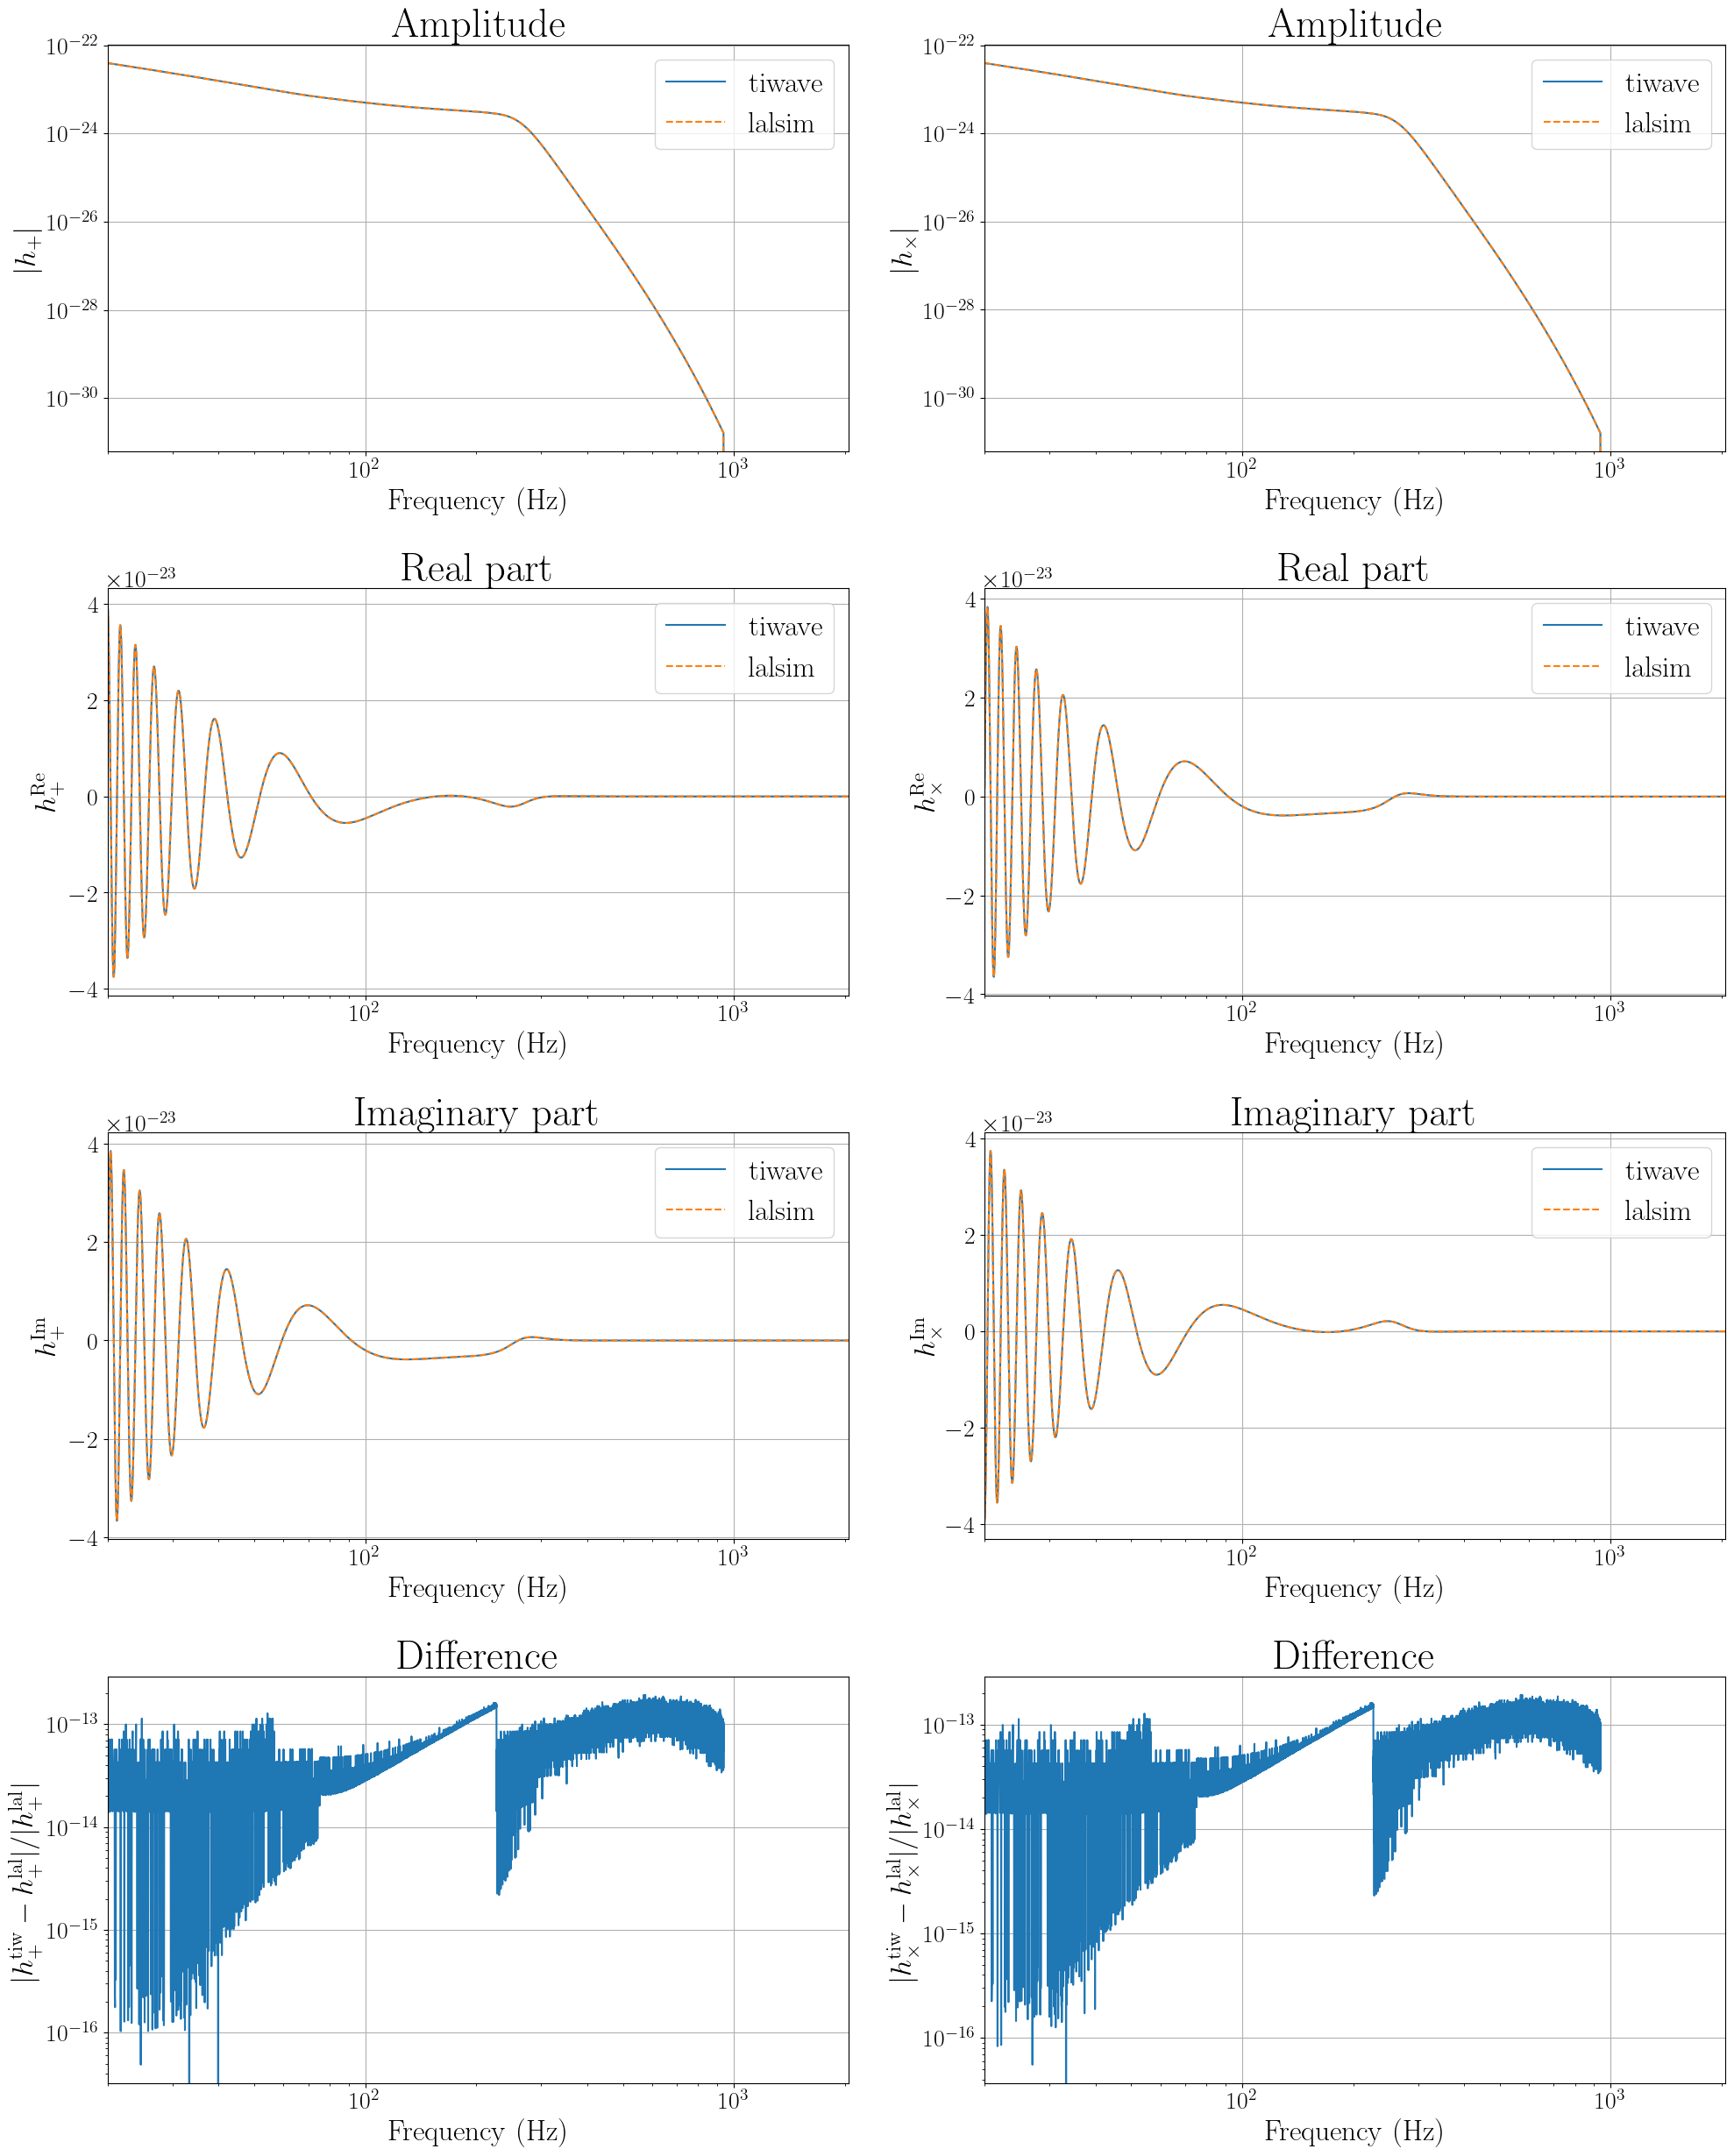

In [10]:
appro_xas = lalsim.GetApproximantFromString("IMRPhenomXAS")
extra_params = lal.CreateDict()

hp_lal, hc_lal = lalsim.SimInspiralChooseFDWaveform(
    float(parameters["mass_1"] * lal.MSUN_SI),
    float(parameters["mass_2"] * lal.MSUN_SI),
    float(0.0),
    float(0.0),
    float(parameters["chi_1"]),
    float(0.0),
    float(0.0),
    float(parameters["chi_2"]),
    float(parameters["luminosity_distance"] * 1e6 * lal.PC_SI),
    float(parameters["inclination"]),
    float(parameters["reference_phase"]),
    float(long_asc_nodes),
    float(eccentricity),
    float(mean_per_ano),
    float(delta_f),
    float(freqs[0]),
    float(freqs[-1]),
    float(reference_frequency),
    extra_params,
    appro_xas,
)

fig = plot_waveform_comparison(
    xas_tiw.waveform_container_numpy,
    {"plus": hp_lal.data.data[freqs_mask], "cross": hc_lal.data.data[freqs_mask]},
)
fig.tight_layout()

### 3. Mismatch in the whole parameter space

In [11]:
def xas_tiw_wrapper(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
    luminosity_distance,
    inclination,
    reference_phase,
):
    params_in = {
        "mass_1": mass_1,
        "mass_2": mass_2,
        "chi_1": chi_1,
        "chi_2": chi_2,
        "luminosity_distance": luminosity_distance,
        "inclination": inclination,
        "reference_phase": reference_phase,
    }
    xas_tiw.update_waveform(params_in)
    return xas_tiw.waveform_container_numpy


def xas_lal_wrapper(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
    luminosity_distance,
    inclination,
    reference_phase,
):
    hp, hc = lalsim.SimInspiralChooseFDWaveform(
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(luminosity_distance * 1e6 * lal.PC_SI),
        float(inclination),
        float(reference_phase),
        float(long_asc_nodes),
        float(eccentricity),
        float(mean_per_ano),
        float(delta_f),
        float(freqs[0]),
        float(freqs[-1]),
        float(reference_frequency),
        extra_params,
        appro_xas,
    )
    return {"plus": hp.data.data[freqs_mask], "cross": hc.data.data[freqs_mask]}


mismatch_xas = partial(
    mismatch,
    tiw_wf_func=xas_tiw_wrapper,
    lal_wf_func=xas_lal_wrapper,
    psd_array=psd_array,
    delta_f=delta_f,
)

In [12]:
print("Mismatch of the test case: ", mismatch_xas(**parameters))

Mismatch of the test case:  (-2.220446049250313e-16, 0.0)


In [13]:
mism = list(
    map(
        mismatch_xas,
        samples_x["mass_1"],
        samples_x["mass_2"],
        samples_x["chi_1"],
        samples_x["chi_2"],
        samples_x["luminosity_distance"],
        samples_x["inclination"],
        samples_x["reference_phase"],
    )
)
mism = np.array(mism)

The maximum mismatch in samples is:  6.661338147750939e-16
The minimum mismatch in samples is:  -6.661338147750939e-16


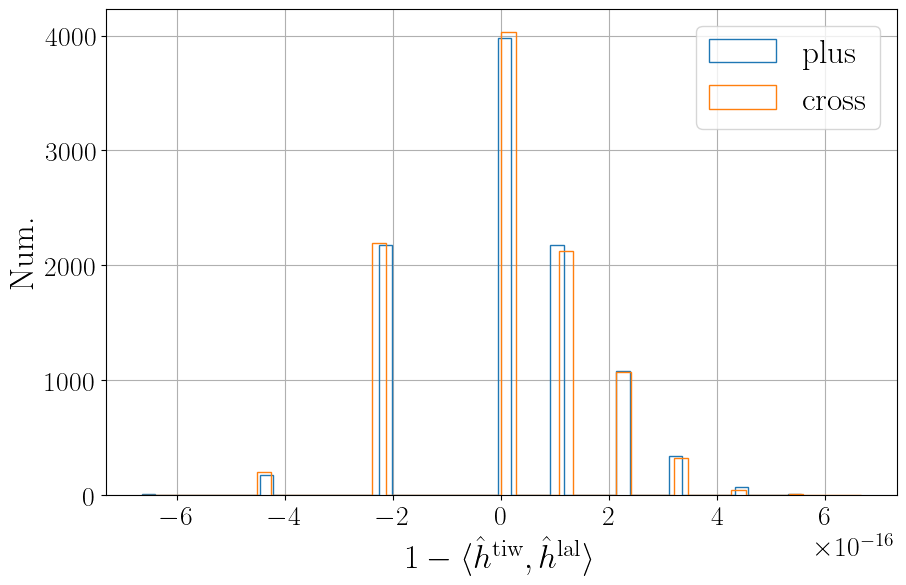

In [14]:
print("The maximum mismatch in samples is: ", mism.max())
print("The minimum mismatch in samples is: ", mism.min())

fig, ax = plt.subplots()
ax.hist(
    mism[:, 0],
    bins=50,
    histtype="step",
    label="plus",
)
ax.hist(
    mism[:, 1],
    bins=50,
    histtype="step",
    label="cross",
)
ax.set_xlabel(r"$1-\langle \hat{h}^{\rm tiw} , \hat{h}^{\rm lal}\rangle$")
ax.set_ylabel("Num.")
ax.legend()
fig.show()
# note minus values are induced by numerical errors in the computation of the inner product

## IMRPhenomXHM

In [15]:
xhm_tiw = IMRPhenomXHM(freqs_ti, reference_frequency, combine_modes=True)
xhm_tiw.update_waveform(parameters)

/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/base_waveform.py:45: UserWarning: check_parameters is disable, make sure all parameters passed in are valid.
  warnings.warn(
/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/IMRPhenomXHM.py:7036: UserWarning: Mode 32 has relatively large numerical errors with lalsim, please make sure these errors are acceptable in your cases before using.
  warnings.warn(
/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/IMRPhenomXHM.py:7041: UserWarning: `tf` is required for mode 32, since the derivative of phase for merge-ringdown of mode 32 is obtained through numerical difference, if may not reliable for some cases.
  warnings.warn(


### 1. Comparing values of coefficients in the waveform ansatz (TL; DR)

In [16]:
# values of ansatz coefficients given by lalsimlation
# setting CFLAGS='-g -D PHENOMXHMDEBUG' to obtain the debug information

# In release 122022:

# InspiralAmpFreqsVersion     = 122022
# IntermediateAmpFreqsVersion = 0
# RingdownAmpFreqsVersion     = 122022

# InspiralAmpFitsVersion      = 122022
# IntermediateAmpFitsVersion  = 122022
# RingdownAmpFitsVersion      = 122022

# InspiralAmpVersion          = 123
# IntermediateAmpVersion      = 211112 (110102 for mode 21)
# RingdownAmpVersion          = 2 (1 for mode 32)

# InspiralPhaseVersion = 122019
# IntermediatePhaseVersion = 122019
# RingdownPhaseVersion = 122019

In [17]:
# def read_ansatz_coefficients(fname):
#     data = {}
#     with open(fname, "r", encoding="utf-8") as f:
#         for line in f:
#             line = line.strip()
#             if not line or "=" not in line:
#                 continue
#             key, value = map(str.strip, line.split("=", 1))
#             data[key] = float(value)
#     return data


# coeffs_lal_21 = read_ansatz_coefficients(
#     "/home/hydrogen/workspace/Space_GW/tiwave/Parameters21.dat"
# )
# coeffs_lal_33 = read_ansatz_coefficients(
#     "/home/hydrogen/workspace/Space_GW/tiwave/Parameters33.dat"
# )
# coeffs_lal_32 = read_ansatz_coefficients(
#     "/home/hydrogen/workspace/Space_GW/tiwave/Parameters32.dat"
# )
# coeffs_lal_44 = read_ansatz_coefficients(
#     "/home/hydrogen/workspace/Space_GW/tiwave/Parameters44.dat"
# )

# ########################################################################################
# lalsim_XHM_coeffs_phase_21 = dict(
#     fPhaseMatchIN=coeffs_lal_21["pPhase->fPhaseMatchIN"],
#     fPhaseMatchIM=coeffs_lal_21["pPhase->fPhaseMatchIM"],
#     # inspiral
#     phi_0=coeffs_lal_21["pPhase->phi[0]"],
#     phi_1=coeffs_lal_21["pPhase->phi[1]"],
#     phi_2=coeffs_lal_21["pPhase->phi[2]"],
#     phi_3=coeffs_lal_21["pPhase->phi[3]"],
#     phi_4=coeffs_lal_21["pPhase->phi[4]"],
#     phi_5=coeffs_lal_21["pPhase->phi[5]"],
#     phi_6=coeffs_lal_21["pPhase->phi[6]"],
#     phi_7=coeffs_lal_21["pPhase->phi[7]"],
#     phi_8=coeffs_lal_21["pPhase->phi[8]"],
#     phi_9=coeffs_lal_21["pPhase->phi[9]"],
#     phi_10=coeffs_lal_21["pPhase->phi[10]"],
#     phi_11=coeffs_lal_21["pPhase->phi[11]"],
#     phi_5l=coeffs_lal_21["pPhase->phiL[5]"],
#     phi_6l=coeffs_lal_21["pPhase->phiL[6]"],
#     phi_8l=coeffs_lal_21["pPhase->phiL[8]"],
#     # intermediate
#     c0=coeffs_lal_21["pPhase->c0"],
#     cL=coeffs_lal_21["pPhase->cL"],
#     c1=coeffs_lal_21["pPhase->c1"],
#     c2=coeffs_lal_21["pPhase->c2"],
#     c4=coeffs_lal_21["pPhase->c4"],
#     # merge-ringdown
#     alpha2=coeffs_lal_21["pPhase->alpha2"],
#     alphaL=coeffs_lal_21["pPhase->alphaL"],
#     # connection conditions
#     CINSP_plus_phi5=coeffs_lal_21["pPhase->CINSP + pPhase->phi[5]"],
#     C1INSP=coeffs_lal_21["pPhase->C1INSP"],
#     CRD=coeffs_lal_21["pPhase->CRD"],
#     C1RD=coeffs_lal_21["pPhase->C1RD"],
#     # delta_phi
#     deltaphiLM=coeffs_lal_21["pPhase->deltaphiLM"],
# )

# lalsim_XHM_coeffs_amp_21 = dict(
#     fAmpMatchIN=coeffs_lal_21["pAmp->fAmpMatchIN"],
#     fAmpMatchIM=coeffs_lal_21["pAmp->fAmpMatchIM"],
#     fAmpRDfalloff=coeffs_lal_21["pWFHM->fAmpRDfalloff"],
#     # inspiral
#     PNdominant=coeffs_lal_21["pAmp->PNdominant"],
#     A_0_re=coeffs_lal_21["pAmp->pnInitial_re"],
#     A_0_im=coeffs_lal_21["pAmp->pnInitial_im"],
#     A_1_re=coeffs_lal_21["pAmp->pnOneThird_re"],
#     A_1_im=coeffs_lal_21["pAmp->pnOneThird_im"],
#     A_2_re=coeffs_lal_21["pAmp->pnTwoThirds_re"],
#     A_2_im=coeffs_lal_21["pAmp->pnTwoThirds_im"],
#     A_3_re=coeffs_lal_21["pAmp->pnThreeThirds_re"],
#     A_3_im=coeffs_lal_21["pAmp->pnThreeThirds_im"],
#     A_4_re=coeffs_lal_21["pAmp->pnFourThirds_re"],
#     A_4_im=coeffs_lal_21["pAmp->pnFourThirds_im"],
#     A_5_re=coeffs_lal_21["pAmp->pnFiveThirds_re"],
#     A_5_im=coeffs_lal_21["pAmp->pnFiveThirds_im"],
#     A_6_re=coeffs_lal_21["pAmp->pnSixThirds_re"],
#     A_6_im=coeffs_lal_21["pAmp->pnSixThirds_im"],
#     rho1=coeffs_lal_21["pAmp->InspiralCoefficient[0]"],
#     rho2=coeffs_lal_21["pAmp->InspiralCoefficient[1]"],
#     rho3=coeffs_lal_21["pAmp->InspiralCoefficient[2]"],
#     # intermediate
#     InterCoefficient_0=coeffs_lal_21["pAmp->InterCoefficient[0]"],
#     InterCoefficient_1=coeffs_lal_21["pAmp->InterCoefficient[1]"],
#     InterCoefficient_2=coeffs_lal_21["pAmp->InterCoefficient[2]"],
#     InterCoefficient_3=coeffs_lal_21["pAmp->InterCoefficient[3]"],
#     InterCoefficient_4=coeffs_lal_21["pAmp->InterCoefficient[4]"],
#     # merge-ringdown
#     RD_coeffs_0=coeffs_lal_21["pAmp->RDCoefficient[0]"],
#     RD_coeffs_1=coeffs_lal_21["pAmp->RDCoefficient[1]"],
#     RD_coeffs_2=coeffs_lal_21["pAmp->RDCoefficient[2]"],
#     RD_coeffs_3=coeffs_lal_21["pAmp->RDCoefficient[3]"],
#     RD_coeffs_4=coeffs_lal_21["pAmp->RDCoefficient[4]"],
# )

# ########################################################################################
# lalsim_XHM_coeffs_phase_33 = dict(
#     fPhaseMatchIN=coeffs_lal_33["pPhase->fPhaseMatchIN"],
#     fPhaseMatchIM=coeffs_lal_33["pPhase->fPhaseMatchIM"],
#     # inspiral
#     phi_0=coeffs_lal_33["pPhase->phi[0]"],
#     phi_1=coeffs_lal_33["pPhase->phi[1]"],
#     phi_2=coeffs_lal_33["pPhase->phi[2]"],
#     phi_3=coeffs_lal_33["pPhase->phi[3]"],
#     phi_4=coeffs_lal_33["pPhase->phi[4]"],
#     phi_5=coeffs_lal_33["pPhase->phi[5]"],
#     phi_6=coeffs_lal_33["pPhase->phi[6]"],
#     phi_7=coeffs_lal_33["pPhase->phi[7]"],
#     phi_8=coeffs_lal_33["pPhase->phi[8]"],
#     phi_9=coeffs_lal_33["pPhase->phi[9]"],
#     phi_10=coeffs_lal_33["pPhase->phi[10]"],
#     phi_11=coeffs_lal_33["pPhase->phi[11]"],
#     phi_5l=coeffs_lal_33["pPhase->phiL[5]"],
#     phi_6l=coeffs_lal_33["pPhase->phiL[6]"],
#     phi_8l=coeffs_lal_33["pPhase->phiL[8]"],
#     # intermediate
#     c0=coeffs_lal_33["pPhase->c0"],
#     cL=coeffs_lal_33["pPhase->cL"],
#     c1=coeffs_lal_33["pPhase->c1"],
#     c2=coeffs_lal_33["pPhase->c2"],
#     c4=coeffs_lal_33["pPhase->c4"],
#     # merge-ringdown
#     alpha2=coeffs_lal_33["pPhase->alpha2"],
#     alphaL=coeffs_lal_33["pPhase->alphaL"],
#     # connection conditions
#     CINSP_plus_phi5=coeffs_lal_33["pPhase->CINSP + pPhase->phi[5]"],
#     C1INSP=coeffs_lal_33["pPhase->C1INSP"],
#     CRD=coeffs_lal_33["pPhase->CRD"],
#     C1RD=coeffs_lal_33["pPhase->C1RD"],
#     # delta_phi
#     deltaphiLM=coeffs_lal_33["pPhase->deltaphiLM"],
# )

# lalsim_XHM_coeffs_amp_33 = dict(
#     fAmpMatchIN=coeffs_lal_33["pAmp->fAmpMatchIN"],
#     fAmpMatchIM=coeffs_lal_33["pAmp->fAmpMatchIM"],
#     fAmpRDfalloff=coeffs_lal_33["pWFHM->fAmpRDfalloff"],
#     # inspiral
#     PNdominant=coeffs_lal_33["pAmp->PNdominant"],
#     A_0_re=coeffs_lal_33["pAmp->pnInitial_re"],
#     A_0_im=coeffs_lal_33["pAmp->pnInitial_im"],
#     A_1_re=coeffs_lal_33["pAmp->pnOneThird_re"],
#     A_1_im=coeffs_lal_33["pAmp->pnOneThird_im"],
#     A_2_re=coeffs_lal_33["pAmp->pnTwoThirds_re"],
#     A_2_im=coeffs_lal_33["pAmp->pnTwoThirds_im"],
#     A_3_re=coeffs_lal_33["pAmp->pnThreeThirds_re"],
#     A_3_im=coeffs_lal_33["pAmp->pnThreeThirds_im"],
#     A_4_re=coeffs_lal_33["pAmp->pnFourThirds_re"],
#     A_4_im=coeffs_lal_33["pAmp->pnFourThirds_im"],
#     A_5_re=coeffs_lal_33["pAmp->pnFiveThirds_re"],
#     A_5_im=coeffs_lal_33["pAmp->pnFiveThirds_im"],
#     A_6_re=coeffs_lal_33["pAmp->pnSixThirds_re"],
#     A_6_im=coeffs_lal_33["pAmp->pnSixThirds_im"],
#     rho1=coeffs_lal_33["pAmp->InspiralCoefficient[0]"],
#     rho2=coeffs_lal_33["pAmp->InspiralCoefficient[1]"],
#     rho3=coeffs_lal_33["pAmp->InspiralCoefficient[2]"],
#     # intermediate
#     InterCoefficient_0=coeffs_lal_33["pAmp->InterCoefficient[0]"],
#     InterCoefficient_1=coeffs_lal_33["pAmp->InterCoefficient[1]"],
#     InterCoefficient_2=coeffs_lal_33["pAmp->InterCoefficient[2]"],
#     InterCoefficient_3=coeffs_lal_33["pAmp->InterCoefficient[3]"],
#     InterCoefficient_4=coeffs_lal_33["pAmp->InterCoefficient[4]"],
#     # merge-ringdown
#     RD_coeffs_0=coeffs_lal_33["pAmp->RDCoefficient[0]"],
#     RD_coeffs_1=coeffs_lal_33["pAmp->RDCoefficient[1]"],
#     RD_coeffs_2=coeffs_lal_33["pAmp->RDCoefficient[2]"],
#     RD_coeffs_3=coeffs_lal_33["pAmp->RDCoefficient[3]"],
#     RD_coeffs_4=coeffs_lal_33["pAmp->RDCoefficient[4]"],
# )

# ########################################################################################
# lalsim_XHM_coeffs_phase_44 = dict(
#     fPhaseMatchIN=coeffs_lal_44["pPhase->fPhaseMatchIN"],
#     fPhaseMatchIM=coeffs_lal_44["pPhase->fPhaseMatchIM"],
#     # inspiral
#     phi_0=coeffs_lal_44["pPhase->phi[0]"],
#     phi_1=coeffs_lal_44["pPhase->phi[1]"],
#     phi_2=coeffs_lal_44["pPhase->phi[2]"],
#     phi_3=coeffs_lal_44["pPhase->phi[3]"],
#     phi_4=coeffs_lal_44["pPhase->phi[4]"],
#     phi_5=coeffs_lal_44["pPhase->phi[5]"],
#     phi_6=coeffs_lal_44["pPhase->phi[6]"],
#     phi_7=coeffs_lal_44["pPhase->phi[7]"],
#     phi_8=coeffs_lal_44["pPhase->phi[8]"],
#     phi_9=coeffs_lal_44["pPhase->phi[9]"],
#     phi_10=coeffs_lal_44["pPhase->phi[10]"],
#     phi_11=coeffs_lal_44["pPhase->phi[11]"],
#     phi_5l=coeffs_lal_44["pPhase->phiL[5]"],
#     phi_6l=coeffs_lal_44["pPhase->phiL[6]"],
#     phi_8l=coeffs_lal_44["pPhase->phiL[8]"],
#     # intermediate
#     c0=coeffs_lal_44["pPhase->c0"],
#     cL=coeffs_lal_44["pPhase->cL"],
#     c1=coeffs_lal_44["pPhase->c1"],
#     c2=coeffs_lal_44["pPhase->c2"],
#     c4=coeffs_lal_44["pPhase->c4"],
#     # merge-ringdown
#     alpha2=coeffs_lal_44["pPhase->alpha2"],
#     alphaL=coeffs_lal_44["pPhase->alphaL"],
#     # connection conditions
#     CINSP_plus_phi5=coeffs_lal_44["pPhase->CINSP + pPhase->phi[5]"],
#     C1INSP=coeffs_lal_44["pPhase->C1INSP"],
#     CRD=coeffs_lal_44["pPhase->CRD"],
#     C1RD=coeffs_lal_44["pPhase->C1RD"],
#     # delta_phi
#     deltaphiLM=coeffs_lal_44["pPhase->deltaphiLM"],
# )

# lalsim_XHM_coeffs_amp_44 = dict(
#     fAmpMatchIN=coeffs_lal_44["pAmp->fAmpMatchIN"],
#     fAmpMatchIM=coeffs_lal_44["pAmp->fAmpMatchIM"],
#     fAmpRDfalloff=coeffs_lal_44["pWFHM->fAmpRDfalloff"],
#     # inspiral
#     PNdominant=coeffs_lal_44["pAmp->PNdominant"],
#     A_0_re=coeffs_lal_44["pAmp->pnInitial_re"],
#     A_0_im=coeffs_lal_44["pAmp->pnInitial_im"],
#     A_1_re=coeffs_lal_44["pAmp->pnOneThird_re"],
#     A_1_im=coeffs_lal_44["pAmp->pnOneThird_im"],
#     A_2_re=coeffs_lal_44["pAmp->pnTwoThirds_re"],
#     A_2_im=coeffs_lal_44["pAmp->pnTwoThirds_im"],
#     A_3_re=coeffs_lal_44["pAmp->pnThreeThirds_re"],
#     A_3_im=coeffs_lal_44["pAmp->pnThreeThirds_im"],
#     A_4_re=coeffs_lal_44["pAmp->pnFourThirds_re"],
#     A_4_im=coeffs_lal_44["pAmp->pnFourThirds_im"],
#     A_5_re=coeffs_lal_44["pAmp->pnFiveThirds_re"],
#     A_5_im=coeffs_lal_44["pAmp->pnFiveThirds_im"],
#     A_6_re=coeffs_lal_44["pAmp->pnSixThirds_re"],
#     A_6_im=coeffs_lal_44["pAmp->pnSixThirds_im"],
#     rho1=coeffs_lal_44["pAmp->InspiralCoefficient[0]"],
#     rho2=coeffs_lal_44["pAmp->InspiralCoefficient[1]"],
#     rho3=coeffs_lal_44["pAmp->InspiralCoefficient[2]"],
#     # intermediate
#     InterCoefficient_0=coeffs_lal_44["pAmp->InterCoefficient[0]"],
#     InterCoefficient_1=coeffs_lal_44["pAmp->InterCoefficient[1]"],
#     InterCoefficient_2=coeffs_lal_44["pAmp->InterCoefficient[2]"],
#     InterCoefficient_3=coeffs_lal_44["pAmp->InterCoefficient[3]"],
#     InterCoefficient_4=coeffs_lal_44["pAmp->InterCoefficient[4]"],
#     # merge-ringdown
#     RD_coeffs_0=coeffs_lal_44["pAmp->RDCoefficient[0]"],
#     RD_coeffs_1=coeffs_lal_44["pAmp->RDCoefficient[1]"],
#     RD_coeffs_2=coeffs_lal_44["pAmp->RDCoefficient[2]"],
#     RD_coeffs_3=coeffs_lal_44["pAmp->RDCoefficient[3]"],
#     RD_coeffs_4=coeffs_lal_44["pAmp->RDCoefficient[4]"],
# )

# ########################################################################################
# lalsim_XHM_coeffs_amp_32 = dict(
#     fAmpMatchIN=coeffs_lal_32["pAmp->fAmpMatchIN"],
#     fAmpMatchIM=coeffs_lal_32["pAmp->fAmpMatchIM"],
#     fAmpRDfalloff=coeffs_lal_32["pWFHM->fAmpRDfalloff"],
#     fRDAux=coeffs_lal_32["pAmp->fRDAux"],
#     # inspiral
#     PNdominant=coeffs_lal_32["pAmp->PNdominant"],
#     A_0_re=coeffs_lal_32["pAmp->pnInitial_re"],
#     A_0_im=coeffs_lal_32["pAmp->pnInitial_im"],
#     A_1_re=coeffs_lal_32["pAmp->pnOneThird_re"],
#     A_1_im=coeffs_lal_32["pAmp->pnOneThird_im"],
#     A_2_re=coeffs_lal_32["pAmp->pnTwoThirds_re"],
#     A_2_im=coeffs_lal_32["pAmp->pnTwoThirds_im"],
#     A_3_re=coeffs_lal_32["pAmp->pnThreeThirds_re"],
#     A_3_im=coeffs_lal_32["pAmp->pnThreeThirds_im"],
#     A_4_re=coeffs_lal_32["pAmp->pnFourThirds_re"],
#     A_4_im=coeffs_lal_32["pAmp->pnFourThirds_im"],
#     A_5_re=coeffs_lal_32["pAmp->pnFiveThirds_re"],
#     A_5_im=coeffs_lal_32["pAmp->pnFiveThirds_im"],
#     A_6_re=coeffs_lal_32["pAmp->pnSixThirds_re"],
#     A_6_im=coeffs_lal_32["pAmp->pnSixThirds_im"],
#     rho1=coeffs_lal_32["pAmp->InspiralCoefficient[0]"],
#     rho2=coeffs_lal_32["pAmp->InspiralCoefficient[1]"],
#     rho3=coeffs_lal_32["pAmp->InspiralCoefficient[2]"],
#     # intermediate
#     InterCoefficient_0=coeffs_lal_32["pAmp->InterCoefficient[0]"],
#     InterCoefficient_1=coeffs_lal_32["pAmp->InterCoefficient[1]"],
#     InterCoefficient_2=coeffs_lal_32["pAmp->InterCoefficient[2]"],
#     InterCoefficient_3=coeffs_lal_32["pAmp->InterCoefficient[3]"],
#     InterCoefficient_4=coeffs_lal_32["pAmp->InterCoefficient[4]"],
#     InterCoefficient_5=coeffs_lal_32["pAmp->InterCoefficient[5]"],
#     InterCoefficient_6=coeffs_lal_32["pAmp->InterCoefficient[6]"],
#     InterCoefficient_7=coeffs_lal_32["pAmp->InterCoefficient[7]"],
#     # merge-ringdown
#     RD_coeffs_0=coeffs_lal_32["pAmp->RDCoefficient[0]"],
#     RD_coeffs_1=coeffs_lal_32["pAmp->RDCoefficient[1]"],
#     RD_coeffs_2=coeffs_lal_32["pAmp->RDCoefficient[2]"],
#     RD_coeffs_3=coeffs_lal_32["pAmp->RDCoefficient[3]"],
#     RD_coeffs_4=coeffs_lal_32["pAmp->RDCoefficient[4]"],
#     RD_aux_coeffs_0=coeffs_lal_32["pAmp->RDAuxCoefficient[0]"],
#     RD_aux_coeffs_1=coeffs_lal_32["pAmp->RDAuxCoefficient[1]"],
#     RD_aux_coeffs_2=coeffs_lal_32["pAmp->RDAuxCoefficient[2]"],
#     RD_aux_coeffs_3=coeffs_lal_32["pAmp->RDAuxCoefficient[3]"],
# )

# lalsim_XHM_coeffs_phase_32 = dict(
#     fPhaseMatchIN=coeffs_lal_32["pPhase->fPhaseMatchIN"],
#     fPhaseMatchIM=coeffs_lal_32["pPhase->fPhaseMatchIM"],
#     # inspiral
#     phi_0=coeffs_lal_32["pPhase->phi[0]"],
#     phi_1=coeffs_lal_32["pPhase->phi[1]"],
#     phi_2=coeffs_lal_32["pPhase->phi[2]"],
#     phi_3=coeffs_lal_32["pPhase->phi[3]"],
#     phi_4=coeffs_lal_32["pPhase->phi[4]"],
#     phi_5=coeffs_lal_32["pPhase->phi[5]"],
#     phi_6=coeffs_lal_32["pPhase->phi[6]"],
#     phi_7=coeffs_lal_32["pPhase->phi[7]"],
#     phi_8=coeffs_lal_32["pPhase->phi[8]"],
#     phi_9=coeffs_lal_32["pPhase->phi[9]"],
#     phi_10=coeffs_lal_32["pPhase->phi[10]"],
#     phi_11=coeffs_lal_32["pPhase->phi[11]"],
#     phi_5l=coeffs_lal_32["pPhase->phiL[5]"],
#     phi_6l=coeffs_lal_32["pPhase->phiL[6]"],
#     phi_8l=coeffs_lal_32["pPhase->phiL[8]"],
#     # intermediate
#     c0=coeffs_lal_32["pPhase->c0"],
#     cL=coeffs_lal_32["pPhase->cL"],
#     c1=coeffs_lal_32["pPhase->c1"],
#     c2=coeffs_lal_32["pPhase->c2"],
#     c3=coeffs_lal_32["pPhase->c3"],
#     c4=coeffs_lal_32["pPhase->c4"],
#     # merge-ringdown
#     alpha0_S=coeffs_lal_32["pPhase->alpha0_S"],
#     alpha2_S=coeffs_lal_32["pPhase->alpha2_S"],
#     alpha4_S=coeffs_lal_32["pPhase->alpha4_S"],
#     alphaL_S=coeffs_lal_32["pPhase->alphaL_S"],
#     phi0_S=coeffs_lal_32["pPhase->phi0_S"],
#     # # COMPLEX8 (originally used in lalsim)
#     mixingCoeffs2_re=coeffs_lal_32["pWFHM->mixingCoeffs[2]_re"],
#     mixingCoeffs2_im=coeffs_lal_32["pWFHM->mixingCoeffs[2]_im"],
#     mixingCoeffs3_re=coeffs_lal_32["pWFHM->mixingCoeffs[3]_re"],
#     mixingCoeffs3_im=coeffs_lal_32["pWFHM->mixingCoeffs[3]_im"],
#     # connection conditions
#     CINSP_plus_phi5=coeffs_lal_32["pPhase->CINSP + pPhase->phi[5]"],
#     C1INSP=coeffs_lal_32["pPhase->C1INSP"],
#     CRD=coeffs_lal_32["pPhase->CRD"],
#     C1RD=coeffs_lal_32["pPhase->C1RD"],
#     # delta_phi
#     deltaphiLM=coeffs_lal_32["pPhase->deltaphiLM"],
# )

# ########################################################################################
# print(lalsim_XHM_coeffs_amp_21)
# print(lalsim_XHM_coeffs_phase_21)

# print(lalsim_XHM_coeffs_amp_33)
# print(lalsim_XHM_coeffs_phase_33)

# print(lalsim_XHM_coeffs_amp_32)
# print(lalsim_XHM_coeffs_phase_32)

# print(lalsim_XHM_coeffs_amp_44)
# print(lalsim_XHM_coeffs_phase_44)

In [18]:
lalsim_XHM_coeffs_amp_21 = {
    "fAmpMatchIN": 0.00949166610706809,
    "fAmpMatchIM": 0.05843560836192826,
    "fAmpRDfalloff": 0.10056020981125621,
    "PNdominant": 0.14939335806171347,
    "A_0_re": 0.0,
    "A_0_im": 0.0,
    "A_1_re": 0.19872140062320306,
    "A_1_im": 0.0,
    "A_2_re": 1.1770898857781955,
    "A_2_im": 0.0,
    "A_3_re": 0.6866486736066522,
    "A_3_im": 0.0,
    "A_4_re": -6.805466181212303,
    "A_4_im": -2.355233523679876,
    "A_5_re": -54.59656692286776,
    "A_5_im": 0.0,
    "A_6_re": -53.158947162668234,
    "A_6_im": -20.279209889489962,
    "rho1": 0.08513970207444586,
    "rho2": -0.17736096138549826,
    "rho3": 0.09594365130298338,
    "InterCoefficient_0": 0.0026928623182124202,
    "InterCoefficient_1": 0.21925198452044,
    "InterCoefficient_2": -1.0190562205815634,
    "InterCoefficient_3": 130.1571192168722,
    "InterCoefficient_4": -1256.6022789894992,
    "RD_coeffs_0": 0.011955950294588106,
    "RD_coeffs_1": 0.9881573303646173,
    "RD_coeffs_2": 1.335270133951783,
    "RD_coeffs_3": 0.03351407187901311,
    "RD_coeffs_4": 101.96407078041348,
}
lalsim_XHM_coeffs_phase_21 = {
    "fPhaseMatchIN": 0.00949166610706809,
    "fPhaseMatchIM": 0.05843560836192826,
    "phi_0": -0.002216704094300161,
    "phi_1": -0.0,
    "phi_2": -0.048488483213060755,
    "phi_3": 0.7950724209934562,
    "phi_4": -1.1240142513978026,
    "phi_5": -6.879753896965283,
    "phi_6": 150.2335142141962,
    "phi_7": -343.0180665634329,
    "phi_8": -449.73299858721066,
    "phi_9": 6967.190445443184,
    "phi_10": -10831.692987445385,
    "phi_11": -24287.79479014969,
    "phi_5l": -9.925386829688335,
    "phi_6l": 9.512412224596888,
    "phi_8l": -199.2584217993905,
    "c0": -101.55542139972533,
    "cL": -1.0735344136696867,
    "c1": 4.280792589700247,
    "c2": -0.010265163446768602,
    "c4": 2.8635969683752716e-06,
    "alpha2": 13.108014147832991,
    "alphaL": -1.1588080967471746,
    "CINSP_plus_phi5": -89.85516734138551,
    "C1INSP": 341.33176022908077,
    "CRD": -13.99309931628258,
    "C1RD": -48.18726468609225,
    "deltaphiLM": 1.226883706208163,
}
lalsim_XHM_coeffs_amp_33 = {
    "fAmpMatchIN": 0.02847499832120427,
    "fAmpMatchIM": 0.11642984513623297,
    "fAmpRDfalloff": 0.1594549405102172,
    "PNdominant": 0.5382360136624577,
    "A_0_re": 0.0,
    "A_0_im": 0.0,
    "A_1_re": 0.1377857235768471,
    "A_1_im": 0.0,
    "A_2_re": 0.0,
    "A_2_im": 0.0,
    "A_3_re": -0.46471937433690236,
    "A_3_im": 0.0,
    "A_4_re": 0.5408782360674885,
    "A_4_im": -0.5099772889179166,
    "A_5_re": -1.9921085801347589,
    "A_5_im": 0.0,
    "A_6_re": -4.439371540244219,
    "A_6_im": -2.06281443976118,
    "rho1": -0.01983997887878153,
    "rho2": 0.03376444527015894,
    "rho3": -0.012837285281558796,
    "InterCoefficient_0": 0.009672995387740215,
    "InterCoefficient_1": 0.12562011688300578,
    "InterCoefficient_2": -16.80205539077762,
    "InterCoefficient_3": 681.7976523634935,
    "InterCoefficient_4": -11937.866140446646,
    "RD_coeffs_0": 0.006517594529831888,
    "RD_coeffs_1": 0.9178761842448745,
    "RD_coeffs_2": 1.3947175880816431,
    "RD_coeffs_3": 0.02049705009553595,
    "RD_coeffs_4": 92.80047759916214,
}
lalsim_XHM_coeffs_phase_33 = {
    "fPhaseMatchIN": 0.02847499832120427,
    "fPhaseMatchIM": 0.11642984513623297,
    "phi_0": -0.04149837294342018,
    "phi_1": 0.0,
    "phi_2": -0.4363963489175468,
    "phi_3": 4.961451843189604,
    "phi_4": -4.863327213293652,
    "phi_5": 12.073194131744795,
    "phi_6": 290.7604844415032,
    "phi_7": -494.71765910878906,
    "phi_8": -238.97595018221787,
    "phi_9": 4830.780045896053,
    "phi_10": -5207.334852281626,
    "phi_11": -8095.931596716562,
    "phi_5l": -29.776160489065006,
    "phi_6l": 19.78661478658516,
    "phi_8l": -199.2584217993905,
    "c0": -156.69770525081083,
    "cL": -1.0676592911644256,
    "c1": 15.436265921269884,
    "c2": -0.1329480103280028,
    "c4": 0.00021005700517955306,
    "alpha2": 24.158155516194515,
    "alphaL": -1.1588080967471746,
    "CINSP_plus_phi5": -233.34211103873002,
    "C1INSP": 304.2909733770698,
    "CRD": -39.870026813117214,
    "C1RD": -60.080528980273236,
    "deltaphiLM": 5.654201484649306,
}
lalsim_XHM_coeffs_amp_32 = {
    "fAmpMatchIN": 0.01898333221413618,
    "fAmpMatchIM": 0.0752251340859375,
    "fAmpRDfalloff": 0.14915774672882193,
    "fRDAux": 0.10568083711409638,
    "PNdominant": 0.335376749387533,
    "A_0_re": 0.0,
    "A_0_im": 0.0,
    "A_1_re": 0.0,
    "A_1_im": 0.0,
    "A_2_re": -0.5549152972881304,
    "A_2_im": 0.0,
    "A_3_re": 0.5899799467607777,
    "A_3_im": 0.0,
    "A_4_re": 0.12704592447426064,
    "A_4_im": 0.0,
    "A_5_re": 3.3152017539346894,
    "A_5_im": -1.76373362014746,
    "A_6_re": -10.708497154436923,
    "A_6_im": 0.0,
    "rho1": 0.0029067310008301247,
    "rho2": -0.0042028373817764465,
    "rho3": 0.0014230841790976788,
    "InterCoefficient_0": 0.028415672794248927,
    "InterCoefficient_1": -5.244720353638878,
    "InterCoefficient_2": 427.9019357396251,
    "InterCoefficient_3": -18509.72430279452,
    "InterCoefficient_4": 467658.7749393149,
    "InterCoefficient_5": -6876661.605877042,
    "InterCoefficient_6": 54621931.397274576,
    "InterCoefficient_7": -180591255.52023977,
    "RD_coeffs_0": 0.003452272528426073,
    "RD_coeffs_1": 1.0211142710400039,
    "RD_coeffs_2": 1.3708676817151966,
    "RD_coeffs_3": 0.009133984788626004,
    "RD_coeffs_4": 98.34342632333403,
    "RD_aux_coeffs_0": 0.24790342246537217,
    "RD_aux_coeffs_1": 4.276299914169732,
    "RD_aux_coeffs_2": -94.99563730336176,
    "RD_aux_coeffs_3": 453.5985236285341,
}
lalsim_XHM_coeffs_phase_32 = {
    "fPhaseMatchIN": 0.01898333221413618,
    "fPhaseMatchIM": 0.0752251340859375,
    "phi_0": -0.014075193644777162,
    "phi_1": 0.0,
    "phi_2": -0.19395393285224302,
    "phi_3": 2.524197594951831,
    "phi_4": -2.8323384314358386,
    "phi_5": 0.0,
    "phi_6": 228.014306947849,
    "phi_7": -432.17568255750984,
    "phi_8": -326.64790582056196,
    "phi_9": 5529.862721179649,
    "phi_10": -6823.5390004405635,
    "phi_11": -12143.897395074844,
    "phi_5l": -19.85077365937667,
    "phi_6l": 15.100013172080262,
    "phi_8l": -199.2584217993905,
    "c0": -173.64137659822813,
    "cL": -8.096229405835338,
    "c1": 14.991945041860761,
    "c2": -0.3698989468276303,
    "c3": 0.007429232018384013,
    "c4": -1.8749150430985285e-05,
    "alpha0_S": -98.51763550915075,
    "alpha2_S": 0.7011570102440655,
    "alpha4_S": -0.0010244157822336718,
    "alphaL_S": -1.0763473323680275,
    "phi0_S": 61.05863132255124,
    "mixingCoeffs2_re": 0.05604248866438866,
    "mixingCoeffs2_im": -0.00998020637780428,
    "mixingCoeffs3_re": -0.992737889289856,
    "mixingCoeffs3_im": -0.020364731550216675,
    "CINSP_plus_phi5": -166.82367162441153,
    "C1INSP": 291.7006710758373,
    "CRD": -31.556519561057115,
    "C1RD": -7.105427357601002e-14,
    "deltaphiLM": 0.13611474360246945,
}
lalsim_XHM_coeffs_amp_44 = {
    "fAmpMatchIN": 0.03796666442827236,
    "fAmpMatchIM": 0.16253433574049506,
    "fAmpRDfalloff": 0.20631656710637963,
    "PNdominant": 0.752895346145739,
    "A_0_re": 0.0,
    "A_0_im": 0.0,
    "A_1_re": 0.0,
    "A_1_im": 0.0,
    "A_2_re": 0.34957473198099337,
    "A_2_im": 0.0,
    "A_3_re": 0.0,
    "A_3_im": 0.0,
    "A_4_re": -1.3450627622992235,
    "A_4_im": 0.0,
    "A_5_re": 2.9821067889219686,
    "A_5_im": 0.8581695751538435,
    "A_6_re": -4.291228778724014,
    "A_6_im": 0.0,
    "rho1": -0.0010708496214842248,
    "rho2": -0.0025622265158296645,
    "rho3": 0.0028871770314211147,
    "InterCoefficient_0": 0.040023649198363986,
    "InterCoefficient_1": -2.7622595334143054,
    "InterCoefficient_2": 98.41681769156513,
    "InterCoefficient_3": -1759.1487643908356,
    "InterCoefficient_4": 18337.180943558622,
    "RD_coeffs_0": 0.002721705140420387,
    "RD_coeffs_1": 1.4432112356440712,
    "RD_coeffs_2": 1.2573900008109462,
    "RD_coeffs_3": 0.0033651018126198483,
    "RD_coeffs_4": 127.75709683158162,
}
lalsim_XHM_coeffs_phase_44 = {
    "fPhaseMatchIN": 0.03796666442827236,
    "fPhaseMatchIM": 0.16253433574049506,
    "phi_0": -0.08937190879350153,
    "phi_1": 0.0,
    "phi_2": -0.7758157314089721,
    "phi_3": 8.013827835204271,
    "phi_4": -7.13704562038448,
    "phi_5": 27.519015587861134,
    "phi_6": 345.33556750933803,
    "phi_7": -544.5072397068913,
    "phi_8": -187.80900495263887,
    "phi_9": 4389.054950420153,
    "phi_10": -4298.560210716844,
    "phi_11": -6071.948697537422,
    "phi_5l": -39.70154731875334,
    "phi_6l": 23.969776794093875,
    "phi_8l": -199.2584217993905,
    "c0": -231.40978896487763,
    "cL": -0.8842677659141056,
    "c1": 30.147308595380345,
    "c2": -0.6321770436837105,
    "c4": 0.0008477699578000869,
    "alpha2": 13.167817852348964,
    "alphaL": -1.1588080967471746,
    "CINSP_plus_phi5": -319.03512307697207,
    "C1INSP": 302.35931759363456,
    "CRD": -74.06594770945082,
    "C1RD": -74.87541655163511,
    "deltaphiLM": 2.7095637792487537,
}

In [19]:
lalsim_XHM_coeffs_amp0 = 1.2448182146957392e-24

lalsim_XHM_coeffs_harm_fac = dict(
    fac_22_plus_re=-0.2914775288351238,
    fac_22_plus_im=0.0,
    fac_22_cross_re=0.0,
    fac_22_cross_im=0.2904948685916119,
    fac_21_plus_re=0.0000000000000000,
    fac_21_plus_im=-0.1228192605187669,
    fac_21_cross_re=-0.1131240301761148,
    fac_21_cross_im=0.0,
    fac_33_plus_re=0.0,
    fac_33_plus_im=0.1644868296388677,
    fac_33_cross_re=0.1639322940329382,
    fac_33_cross_im=0.0,
    fac_32_plus_re=0.2599944546851026,
    fac_32_plus_im=0.0,
    fac_32_cross_re=0.0,
    fac_32_cross_im=-0.2655326041090748,
    fac_44_plus_re=0.0784500388927448,
    fac_44_plus_im=0.0,
    fac_44_cross_re=0.0,
    fac_44_cross_im=-0.0781855597247282,
)

In [20]:
PN_amp_global_21 = np.sqrt(2.0) / 3.0
PN_amp_global_33 = 0.75 * np.sqrt(5.0 / 7.0)
PN_amp_global_32 = np.sqrt(5.0 / 7.0) / 3.0
PN_amp_global_44 = 4.0 / 9.0 * np.sqrt(10.0 / 7.0)

In [21]:
# fmt: off
is_equal(lalsim_XHM_coeffs_amp0, xhm_tiw.source_parameters[None].dimension_factor, "dimension_factor")

is_equal(lalsim_XHM_coeffs_harm_fac['fac_22_plus_re'],   xhm_tiw._harmonic_factors[None]['22'].plus[0],  '22_plus_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_22_plus_im'],   xhm_tiw._harmonic_factors[None]['22'].plus[1],  '22_plus_im')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_22_cross_re'],  xhm_tiw._harmonic_factors[None]['22'].cross[0], '22_cross_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_22_cross_im'],  xhm_tiw._harmonic_factors[None]['22'].cross[1], '22_cross_im')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_21_plus_re'],   xhm_tiw._harmonic_factors[None]['21'].plus[0],  '21_plus_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_21_plus_im'],   xhm_tiw._harmonic_factors[None]['21'].plus[1],  '21_plus_im')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_21_cross_re'],  xhm_tiw._harmonic_factors[None]['21'].cross[0], '21_cross_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_21_cross_im'],  xhm_tiw._harmonic_factors[None]['21'].cross[1], '21_cross_im')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_33_plus_re'],  -xhm_tiw._harmonic_factors[None]['33'].plus[0],  '33_plus_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_33_plus_im'],  -xhm_tiw._harmonic_factors[None]['33'].plus[1],  '33_plus_im')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_33_cross_re'], -xhm_tiw._harmonic_factors[None]['33'].cross[0], '33_cross_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_33_cross_im'], -xhm_tiw._harmonic_factors[None]['33'].cross[1], '33_cross_im')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_32_plus_re'],  -xhm_tiw._harmonic_factors[None]['32'].plus[0],  '32_plus_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_32_plus_im'],  -xhm_tiw._harmonic_factors[None]['32'].plus[1],  '32_plus_im')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_32_cross_re'], -xhm_tiw._harmonic_factors[None]['32'].cross[0], '32_cross_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_32_cross_im'], -xhm_tiw._harmonic_factors[None]['32'].cross[1], '32_cross_im')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_44_plus_re'],   xhm_tiw._harmonic_factors[None]['44'].plus[0],  '44_plus_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_44_plus_im'],   xhm_tiw._harmonic_factors[None]['44'].plus[1],  '44_plus_im')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_44_cross_re'],  xhm_tiw._harmonic_factors[None]['44'].cross[0], '44_cross_re')
is_equal(lalsim_XHM_coeffs_harm_fac['fac_44_cross_im'],  xhm_tiw._harmonic_factors[None]['44'].cross[1], '44_cross_im')
# fmt: on

dimension_factor
lalsim:  1.2448182146957392e-24 tiwave:  1.244818214695739e-24
err abs:  1.8367099231598242e-40 err rel:  1.4754844534539176e-16
True
22_plus_re
lalsim:  -0.2914775288351238 tiwave:  -0.29147752883512384
err abs:  5.551115123125783e-17 err rel:  1.9044744702312225e-16
True
22_plus_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
22_cross_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
22_cross_im
lalsim:  0.2904948685916119 tiwave:  0.2904948685916119
err abs:  0.0 err rel:  0.0
True
21_plus_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
21_plus_im
lalsim:  -0.1228192605187669 tiwave:  -0.12281926051876695
err abs:  4.163336342344337e-17 err rel:  3.389807367964225e-16
True
21_cross_re
lalsim:  -0.1131240301761148 tiwave:  -0.11312403017611479
err abs:  1.3877787807814457e-17 err rel:  1.2267762902549627e-16
True
21_cross_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
33_plus_re
lalsim:  0.0 tiwave:  -0.0
err

True

In [22]:
# fmt: off

# Mode 21

# Amplitude
is_equal(lalsim_XHM_coeffs_amp_21['fAmpMatchIN'],   xhm_tiw.amplitude_coefficients[None]['21'].ins_f_end,     "ins_f_end")
is_equal(lalsim_XHM_coeffs_amp_21['fAmpMatchIM'],   xhm_tiw.amplitude_coefficients[None]['21'].int_f_end,     "int_f_end")
is_equal(lalsim_XHM_coeffs_amp_21['fAmpRDfalloff'], xhm_tiw.amplitude_coefficients[None]['21'].MRD_f_falloff, "MRD_f_falloff")

is_equal(lalsim_XHM_coeffs_amp_21['PNdominant'], xhm_tiw.amplitude_coefficients[None]['21'].common_factor, "common_factor")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_0_re'], xhm_tiw.pn_coefficients[None]['21'].A_0[0], "A_0_re")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_0_im'], xhm_tiw.pn_coefficients[None]['21'].A_0[1], "A_0_im")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_1_re'], xhm_tiw.pn_coefficients[None]['21'].A_1[0], "A_1_re")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_1_im'], xhm_tiw.pn_coefficients[None]['21'].A_1[1], "A_1_im")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_2_re'], xhm_tiw.pn_coefficients[None]['21'].A_2[0], "A_2_re")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_2_im'], xhm_tiw.pn_coefficients[None]['21'].A_2[1], "A_2_im")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_3_re'], xhm_tiw.pn_coefficients[None]['21'].A_3[0], "A_3_re")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_3_im'], xhm_tiw.pn_coefficients[None]['21'].A_3[1], "A_3_im")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_4_re'], xhm_tiw.pn_coefficients[None]['21'].A_4[0], "A_4_re")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_4_im'], xhm_tiw.pn_coefficients[None]['21'].A_4[1], "A_4_im")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_5_re'], xhm_tiw.pn_coefficients[None]['21'].A_5[0], "A_5_re")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_5_im'], xhm_tiw.pn_coefficients[None]['21'].A_5[1], "A_5_im")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_6_re'], xhm_tiw.pn_coefficients[None]['21'].A_6[0], "A_6_re")
is_equal(PN_amp_global_21*lalsim_XHM_coeffs_amp_21['A_6_im'], xhm_tiw.pn_coefficients[None]['21'].A_6[1], "A_6_im")

is_equal(lalsim_XHM_coeffs_amp_21['rho1']/lalsim_XHM_coeffs_amp_21['fAmpMatchIN']**(7/3), xhm_tiw.amplitude_coefficients[None]['21'].rho_1, "rho_1")
is_equal(lalsim_XHM_coeffs_amp_21['rho2']/lalsim_XHM_coeffs_amp_21['fAmpMatchIN']**(8/3), xhm_tiw.amplitude_coefficients[None]['21'].rho_2, "rho_2")
is_equal(lalsim_XHM_coeffs_amp_21['rho3']/lalsim_XHM_coeffs_amp_21['fAmpMatchIN']**3,     xhm_tiw.amplitude_coefficients[None]['21'].rho_3, "rho_3")

is_equal(lalsim_XHM_coeffs_amp_21['RD_coeffs_3'], xhm_tiw.amplitude_coefficients[None]['21'].falloff_gamma_1, "falloff_gamma_1")
is_equal(lalsim_XHM_coeffs_amp_21['RD_coeffs_4'], xhm_tiw.amplitude_coefficients[None]['21'].falloff_gamma_2, "falloff_gamma_2")
is_equal(lalsim_XHM_coeffs_amp_21['RD_coeffs_0']*xhm_tiw.source_parameters[None].QNM_freqs_lm['21'].f_damp,                                           xhm_tiw.amplitude_coefficients[None]['21'].gamma_1, "gamma_1")
is_equal(lalsim_XHM_coeffs_amp_21['RD_coeffs_1']/(lalsim_XHM_coeffs_amp_21['RD_coeffs_2']*xhm_tiw.source_parameters[None].QNM_freqs_lm['21'].f_damp), xhm_tiw.amplitude_coefficients[None]['21'].gamma_2, "gamma_2")
is_equal((lalsim_XHM_coeffs_amp_21['RD_coeffs_2']*xhm_tiw.source_parameters[None].QNM_freqs_lm['21'].f_damp)**2,                                      xhm_tiw.amplitude_coefficients[None]['21'].gamma_3, "gamma_3")

is_equal(lalsim_XHM_coeffs_amp_21['InterCoefficient_0'], xhm_tiw.amplitude_coefficients[None]['21'].int_ansatz_coeffs[0], "int_ansatz_coeffs[0]")
is_equal(lalsim_XHM_coeffs_amp_21['InterCoefficient_1'], xhm_tiw.amplitude_coefficients[None]['21'].int_ansatz_coeffs[1], "int_ansatz_coeffs[1]")
is_equal(lalsim_XHM_coeffs_amp_21['InterCoefficient_2'], xhm_tiw.amplitude_coefficients[None]['21'].int_ansatz_coeffs[2], "int_ansatz_coeffs[2]")
is_equal(lalsim_XHM_coeffs_amp_21['InterCoefficient_3'], xhm_tiw.amplitude_coefficients[None]['21'].int_ansatz_coeffs[3], "int_ansatz_coeffs[3]")
is_equal(lalsim_XHM_coeffs_amp_21['InterCoefficient_4'], xhm_tiw.amplitude_coefficients[None]['21'].int_ansatz_coeffs[4], "int_ansatz_coeffs[4]")

# Phase
is_equal(lalsim_XHM_coeffs_phase_21['fPhaseMatchIN'], xhm_tiw.phase_coefficients[None]['21'].ins_f_end, "fPhaseMatchIN")
is_equal(lalsim_XHM_coeffs_phase_21['fPhaseMatchIM'], xhm_tiw.phase_coefficients[None]['21'].int_f_end, "fPhaseMatchIM")

is_equal(lalsim_XHM_coeffs_phase_21['phi_0'], xhm_tiw.pn_coefficients[None]['21'].phi_0, "phi_0")
is_equal(lalsim_XHM_coeffs_phase_21['phi_1'], xhm_tiw.pn_coefficients[None]['21'].phi_1, "phi_1")
is_equal(lalsim_XHM_coeffs_phase_21['phi_2'], xhm_tiw.pn_coefficients[None]['21'].phi_2, "phi_2")
is_equal(lalsim_XHM_coeffs_phase_21['phi_3'], xhm_tiw.pn_coefficients[None]['21'].phi_3, "phi_3")
is_equal(lalsim_XHM_coeffs_phase_21['phi_4'], xhm_tiw.pn_coefficients[None]['21'].phi_4, "phi_4")
is_equal(lalsim_XHM_coeffs_phase_21['phi_6'], (xhm_tiw.pn_coefficients[None]['21'].phi_6+xhm_tiw.pn_coefficients[None]['21'].phi_6l*np.log(np.pi)), "phi_6")
is_equal(lalsim_XHM_coeffs_phase_21['phi_7'], xhm_tiw.pn_coefficients[None]['21'].phi_7, "phi_7")
is_equal(lalsim_XHM_coeffs_phase_21['phi_8'], (xhm_tiw.pn_coefficients[None]['21'].phi_8+xhm_tiw.pn_coefficients[None]['21'].phi_8l*np.log(np.pi) + xhm_tiw.phase_coefficients[None]['21'].sigma_1 + xhm_tiw.phase_coefficients[None]['21'].Lambda_lm), "phi_8")
is_equal(lalsim_XHM_coeffs_phase_21['phi_9'], 0.75 *xhm_tiw.phase_coefficients[None]['21'].sigma_2, "phi_9")
is_equal(lalsim_XHM_coeffs_phase_21['phi_10'], 0.6 *xhm_tiw.phase_coefficients[None]['21'].sigma_3, "phi_10")
is_equal(lalsim_XHM_coeffs_phase_21['phi_11'], 0.5 *xhm_tiw.phase_coefficients[None]['21'].sigma_4, "phi_11")
is_equal(lalsim_XHM_coeffs_phase_21['phi_5l'], xhm_tiw.pn_coefficients[None]['21'].phi_5l, "phi_5l")
is_equal(lalsim_XHM_coeffs_phase_21['phi_6l'], xhm_tiw.pn_coefficients[None]['21'].phi_6l, "phi_6l")
is_equal(lalsim_XHM_coeffs_phase_21['phi_8l'], xhm_tiw.pn_coefficients[None]['21'].phi_8l, "phi_8l")

is_equal(lalsim_XHM_coeffs_phase_21['c0'], xhm_tiw.phase_coefficients[None]['21'].c_0, "c0")
is_equal(lalsim_XHM_coeffs_phase_21['cL'], xhm_tiw.phase_coefficients[None]['21'].c_L, "cL")
is_equal(lalsim_XHM_coeffs_phase_21['c1'], xhm_tiw.phase_coefficients[None]['21'].c_1, "c1")
is_equal(lalsim_XHM_coeffs_phase_21['c2'], xhm_tiw.phase_coefficients[None]['21'].c_2, "c2")
is_equal(lalsim_XHM_coeffs_phase_21['c4'], xhm_tiw.phase_coefficients[None]['21'].c_4, "c4")

is_equal(lalsim_XHM_coeffs_phase_21['alpha2'] * xhm_tiw.source_parameters[None].QNM_freqs_lm['21'].f_ring**2, xhm_tiw.phase_coefficients[None]['21'].alpha_2, "alpha2")
is_equal(lalsim_XHM_coeffs_phase_21['alphaL'], xhm_tiw.phase_coefficients[None]['21'].alpha_L, "alphaL")

is_equal(lalsim_XHM_coeffs_phase_21['CINSP_plus_phi5'], xhm_tiw.phase_coefficients[None]['21'].ins_C0, "CINSP_plus_phi5")
is_equal(lalsim_XHM_coeffs_phase_21['C1INSP'], xhm_tiw.phase_coefficients[None]['21'].ins_C1, "C1INSP")
is_equal(lalsim_XHM_coeffs_phase_21['CRD'], xhm_tiw.phase_coefficients[None]['21'].MRD_C0, "CRD")
is_equal(lalsim_XHM_coeffs_phase_21['C1RD'], xhm_tiw.phase_coefficients[None]['21'].MRD_C1, "C1RD")

is_equal(lalsim_XHM_coeffs_phase_21['deltaphiLM'], xhm_tiw.phase_coefficients[None]['21'].delta_phi_lm, "deltaphiLM")
# fmt: on

ins_f_end
lalsim:  0.00949166610706809 tiwave:  0.00949166610706809
err abs:  0.0 err rel:  0.0
True
int_f_end
lalsim:  0.05843560836192826 tiwave:  0.05843560836192824
err abs:  2.0816681711721685e-17 err rel:  3.562328226787845e-16
True
MRD_f_falloff
lalsim:  0.10056020981125621 tiwave:  0.10056020981125621
err abs:  0.0 err rel:  0.0
True
common_factor
lalsim:  0.14939335806171347 tiwave:  0.1493933580617135
err abs:  2.7755575615628914e-17 err rel:  1.8578855161795919e-16
True
A_0_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_0_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_1_re
lalsim:  0.09367816663170368 tiwave:  0.0936781666317035
err abs:  1.8041124150158794e-16 err rel:  1.925862215161361e-15
True
A_1_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_2_re
lalsim:  0.5548854935332406 tiwave:  0.5548854935332402
err abs:  3.3306690738754696e-16 err rel:  6.002443950493986e-16
True
A_2_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0

True

In [23]:
# fmt: off

# Mode 33

# Amplitude
is_equal(lalsim_XHM_coeffs_amp_33['fAmpMatchIN'],   xhm_tiw.amplitude_coefficients[None]['33'].ins_f_end,     "ins_f_end")
is_equal(lalsim_XHM_coeffs_amp_33['fAmpMatchIM'],   xhm_tiw.amplitude_coefficients[None]['33'].int_f_end,     "int_f_end")
is_equal(lalsim_XHM_coeffs_amp_33['fAmpRDfalloff'], xhm_tiw.amplitude_coefficients[None]['33'].MRD_f_falloff, "MRD_f_falloff")

is_equal(lalsim_XHM_coeffs_amp_33['PNdominant'], xhm_tiw.amplitude_coefficients[None]['33'].common_factor, "common_factor")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_0_re'], xhm_tiw.pn_coefficients[None]['33'].A_0[0], "A_0_re")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_0_im'], xhm_tiw.pn_coefficients[None]['33'].A_0[1], "A_0_im")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_1_re'], xhm_tiw.pn_coefficients[None]['33'].A_1[0], "A_1_re")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_1_im'], xhm_tiw.pn_coefficients[None]['33'].A_1[1], "A_1_im")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_2_re'], xhm_tiw.pn_coefficients[None]['33'].A_2[0], "A_2_re")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_2_im'], xhm_tiw.pn_coefficients[None]['33'].A_2[1], "A_2_im")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_3_re'], xhm_tiw.pn_coefficients[None]['33'].A_3[0], "A_3_re")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_3_im'], xhm_tiw.pn_coefficients[None]['33'].A_3[1], "A_3_im")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_4_re'], xhm_tiw.pn_coefficients[None]['33'].A_4[0], "A_4_re")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_4_im'], xhm_tiw.pn_coefficients[None]['33'].A_4[1], "A_4_im")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_5_re'], xhm_tiw.pn_coefficients[None]['33'].A_5[0], "A_5_re")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_5_im'], xhm_tiw.pn_coefficients[None]['33'].A_5[1], "A_5_im")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_6_re'], xhm_tiw.pn_coefficients[None]['33'].A_6[0], "A_6_re")
is_equal(PN_amp_global_33*lalsim_XHM_coeffs_amp_33['A_6_im'], xhm_tiw.pn_coefficients[None]['33'].A_6[1], "A_6_im")

is_equal(lalsim_XHM_coeffs_amp_33['rho1']/lalsim_XHM_coeffs_amp_33['fAmpMatchIN']**(7/3), xhm_tiw.amplitude_coefficients[None]['33'].rho_1, "rho_1")
is_equal(lalsim_XHM_coeffs_amp_33['rho2']/lalsim_XHM_coeffs_amp_33['fAmpMatchIN']**(8/3), xhm_tiw.amplitude_coefficients[None]['33'].rho_2, "rho_2")
is_equal(lalsim_XHM_coeffs_amp_33['rho3']/lalsim_XHM_coeffs_amp_33['fAmpMatchIN']**3,     xhm_tiw.amplitude_coefficients[None]['33'].rho_3, "rho_3")

is_equal(lalsim_XHM_coeffs_amp_33['RD_coeffs_3'], xhm_tiw.amplitude_coefficients[None]['33'].falloff_gamma_1, "falloff_gamma_1")
is_equal(lalsim_XHM_coeffs_amp_33['RD_coeffs_4'], xhm_tiw.amplitude_coefficients[None]['33'].falloff_gamma_2, "falloff_gamma_2")
is_equal(lalsim_XHM_coeffs_amp_33['RD_coeffs_0']*xhm_tiw.source_parameters[None].QNM_freqs_lm['33'].f_damp,                                           xhm_tiw.amplitude_coefficients[None]['33'].gamma_1, "gamma_1")
is_equal(lalsim_XHM_coeffs_amp_33['RD_coeffs_1']/(lalsim_XHM_coeffs_amp_33['RD_coeffs_2']*xhm_tiw.source_parameters[None].QNM_freqs_lm['33'].f_damp), xhm_tiw.amplitude_coefficients[None]['33'].gamma_2, "gamma_2")
is_equal((lalsim_XHM_coeffs_amp_33['RD_coeffs_2']*xhm_tiw.source_parameters[None].QNM_freqs_lm['33'].f_damp)**2,                                      xhm_tiw.amplitude_coefficients[None]['33'].gamma_3, "gamma_3")

is_equal(lalsim_XHM_coeffs_amp_33['InterCoefficient_0'], xhm_tiw.amplitude_coefficients[None]['33'].int_ansatz_coeffs[0], "int_ansatz_coeffs[0]")
is_equal(lalsim_XHM_coeffs_amp_33['InterCoefficient_1'], xhm_tiw.amplitude_coefficients[None]['33'].int_ansatz_coeffs[1], "int_ansatz_coeffs[1]")
is_equal(lalsim_XHM_coeffs_amp_33['InterCoefficient_2'], xhm_tiw.amplitude_coefficients[None]['33'].int_ansatz_coeffs[2], "int_ansatz_coeffs[2]")
is_equal(lalsim_XHM_coeffs_amp_33['InterCoefficient_3'], xhm_tiw.amplitude_coefficients[None]['33'].int_ansatz_coeffs[3], "int_ansatz_coeffs[3]")
is_equal(lalsim_XHM_coeffs_amp_33['InterCoefficient_4'], xhm_tiw.amplitude_coefficients[None]['33'].int_ansatz_coeffs[4], "int_ansatz_coeffs[4]")

# Phase
is_equal(lalsim_XHM_coeffs_phase_33['fPhaseMatchIN'], xhm_tiw.phase_coefficients[None]['33'].ins_f_end, "fPhaseMatchIN")
is_equal(lalsim_XHM_coeffs_phase_33['fPhaseMatchIM'], xhm_tiw.phase_coefficients[None]['33'].int_f_end, "fPhaseMatchIM")

is_equal(lalsim_XHM_coeffs_phase_33['phi_0'], xhm_tiw.pn_coefficients[None]['33'].phi_0, "phi_0")
is_equal(lalsim_XHM_coeffs_phase_33['phi_1'], xhm_tiw.pn_coefficients[None]['33'].phi_1, "phi_1")
is_equal(lalsim_XHM_coeffs_phase_33['phi_2'], xhm_tiw.pn_coefficients[None]['33'].phi_2, "phi_2")
is_equal(lalsim_XHM_coeffs_phase_33['phi_3'], xhm_tiw.pn_coefficients[None]['33'].phi_3, "phi_3")
is_equal(lalsim_XHM_coeffs_phase_33['phi_4'], xhm_tiw.pn_coefficients[None]['33'].phi_4, "phi_4")
is_equal(lalsim_XHM_coeffs_phase_33['phi_6'], (xhm_tiw.pn_coefficients[None]['33'].phi_6+xhm_tiw.pn_coefficients[None]['33'].phi_6l*np.log(np.pi)), "phi_6")
is_equal(lalsim_XHM_coeffs_phase_33['phi_7'], xhm_tiw.pn_coefficients[None]['33'].phi_7, "phi_7")
is_equal(lalsim_XHM_coeffs_phase_33['phi_8'], (xhm_tiw.pn_coefficients[None]['33'].phi_8+xhm_tiw.pn_coefficients[None]['33'].phi_8l*np.log(np.pi) + xhm_tiw.phase_coefficients[None]['33'].sigma_1 + xhm_tiw.phase_coefficients[None]['33'].Lambda_lm), "phi_8")
is_equal(lalsim_XHM_coeffs_phase_33['phi_9'], 0.75 *xhm_tiw.phase_coefficients[None]['33'].sigma_2, "phi_9")
is_equal(lalsim_XHM_coeffs_phase_33['phi_10'], 0.6 *xhm_tiw.phase_coefficients[None]['33'].sigma_3, "phi_10")
is_equal(lalsim_XHM_coeffs_phase_33['phi_11'], 0.5 *xhm_tiw.phase_coefficients[None]['33'].sigma_4, "phi_11")
is_equal(lalsim_XHM_coeffs_phase_33['phi_5l'], xhm_tiw.pn_coefficients[None]['33'].phi_5l, "phi_5l")
is_equal(lalsim_XHM_coeffs_phase_33['phi_6l'], xhm_tiw.pn_coefficients[None]['33'].phi_6l, "phi_6l")
is_equal(lalsim_XHM_coeffs_phase_33['phi_8l'], xhm_tiw.pn_coefficients[None]['33'].phi_8l, "phi_8l")

is_equal(lalsim_XHM_coeffs_phase_33['c0'], xhm_tiw.phase_coefficients[None]['33'].c_0, "c0")
is_equal(lalsim_XHM_coeffs_phase_33['cL'], xhm_tiw.phase_coefficients[None]['33'].c_L, "cL")
is_equal(lalsim_XHM_coeffs_phase_33['c1'], xhm_tiw.phase_coefficients[None]['33'].c_1, "c1")
is_equal(lalsim_XHM_coeffs_phase_33['c2'], xhm_tiw.phase_coefficients[None]['33'].c_2, "c2")
is_equal(lalsim_XHM_coeffs_phase_33['c4'], xhm_tiw.phase_coefficients[None]['33'].c_4, "c4")

is_equal(lalsim_XHM_coeffs_phase_33['alpha2'] * xhm_tiw.source_parameters[None].QNM_freqs_lm['33'].f_ring**2, xhm_tiw.phase_coefficients[None]['33'].alpha_2, "alpha2")
is_equal(lalsim_XHM_coeffs_phase_33['alphaL'], xhm_tiw.phase_coefficients[None]['33'].alpha_L, "alphaL")

is_equal(lalsim_XHM_coeffs_phase_33['CINSP_plus_phi5'], xhm_tiw.phase_coefficients[None]['33'].ins_C0, "CINSP_plus_phi5")
is_equal(lalsim_XHM_coeffs_phase_33['C1INSP'], xhm_tiw.phase_coefficients[None]['33'].ins_C1, "C1INSP")
is_equal(lalsim_XHM_coeffs_phase_33['CRD'], xhm_tiw.phase_coefficients[None]['33'].MRD_C0, "CRD")
is_equal(lalsim_XHM_coeffs_phase_33['C1RD'], xhm_tiw.phase_coefficients[None]['33'].MRD_C1, "C1RD")

is_equal(lalsim_XHM_coeffs_phase_33['deltaphiLM'], xhm_tiw.phase_coefficients[None]['33'].delta_phi_lm, "deltaphiLM")
# fmt: on

ins_f_end
lalsim:  0.02847499832120427 tiwave:  0.02847499832120427
err abs:  0.0 err rel:  0.0
True
int_f_end
lalsim:  0.11642984513623297 tiwave:  0.11642984513623325
err abs:  2.7755575615628914e-16 err rel:  2.3838883907431548e-15
True
MRD_f_falloff
lalsim:  0.1594549405102172 tiwave:  0.15945494051021747
err abs:  2.7755575615628914e-16 err rel:  1.7406532232126388e-15
True
common_factor
lalsim:  0.5382360136624577 tiwave:  0.5382360136624577
err abs:  0.0 err rel:  0.0
True
A_0_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_0_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_1_re
lalsim:  0.08733764289136471 tiwave:  0.08733764289136453
err abs:  1.8041124150158794e-16 err rel:  2.065675641441265e-15
True
A_1_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_2_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_2_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_3_re
lalsim:  -0.2945696673567054 tiwave:  

True

In [24]:
# fmt: off

# Mode 44

# Amplitude
is_equal(lalsim_XHM_coeffs_amp_44['fAmpMatchIN'],   xhm_tiw.amplitude_coefficients[None]['44'].ins_f_end,     "ins_f_end")
is_equal(lalsim_XHM_coeffs_amp_44['fAmpMatchIM'],   xhm_tiw.amplitude_coefficients[None]['44'].int_f_end,     "int_f_end")
is_equal(lalsim_XHM_coeffs_amp_44['fAmpRDfalloff'], xhm_tiw.amplitude_coefficients[None]['44'].MRD_f_falloff, "MRD_f_falloff")

is_equal(lalsim_XHM_coeffs_amp_44['PNdominant'], xhm_tiw.amplitude_coefficients[None]['44'].common_factor, "common_factor")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_0_re'], xhm_tiw.pn_coefficients[None]['44'].A_0[0], "A_0_re")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_0_im'], xhm_tiw.pn_coefficients[None]['44'].A_0[1], "A_0_im")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_1_re'], xhm_tiw.pn_coefficients[None]['44'].A_1[0], "A_1_re")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_1_im'], xhm_tiw.pn_coefficients[None]['44'].A_1[1], "A_1_im")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_2_re'], xhm_tiw.pn_coefficients[None]['44'].A_2[0], "A_2_re")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_2_im'], xhm_tiw.pn_coefficients[None]['44'].A_2[1], "A_2_im")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_3_re'], xhm_tiw.pn_coefficients[None]['44'].A_3[0], "A_3_re")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_3_im'], xhm_tiw.pn_coefficients[None]['44'].A_3[1], "A_3_im")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_4_re'], xhm_tiw.pn_coefficients[None]['44'].A_4[0], "A_4_re")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_4_im'], xhm_tiw.pn_coefficients[None]['44'].A_4[1], "A_4_im")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_5_re'], xhm_tiw.pn_coefficients[None]['44'].A_5[0], "A_5_re")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_5_im'], xhm_tiw.pn_coefficients[None]['44'].A_5[1], "A_5_im")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_6_re'], xhm_tiw.pn_coefficients[None]['44'].A_6[0], "A_6_re")
is_equal(PN_amp_global_44*lalsim_XHM_coeffs_amp_44['A_6_im'], xhm_tiw.pn_coefficients[None]['44'].A_6[1], "A_6_im")

is_equal(lalsim_XHM_coeffs_amp_44['rho1']/lalsim_XHM_coeffs_amp_44['fAmpMatchIN']**(7/3), xhm_tiw.amplitude_coefficients[None]['44'].rho_1, "rho_1")
is_equal(lalsim_XHM_coeffs_amp_44['rho2']/lalsim_XHM_coeffs_amp_44['fAmpMatchIN']**(8/3), xhm_tiw.amplitude_coefficients[None]['44'].rho_2, "rho_2")
is_equal(lalsim_XHM_coeffs_amp_44['rho3']/lalsim_XHM_coeffs_amp_44['fAmpMatchIN']**3,     xhm_tiw.amplitude_coefficients[None]['44'].rho_3, "rho_3")

is_equal(lalsim_XHM_coeffs_amp_44['RD_coeffs_3'], xhm_tiw.amplitude_coefficients[None]['44'].falloff_gamma_1, "falloff_gamma_1")
is_equal(lalsim_XHM_coeffs_amp_44['RD_coeffs_4'], xhm_tiw.amplitude_coefficients[None]['44'].falloff_gamma_2, "falloff_gamma_2")
is_equal(lalsim_XHM_coeffs_amp_44['RD_coeffs_0']*xhm_tiw.source_parameters[None].QNM_freqs_lm['44'].f_damp,                                           xhm_tiw.amplitude_coefficients[None]['44'].gamma_1, "gamma_1")
is_equal(lalsim_XHM_coeffs_amp_44['RD_coeffs_1']/(lalsim_XHM_coeffs_amp_44['RD_coeffs_2']*xhm_tiw.source_parameters[None].QNM_freqs_lm['44'].f_damp), xhm_tiw.amplitude_coefficients[None]['44'].gamma_2, "gamma_2")
is_equal((lalsim_XHM_coeffs_amp_44['RD_coeffs_2']*xhm_tiw.source_parameters[None].QNM_freqs_lm['44'].f_damp)**2,                                      xhm_tiw.amplitude_coefficients[None]['44'].gamma_3, "gamma_3")

is_equal(lalsim_XHM_coeffs_amp_44['InterCoefficient_0'], xhm_tiw.amplitude_coefficients[None]['44'].int_ansatz_coeffs[0], "int_ansatz_coeffs[0]")
is_equal(lalsim_XHM_coeffs_amp_44['InterCoefficient_1'], xhm_tiw.amplitude_coefficients[None]['44'].int_ansatz_coeffs[1], "int_ansatz_coeffs[1]")
is_equal(lalsim_XHM_coeffs_amp_44['InterCoefficient_2'], xhm_tiw.amplitude_coefficients[None]['44'].int_ansatz_coeffs[2], "int_ansatz_coeffs[2]")
is_equal(lalsim_XHM_coeffs_amp_44['InterCoefficient_3'], xhm_tiw.amplitude_coefficients[None]['44'].int_ansatz_coeffs[3], "int_ansatz_coeffs[3]")
is_equal(lalsim_XHM_coeffs_amp_44['InterCoefficient_4'], xhm_tiw.amplitude_coefficients[None]['44'].int_ansatz_coeffs[4], "int_ansatz_coeffs[4]")

# Phase
is_equal(lalsim_XHM_coeffs_phase_44['fPhaseMatchIN'], xhm_tiw.phase_coefficients[None]['44'].ins_f_end, "fPhaseMatchIN")
is_equal(lalsim_XHM_coeffs_phase_44['fPhaseMatchIM'], xhm_tiw.phase_coefficients[None]['44'].int_f_end, "fPhaseMatchIM")

is_equal(lalsim_XHM_coeffs_phase_44['phi_0'], xhm_tiw.pn_coefficients[None]['44'].phi_0, "phi_0")
is_equal(lalsim_XHM_coeffs_phase_44['phi_1'], xhm_tiw.pn_coefficients[None]['44'].phi_1, "phi_1")
is_equal(lalsim_XHM_coeffs_phase_44['phi_2'], xhm_tiw.pn_coefficients[None]['44'].phi_2, "phi_2")
is_equal(lalsim_XHM_coeffs_phase_44['phi_3'], xhm_tiw.pn_coefficients[None]['44'].phi_3, "phi_3")
is_equal(lalsim_XHM_coeffs_phase_44['phi_4'], xhm_tiw.pn_coefficients[None]['44'].phi_4, "phi_4")
is_equal(lalsim_XHM_coeffs_phase_44['phi_6'], (xhm_tiw.pn_coefficients[None]['44'].phi_6+xhm_tiw.pn_coefficients[None]['44'].phi_6l*np.log(np.pi)), "phi_6")
is_equal(lalsim_XHM_coeffs_phase_44['phi_7'], xhm_tiw.pn_coefficients[None]['44'].phi_7, "phi_7")
is_equal(lalsim_XHM_coeffs_phase_44['phi_8'], (xhm_tiw.pn_coefficients[None]['44'].phi_8+xhm_tiw.pn_coefficients[None]['44'].phi_8l*np.log(np.pi) + xhm_tiw.phase_coefficients[None]['44'].sigma_1 + xhm_tiw.phase_coefficients[None]['44'].Lambda_lm), "phi_8")
is_equal(lalsim_XHM_coeffs_phase_44['phi_9'], 0.75 *xhm_tiw.phase_coefficients[None]['44'].sigma_2, "phi_9")
is_equal(lalsim_XHM_coeffs_phase_44['phi_10'], 0.6 *xhm_tiw.phase_coefficients[None]['44'].sigma_3, "phi_10")
is_equal(lalsim_XHM_coeffs_phase_44['phi_11'], 0.5 *xhm_tiw.phase_coefficients[None]['44'].sigma_4, "phi_11")
is_equal(lalsim_XHM_coeffs_phase_44['phi_5l'], xhm_tiw.pn_coefficients[None]['44'].phi_5l, "phi_5l")
is_equal(lalsim_XHM_coeffs_phase_44['phi_6l'], xhm_tiw.pn_coefficients[None]['44'].phi_6l, "phi_6l")
is_equal(lalsim_XHM_coeffs_phase_44['phi_8l'], xhm_tiw.pn_coefficients[None]['44'].phi_8l, "phi_8l")

is_equal(lalsim_XHM_coeffs_phase_44['c0'], xhm_tiw.phase_coefficients[None]['44'].c_0, "c0")
is_equal(lalsim_XHM_coeffs_phase_44['cL'], xhm_tiw.phase_coefficients[None]['44'].c_L, "cL")
is_equal(lalsim_XHM_coeffs_phase_44['c1'], xhm_tiw.phase_coefficients[None]['44'].c_1, "c1")
is_equal(lalsim_XHM_coeffs_phase_44['c2'], xhm_tiw.phase_coefficients[None]['44'].c_2, "c2")
is_equal(lalsim_XHM_coeffs_phase_44['c4'], xhm_tiw.phase_coefficients[None]['44'].c_4, "c4")

is_equal(lalsim_XHM_coeffs_phase_44['alpha2'] * xhm_tiw.source_parameters[None].QNM_freqs_lm['44'].f_ring**2, xhm_tiw.phase_coefficients[None]['44'].alpha_2, "alpha2")
is_equal(lalsim_XHM_coeffs_phase_44['alphaL'], xhm_tiw.phase_coefficients[None]['44'].alpha_L, "alphaL")

is_equal(lalsim_XHM_coeffs_phase_44['CINSP_plus_phi5'], xhm_tiw.phase_coefficients[None]['44'].ins_C0, "CINSP_plus_phi5")
is_equal(lalsim_XHM_coeffs_phase_44['C1INSP'], xhm_tiw.phase_coefficients[None]['44'].ins_C1, "C1INSP")
is_equal(lalsim_XHM_coeffs_phase_44['CRD'], xhm_tiw.phase_coefficients[None]['44'].MRD_C0, "CRD")
is_equal(lalsim_XHM_coeffs_phase_44['C1RD'], xhm_tiw.phase_coefficients[None]['44'].MRD_C1, "C1RD")

is_equal(lalsim_XHM_coeffs_phase_44['deltaphiLM'], xhm_tiw.phase_coefficients[None]['44'].delta_phi_lm, "deltaphiLM")
# fmt: on

ins_f_end
lalsim:  0.03796666442827236 tiwave:  0.03796666442827236
err abs:  0.0 err rel:  0.0
True
int_f_end
lalsim:  0.16253433574049506 tiwave:  0.1625343357404951
err abs:  5.551115123125783e-17 err rel:  3.4153491924246595e-16
True
MRD_f_falloff
lalsim:  0.20631656710637963 tiwave:  0.20631656710637972
err abs:  8.326672684688674e-17 err rel:  4.035872058880918e-16
True
common_factor
lalsim:  0.752895346145739 tiwave:  0.7528953461457392
err abs:  1.1102230246251565e-16 err rel:  1.4746047114099825e-16
True
A_0_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_0_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_1_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_1_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_2_re
lalsim:  0.18569854256181603 tiwave:  0.18569854256181603
err abs:  0.0 err rel:  0.0
True
A_2_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_3_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 e

True

In [25]:
# fmt: off

# Mode 32

# amplitude
is_equal(lalsim_XHM_coeffs_amp_32['fAmpMatchIN'],   xhm_tiw.amplitude_coefficients[None]['32'].ins_f_end, "ins_f_end")
is_equal(lalsim_XHM_coeffs_amp_32['fAmpMatchIM'],   xhm_tiw.amplitude_coefficients[None]['32'].int_f_end, "int_f_end")

is_equal(lalsim_XHM_coeffs_amp_32['PNdominant'], xhm_tiw.amplitude_coefficients[None]['32'].common_factor, "common_factor")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_0_re'], xhm_tiw.pn_coefficients[None]['32'].A_0[0], "A_0_re")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_0_im'], xhm_tiw.pn_coefficients[None]['32'].A_0[1], "A_0_im")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_1_re'], xhm_tiw.pn_coefficients[None]['32'].A_1[0], "A_1_re")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_1_im'], xhm_tiw.pn_coefficients[None]['32'].A_1[1], "A_1_im")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_2_re'], xhm_tiw.pn_coefficients[None]['32'].A_2[0], "A_2_re")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_2_im'], xhm_tiw.pn_coefficients[None]['32'].A_2[1], "A_2_im")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_3_re'], xhm_tiw.pn_coefficients[None]['32'].A_3[0], "A_3_re")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_3_im'], xhm_tiw.pn_coefficients[None]['32'].A_3[1], "A_3_im")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_4_re'], xhm_tiw.pn_coefficients[None]['32'].A_4[0], "A_4_re")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_4_im'], xhm_tiw.pn_coefficients[None]['32'].A_4[1], "A_4_im")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_5_re'], xhm_tiw.pn_coefficients[None]['32'].A_5[0], "A_5_re")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_5_im'], xhm_tiw.pn_coefficients[None]['32'].A_5[1], "A_5_im")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_6_re'], xhm_tiw.pn_coefficients[None]['32'].A_6[0], "A_6_re")
is_equal(PN_amp_global_32*lalsim_XHM_coeffs_amp_32['A_6_im'], xhm_tiw.pn_coefficients[None]['32'].A_6[1], "A_6_im")

is_equal(lalsim_XHM_coeffs_amp_32['rho1']/lalsim_XHM_coeffs_amp_32['fAmpMatchIN']**(7/3), xhm_tiw.amplitude_coefficients[None]['32'].rho_1, "rho_1")
is_equal(lalsim_XHM_coeffs_amp_32['rho2']/lalsim_XHM_coeffs_amp_32['fAmpMatchIN']**(8/3), xhm_tiw.amplitude_coefficients[None]['32'].rho_2, "rho_2")
is_equal(lalsim_XHM_coeffs_amp_32['rho3']/lalsim_XHM_coeffs_amp_32['fAmpMatchIN']**3,     xhm_tiw.amplitude_coefficients[None]['32'].rho_3, "rho_3")

is_equal(lalsim_XHM_coeffs_amp_32['InterCoefficient_0'], xhm_tiw.amplitude_coefficients[None]['32'].int_ansatz_coeffs[0], "InterCoefficient_0")
is_equal(lalsim_XHM_coeffs_amp_32['InterCoefficient_1'], xhm_tiw.amplitude_coefficients[None]['32'].int_ansatz_coeffs[1], "InterCoefficient_1")
is_equal(lalsim_XHM_coeffs_amp_32['InterCoefficient_2'], xhm_tiw.amplitude_coefficients[None]['32'].int_ansatz_coeffs[2], "InterCoefficient_2")
is_equal(lalsim_XHM_coeffs_amp_32['InterCoefficient_3'], xhm_tiw.amplitude_coefficients[None]['32'].int_ansatz_coeffs[3], "InterCoefficient_3")
is_equal(lalsim_XHM_coeffs_amp_32['InterCoefficient_4'], xhm_tiw.amplitude_coefficients[None]['32'].int_ansatz_coeffs[4], "InterCoefficient_4")
is_equal(lalsim_XHM_coeffs_amp_32['InterCoefficient_5'], xhm_tiw.amplitude_coefficients[None]['32'].int_ansatz_coeffs[5], "InterCoefficient_5")
is_equal(lalsim_XHM_coeffs_amp_32['InterCoefficient_6'], xhm_tiw.amplitude_coefficients[None]['32'].int_ansatz_coeffs[6], "InterCoefficient_6")
is_equal(lalsim_XHM_coeffs_amp_32['InterCoefficient_7'], xhm_tiw.amplitude_coefficients[None]['32'].int_ansatz_coeffs[7], "InterCoefficient_7")

# phase
is_equal(lalsim_XHM_coeffs_phase_32['fPhaseMatchIN'], xhm_tiw.phase_coefficients[None]['32'].ins_f_end, "ins_f_end")
is_equal(lalsim_XHM_coeffs_phase_32['fPhaseMatchIM'], xhm_tiw.phase_coefficients[None]['32'].int_f_end, "int_f_end")

is_equal(lalsim_XHM_coeffs_phase_32['phi_0'], xhm_tiw.pn_coefficients[None]['32'].phi_0, "phi_0")
is_equal(lalsim_XHM_coeffs_phase_32['phi_1'], xhm_tiw.pn_coefficients[None]['32'].phi_1, "phi_1")
is_equal(lalsim_XHM_coeffs_phase_32['phi_2'], xhm_tiw.pn_coefficients[None]['32'].phi_2, "phi_2")
is_equal(lalsim_XHM_coeffs_phase_32['phi_3'], xhm_tiw.pn_coefficients[None]['32'].phi_3, "phi_3")
is_equal(lalsim_XHM_coeffs_phase_32['phi_4'], xhm_tiw.pn_coefficients[None]['32'].phi_4, "phi_4")
is_equal(lalsim_XHM_coeffs_phase_32['phi_6'], (xhm_tiw.pn_coefficients[None]['32'].phi_6+xhm_tiw.pn_coefficients[None]['32'].phi_6l*np.log(np.pi)), "phi_6")
is_equal(lalsim_XHM_coeffs_phase_32['phi_7'], xhm_tiw.pn_coefficients[None]['32'].phi_7, "phi_7")
is_equal(lalsim_XHM_coeffs_phase_32['phi_8'], (xhm_tiw.pn_coefficients[None]['32'].phi_8+xhm_tiw.pn_coefficients[None]['32'].phi_8l*np.log(np.pi) + xhm_tiw.phase_coefficients[None]['32'].sigma_1 + xhm_tiw.phase_coefficients[None]['32'].Lambda_lm), "phi_8")
is_equal(lalsim_XHM_coeffs_phase_32['phi_9'], 0.75 *xhm_tiw.phase_coefficients[None]['32'].sigma_2, "phi_9")
is_equal(lalsim_XHM_coeffs_phase_32['phi_10'], 0.6 *xhm_tiw.phase_coefficients[None]['32'].sigma_3, "phi_10")
is_equal(lalsim_XHM_coeffs_phase_32['phi_11'], 0.5 *xhm_tiw.phase_coefficients[None]['32'].sigma_4, "phi_11")
is_equal(lalsim_XHM_coeffs_phase_32['phi_5l'], xhm_tiw.pn_coefficients[None]['32'].phi_5l, "phi_5l")
is_equal(lalsim_XHM_coeffs_phase_32['phi_6l'], xhm_tiw.pn_coefficients[None]['32'].phi_6l, "phi_6l")
is_equal(lalsim_XHM_coeffs_phase_32['phi_8l'], xhm_tiw.pn_coefficients[None]['32'].phi_8l, "phi_8l")

is_equal(lalsim_XHM_coeffs_phase_32['c0'], xhm_tiw.phase_coefficients[None]['32'].c_0, "c_0")
is_equal(lalsim_XHM_coeffs_phase_32['c1'], xhm_tiw.phase_coefficients[None]['32'].c_1, "c_1")
is_equal(lalsim_XHM_coeffs_phase_32['c2'], xhm_tiw.phase_coefficients[None]['32'].c_2, "c_2")
is_equal(lalsim_XHM_coeffs_phase_32['c3'], xhm_tiw.phase_coefficients[None]['32'].c_3, "c_3")
is_equal(lalsim_XHM_coeffs_phase_32['c4'], xhm_tiw.phase_coefficients[None]['32'].c_4, "c_4")
is_equal(lalsim_XHM_coeffs_phase_32['cL'], xhm_tiw.phase_coefficients[None]['32'].c_L, "c_L")

is_equal(lalsim_XHM_coeffs_phase_32['CINSP_plus_phi5'], xhm_tiw.phase_coefficients[None]['32'].ins_C0,       "ins_C0")
is_equal(lalsim_XHM_coeffs_phase_32['C1INSP'],          xhm_tiw.phase_coefficients[None]['32'].ins_C1,       "ins_C1")
is_equal(lalsim_XHM_coeffs_phase_32['CRD'],             xhm_tiw.phase_coefficients[None]['32'].MRD_C0,       "MRD_C0")
is_equal(lalsim_XHM_coeffs_phase_32['C1RD'],            xhm_tiw.phase_coefficients[None]['32'].MRD_C1,       "MRD_C1")
is_equal(lalsim_XHM_coeffs_phase_32['deltaphiLM'],      xhm_tiw.phase_coefficients[None]['32'].delta_phi_lm, "delta_phi_lm")

# spheroidal merge-ringdown
is_equal(lalsim_XHM_coeffs_amp_32['fAmpRDfalloff'], xhm_tiw._spheroidal_MRD_32[None].amp_f_falloff, 'amp_f_falloff')
is_equal(lalsim_XHM_coeffs_amp_32['fRDAux'],        xhm_tiw._spheroidal_MRD_32[None].amp_f_aux,     'amp_f_aux')

is_equal( lalsim_XHM_coeffs_amp_32['RD_coeffs_3'],                                                                                                     xhm_tiw._spheroidal_MRD_32[None].falloff_gamma_1, "falloff_gamma_1")
is_equal( lalsim_XHM_coeffs_amp_32['RD_coeffs_4'],                                                                                                     xhm_tiw._spheroidal_MRD_32[None].falloff_gamma_2, "falloff_gamma_2")
is_equal( lalsim_XHM_coeffs_amp_32['RD_coeffs_0']*xhm_tiw.source_parameters[None].QNM_freqs_lm['32'].f_damp,                                           xhm_tiw._spheroidal_MRD_32[None].gamma_1,         "gamma_1")
is_equal( lalsim_XHM_coeffs_amp_32['RD_coeffs_1']/(lalsim_XHM_coeffs_amp_32['RD_coeffs_2']*xhm_tiw.source_parameters[None].QNM_freqs_lm['32'].f_damp), xhm_tiw._spheroidal_MRD_32[None].gamma_2,         "gamma_2")
is_equal((lalsim_XHM_coeffs_amp_32['RD_coeffs_2']*xhm_tiw.source_parameters[None].QNM_freqs_lm['32'].f_damp)**2,                                       xhm_tiw._spheroidal_MRD_32[None].gamma_3,         "gamma_3")

is_equal(lalsim_XHM_coeffs_amp_32['RD_aux_coeffs_0'], xhm_tiw._spheroidal_MRD_32[None].amp_aux_coeffs[0], "amp_aux_coeffs[0]")
is_equal(lalsim_XHM_coeffs_amp_32['RD_aux_coeffs_1'], xhm_tiw._spheroidal_MRD_32[None].amp_aux_coeffs[1], "amp_aux_coeffs[1]")
is_equal(lalsim_XHM_coeffs_amp_32['RD_aux_coeffs_2'], xhm_tiw._spheroidal_MRD_32[None].amp_aux_coeffs[2], "amp_aux_coeffs[2]")
is_equal(lalsim_XHM_coeffs_amp_32['RD_aux_coeffs_3'], xhm_tiw._spheroidal_MRD_32[None].amp_aux_coeffs[3], "amp_aux_coeffs[3]")

is_equal(lalsim_XHM_coeffs_phase_32['alpha0_S'], (xhm_tiw._spheroidal_MRD_32[None].alpha_0 + xhm_tiw._spheroidal_MRD_32[None].dphi0), "alpha_0 + dphi0")
is_equal(lalsim_XHM_coeffs_phase_32['alpha2_S'], xhm_tiw._spheroidal_MRD_32[None].alpha_2,                                            "alpha_2")
is_equal(lalsim_XHM_coeffs_phase_32['alpha4_S'], xhm_tiw._spheroidal_MRD_32[None].alpha_4,                                            "alpha_4")
is_equal(lalsim_XHM_coeffs_phase_32['alphaL_S'], xhm_tiw._spheroidal_MRD_32[None].alpha_L,                                            "alpha_L")
is_equal(lalsim_XHM_coeffs_phase_32['phi0_S'],   xhm_tiw._spheroidal_MRD_32[None].phi0,                                               "phi0")

# in lalsim mixingCoeffs use COMPLEX8 (float32 + float32 i), while here we use (float64 + float64 i), 
is_equal(lalsim_XHM_coeffs_phase_32['mixingCoeffs2_re'],  xhm_tiw._spheroidal_MRD_32[None].a_322[0], "a_322[0]")
is_equal(lalsim_XHM_coeffs_phase_32['mixingCoeffs2_im'], -xhm_tiw._spheroidal_MRD_32[None].a_322[1], "a_322[1]")
is_equal(lalsim_XHM_coeffs_phase_32['mixingCoeffs3_re'],  xhm_tiw._spheroidal_MRD_32[None].a_332[0], "a_332[0]")
is_equal(lalsim_XHM_coeffs_phase_32['mixingCoeffs3_im'], -xhm_tiw._spheroidal_MRD_32[None].a_332[1], "a_332[1]")

# fmt: on

ins_f_end
lalsim:  0.01898333221413618 tiwave:  0.01898333221413618
err abs:  0.0 err rel:  0.0
True
int_f_end
lalsim:  0.0752251340859375 tiwave:  0.07522513408593756
err abs:  5.551115123125783e-17 err rel:  7.379335631072676e-16
True
common_factor
lalsim:  0.335376749387533 tiwave:  0.33537674938753304
err abs:  5.551115123125783e-17 err rel:  1.655187824815901e-16
True
A_0_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_0_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_1_re
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_1_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_2_re
lalsim:  -0.156329674839001 tiwave:  -0.15632967483900095
err abs:  5.551115123125783e-17 err rel:  3.55090300599851e-16
True
A_2_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  None
True
A_3_re
lalsim:  0.1662080207364583 tiwave:  0.1662080207364583
err abs:  0.0 err rel:  0.0
True
A_3_im
lalsim:  0.0 tiwave:  0.0
err abs:  0.0 err rel:  Non

False

### 2. Comparing the waveform visually

/tmp/ipykernel_1425051/427251378.py:55: RuntimeWarning: invalid value encountered in divide
  axs[3, 0].loglog(freqs, np.abs(waveform_tiw["plus"] - waveform_lal["plus"])/np.abs(waveform_lal["plus"]))
/tmp/ipykernel_1425051/427251378.py:61: RuntimeWarning: invalid value encountered in divide
  axs[3, 1].loglog(freqs, np.abs(waveform_tiw["cross"] - waveform_lal["cross"])/np.abs(waveform_lal["cross"]))


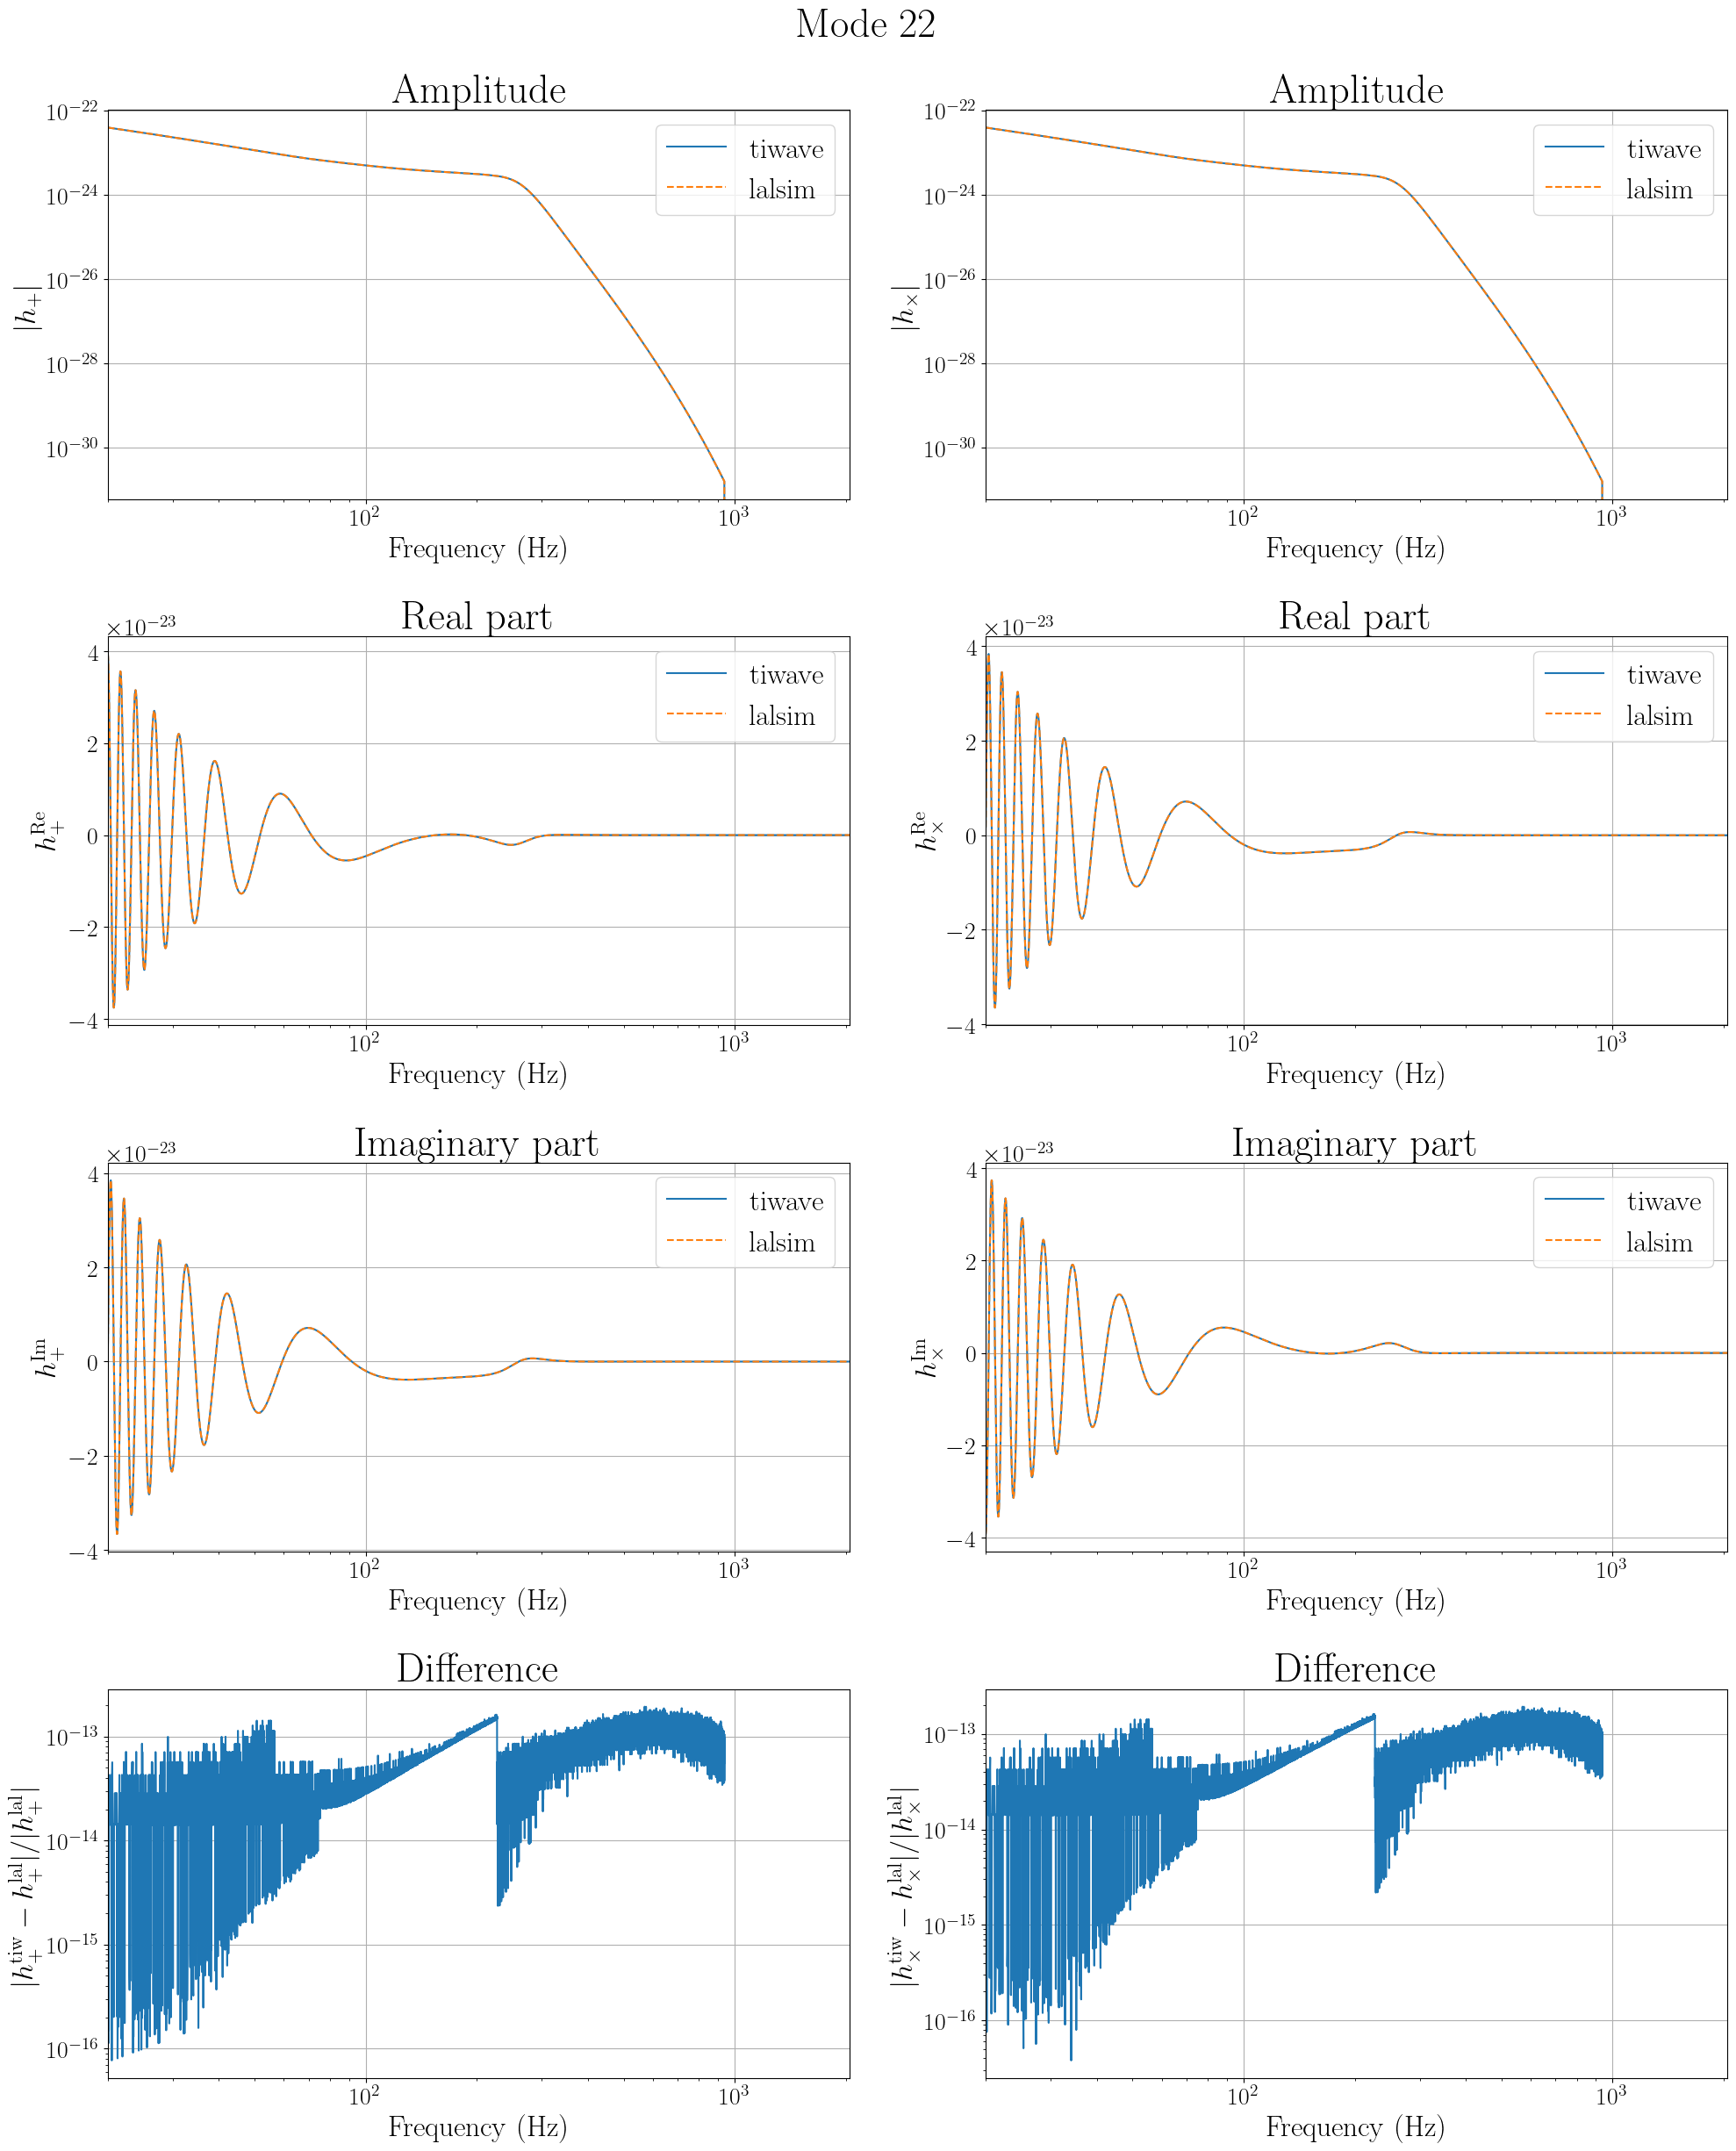

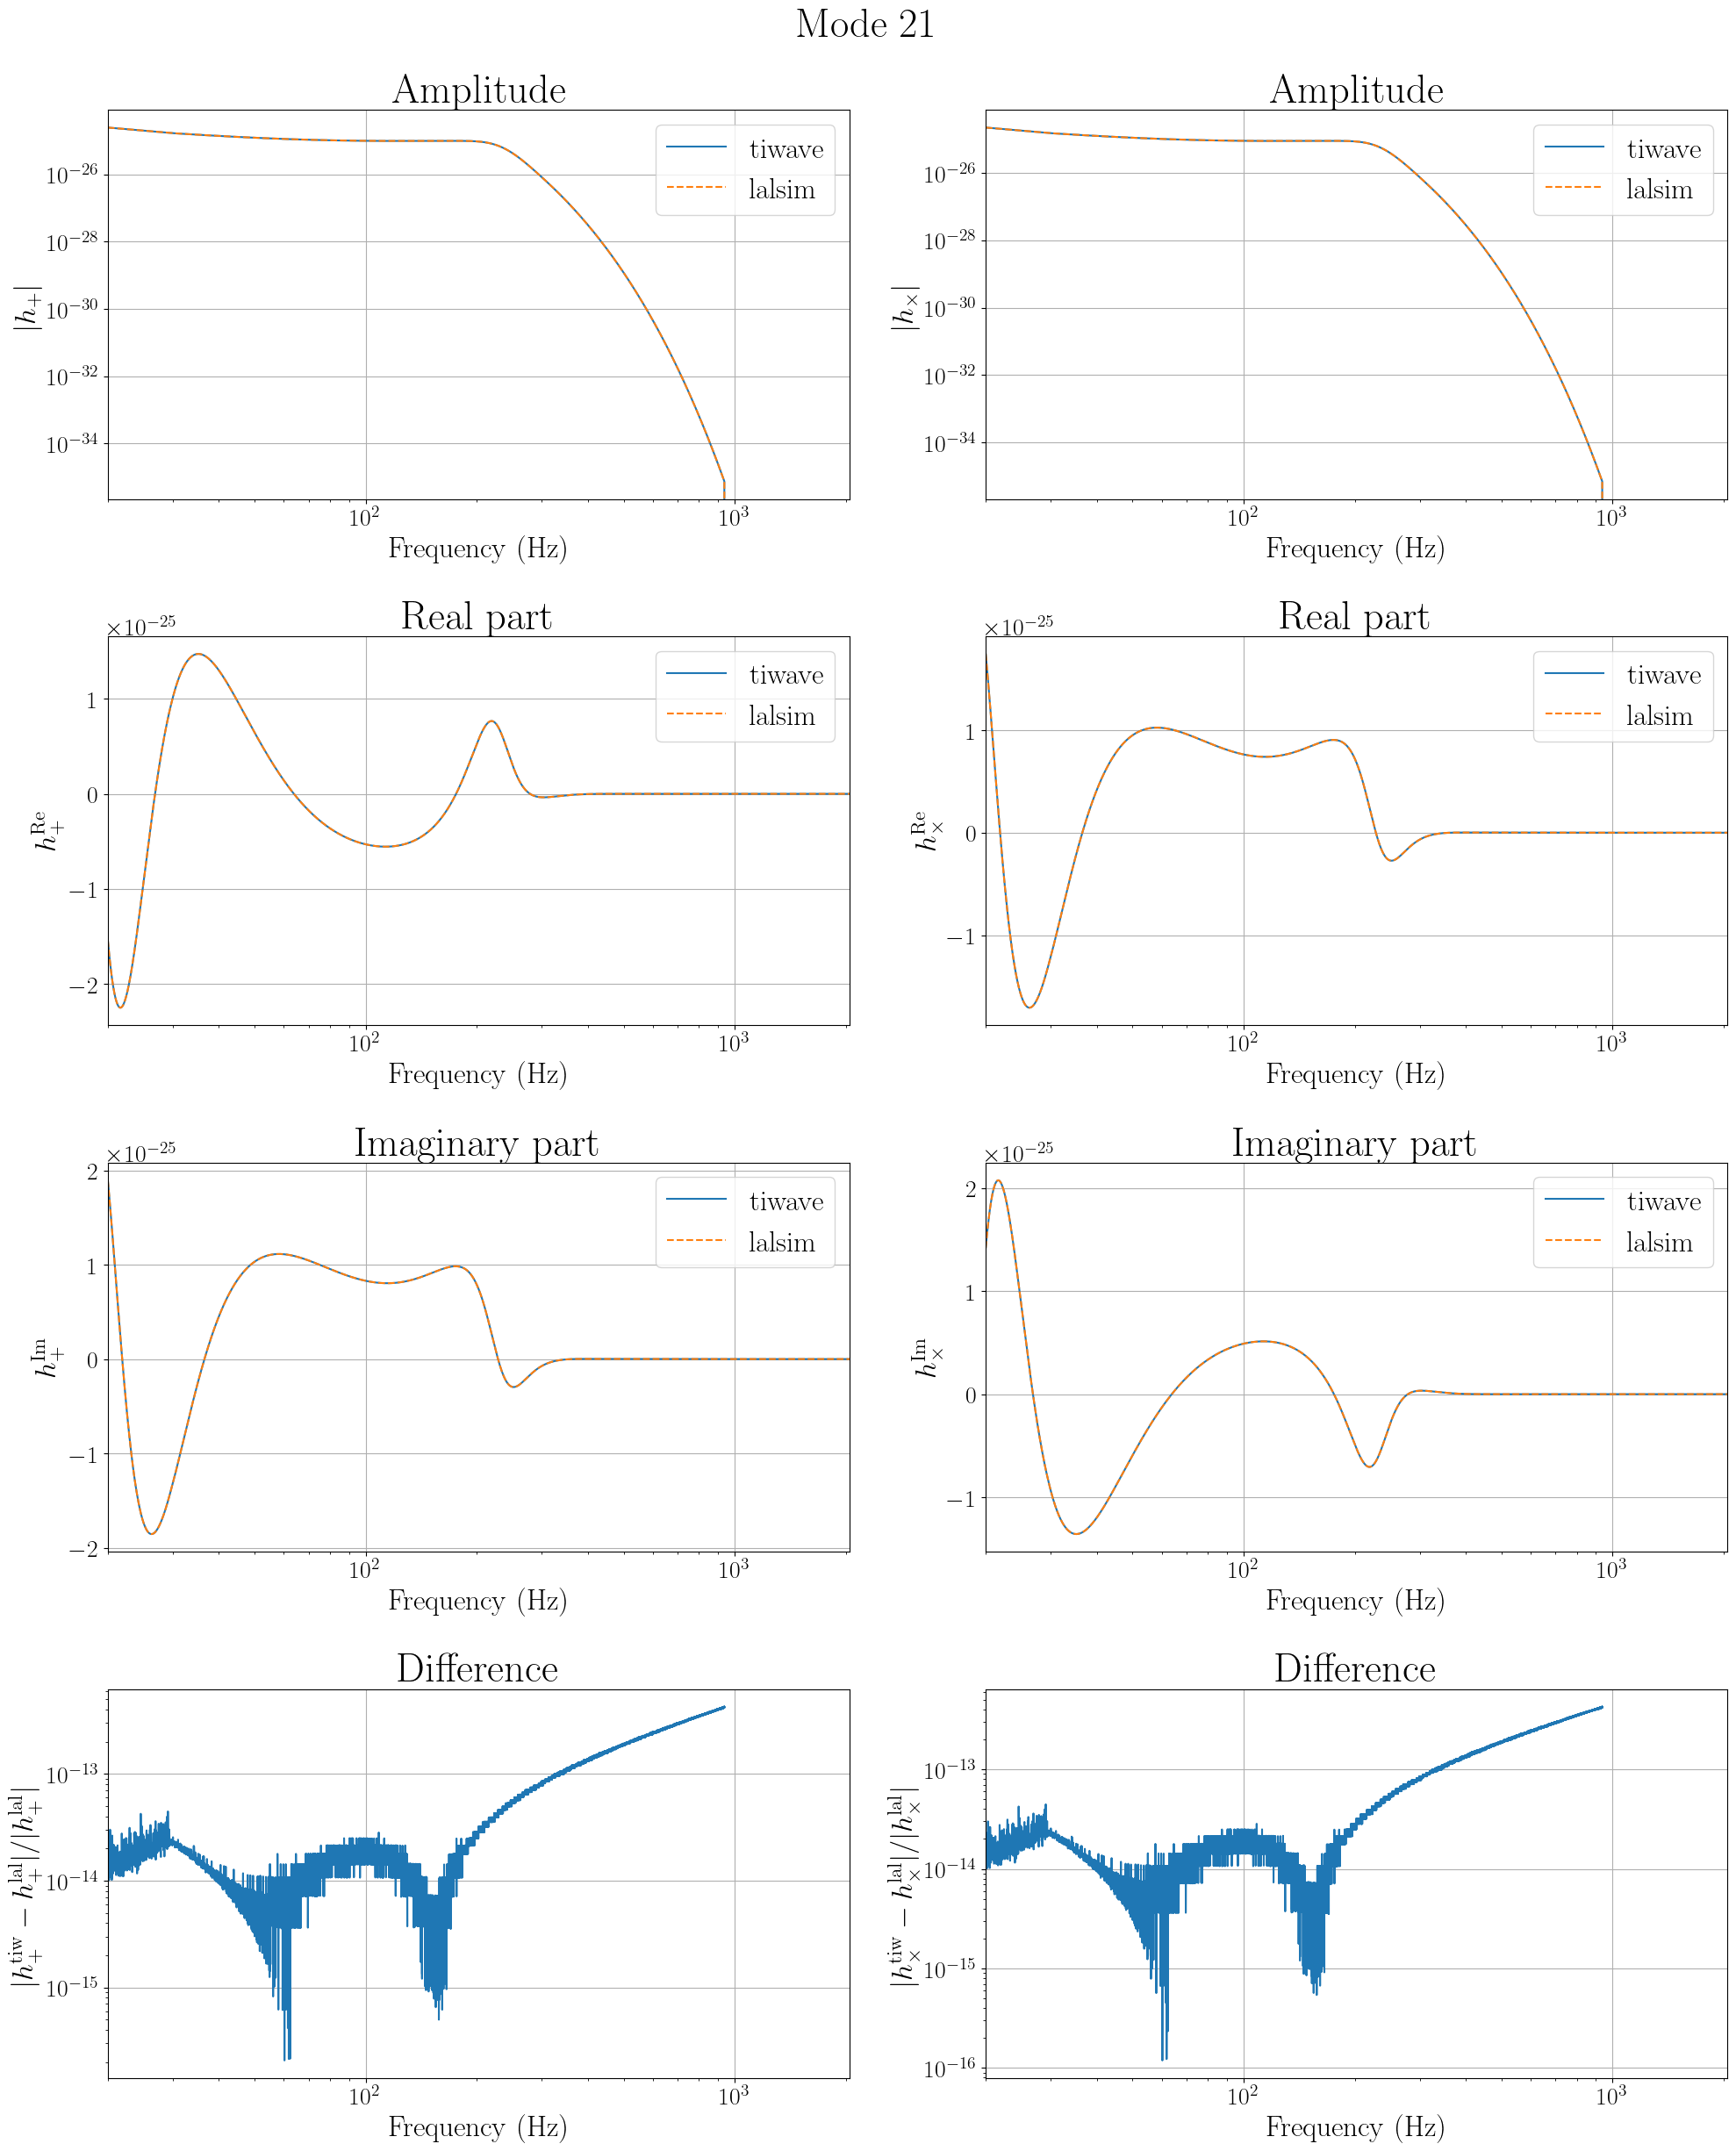

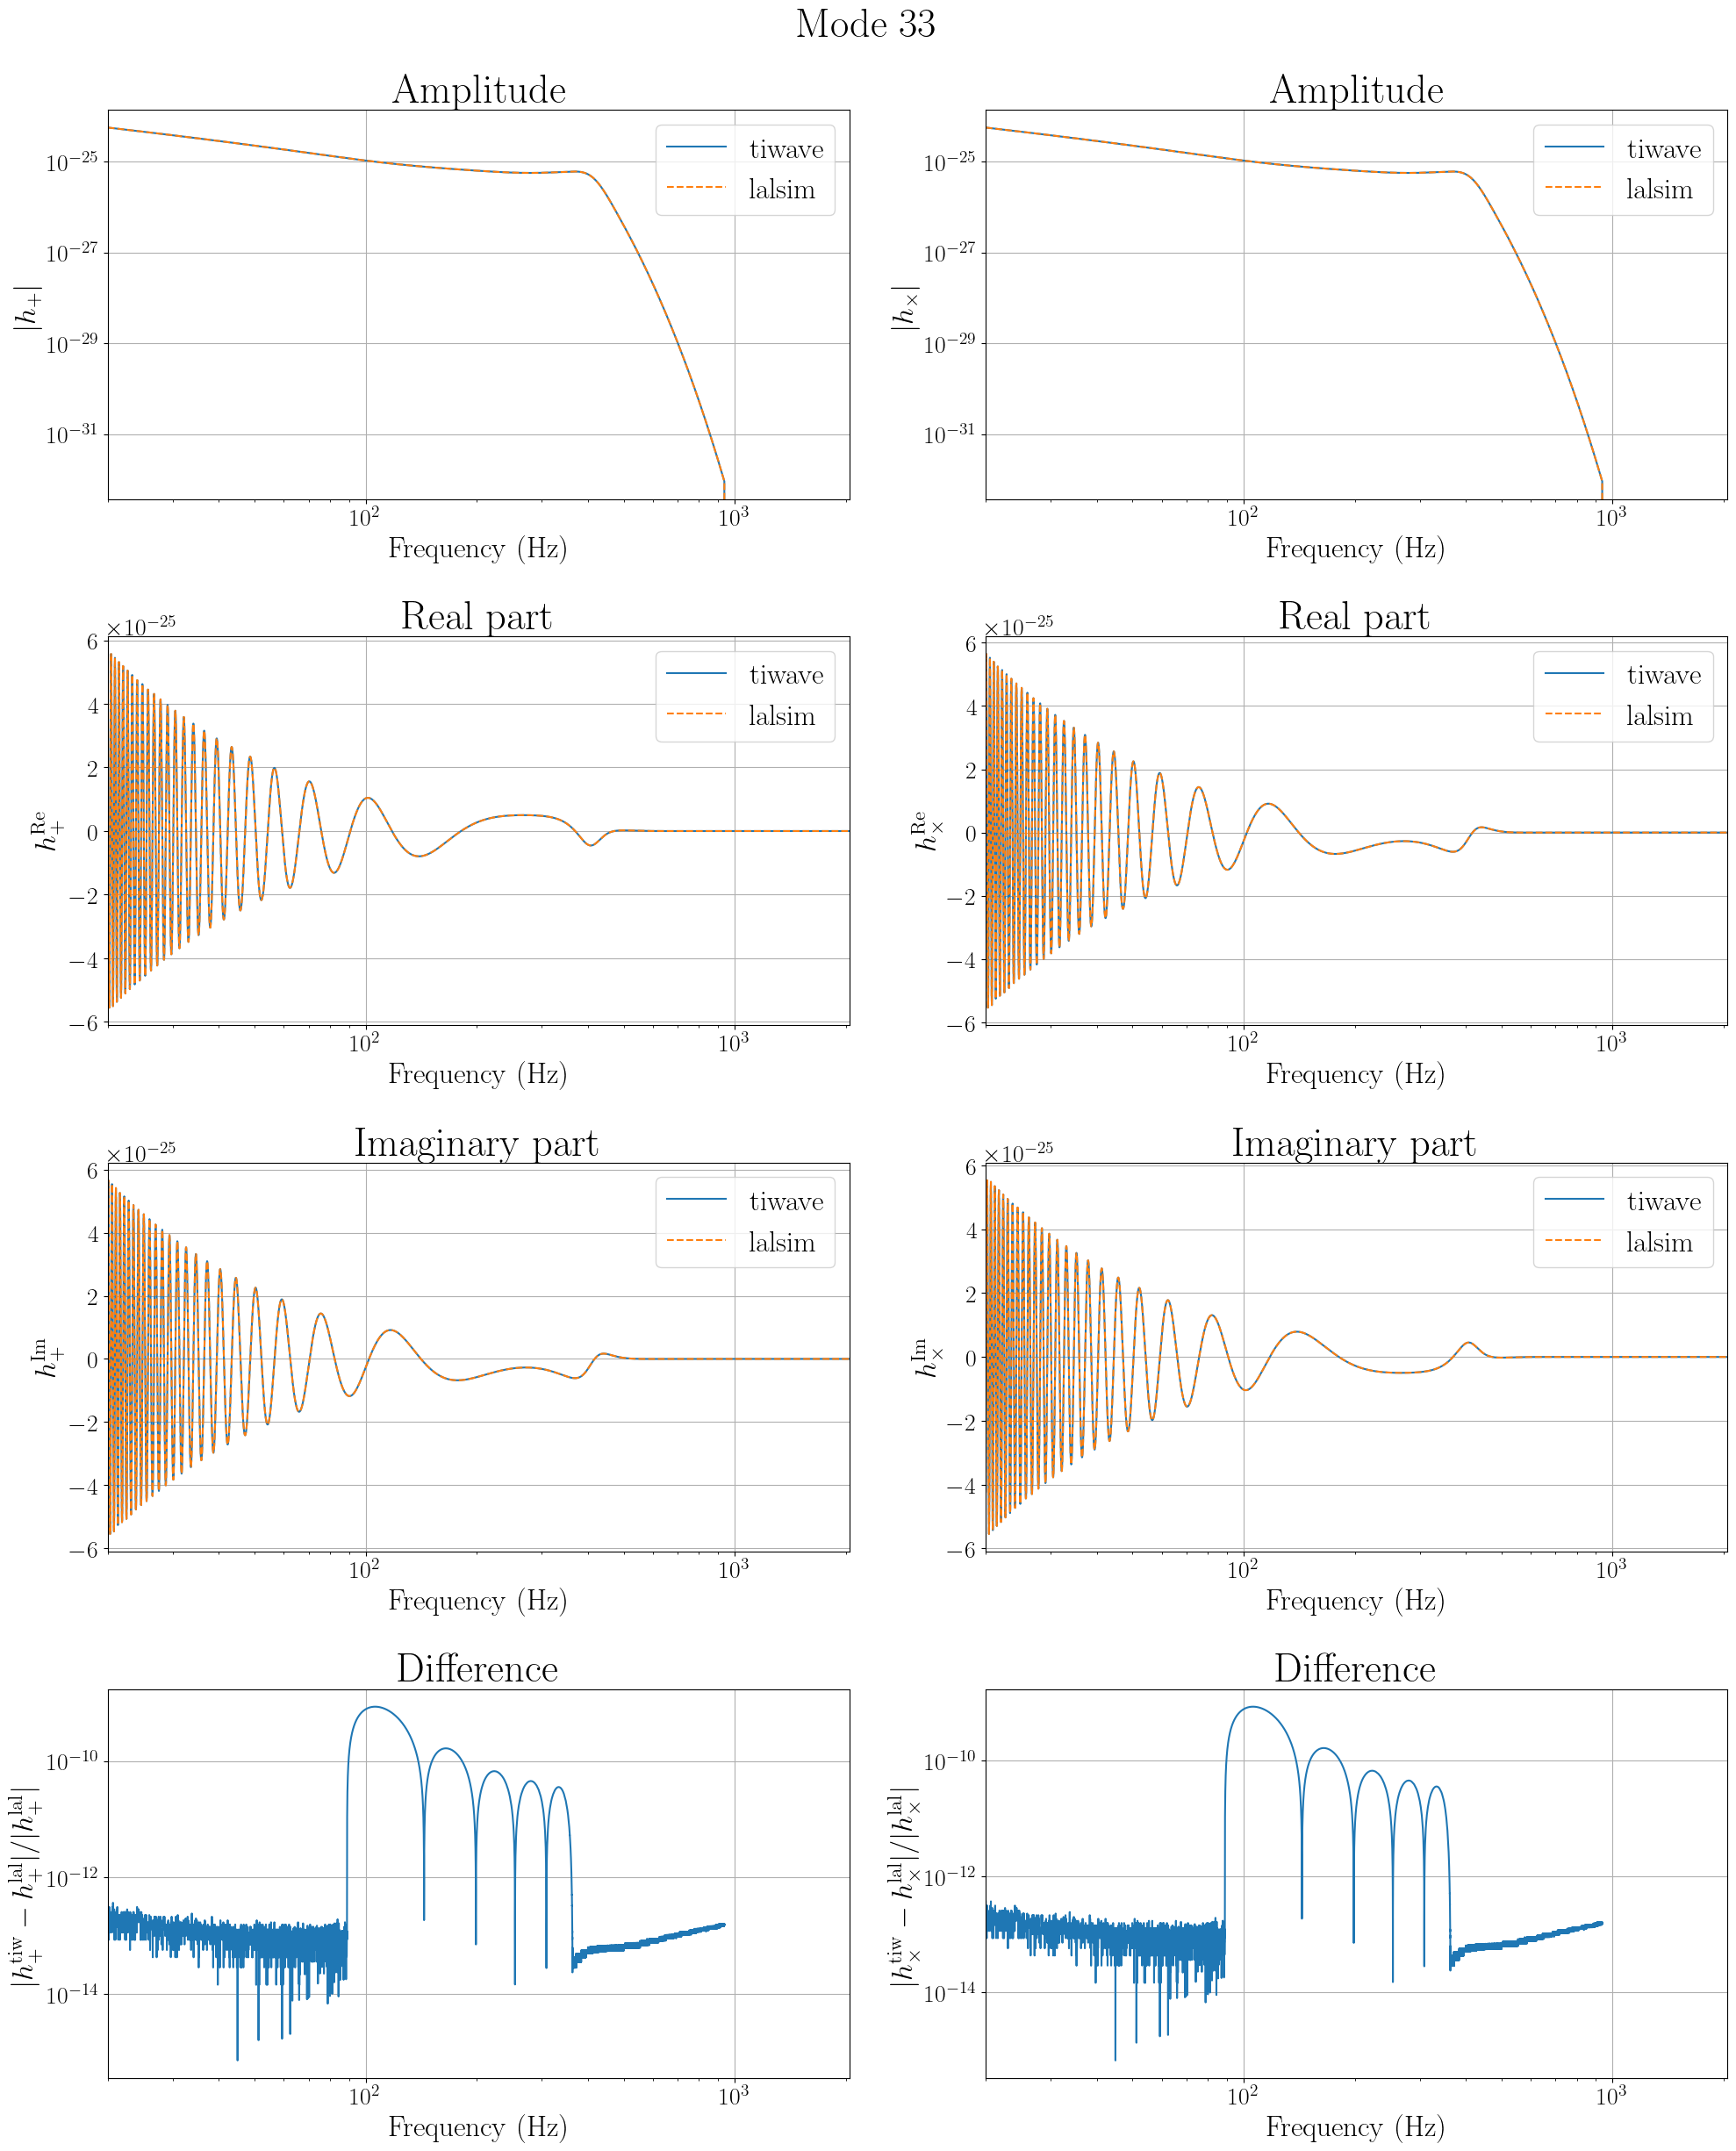

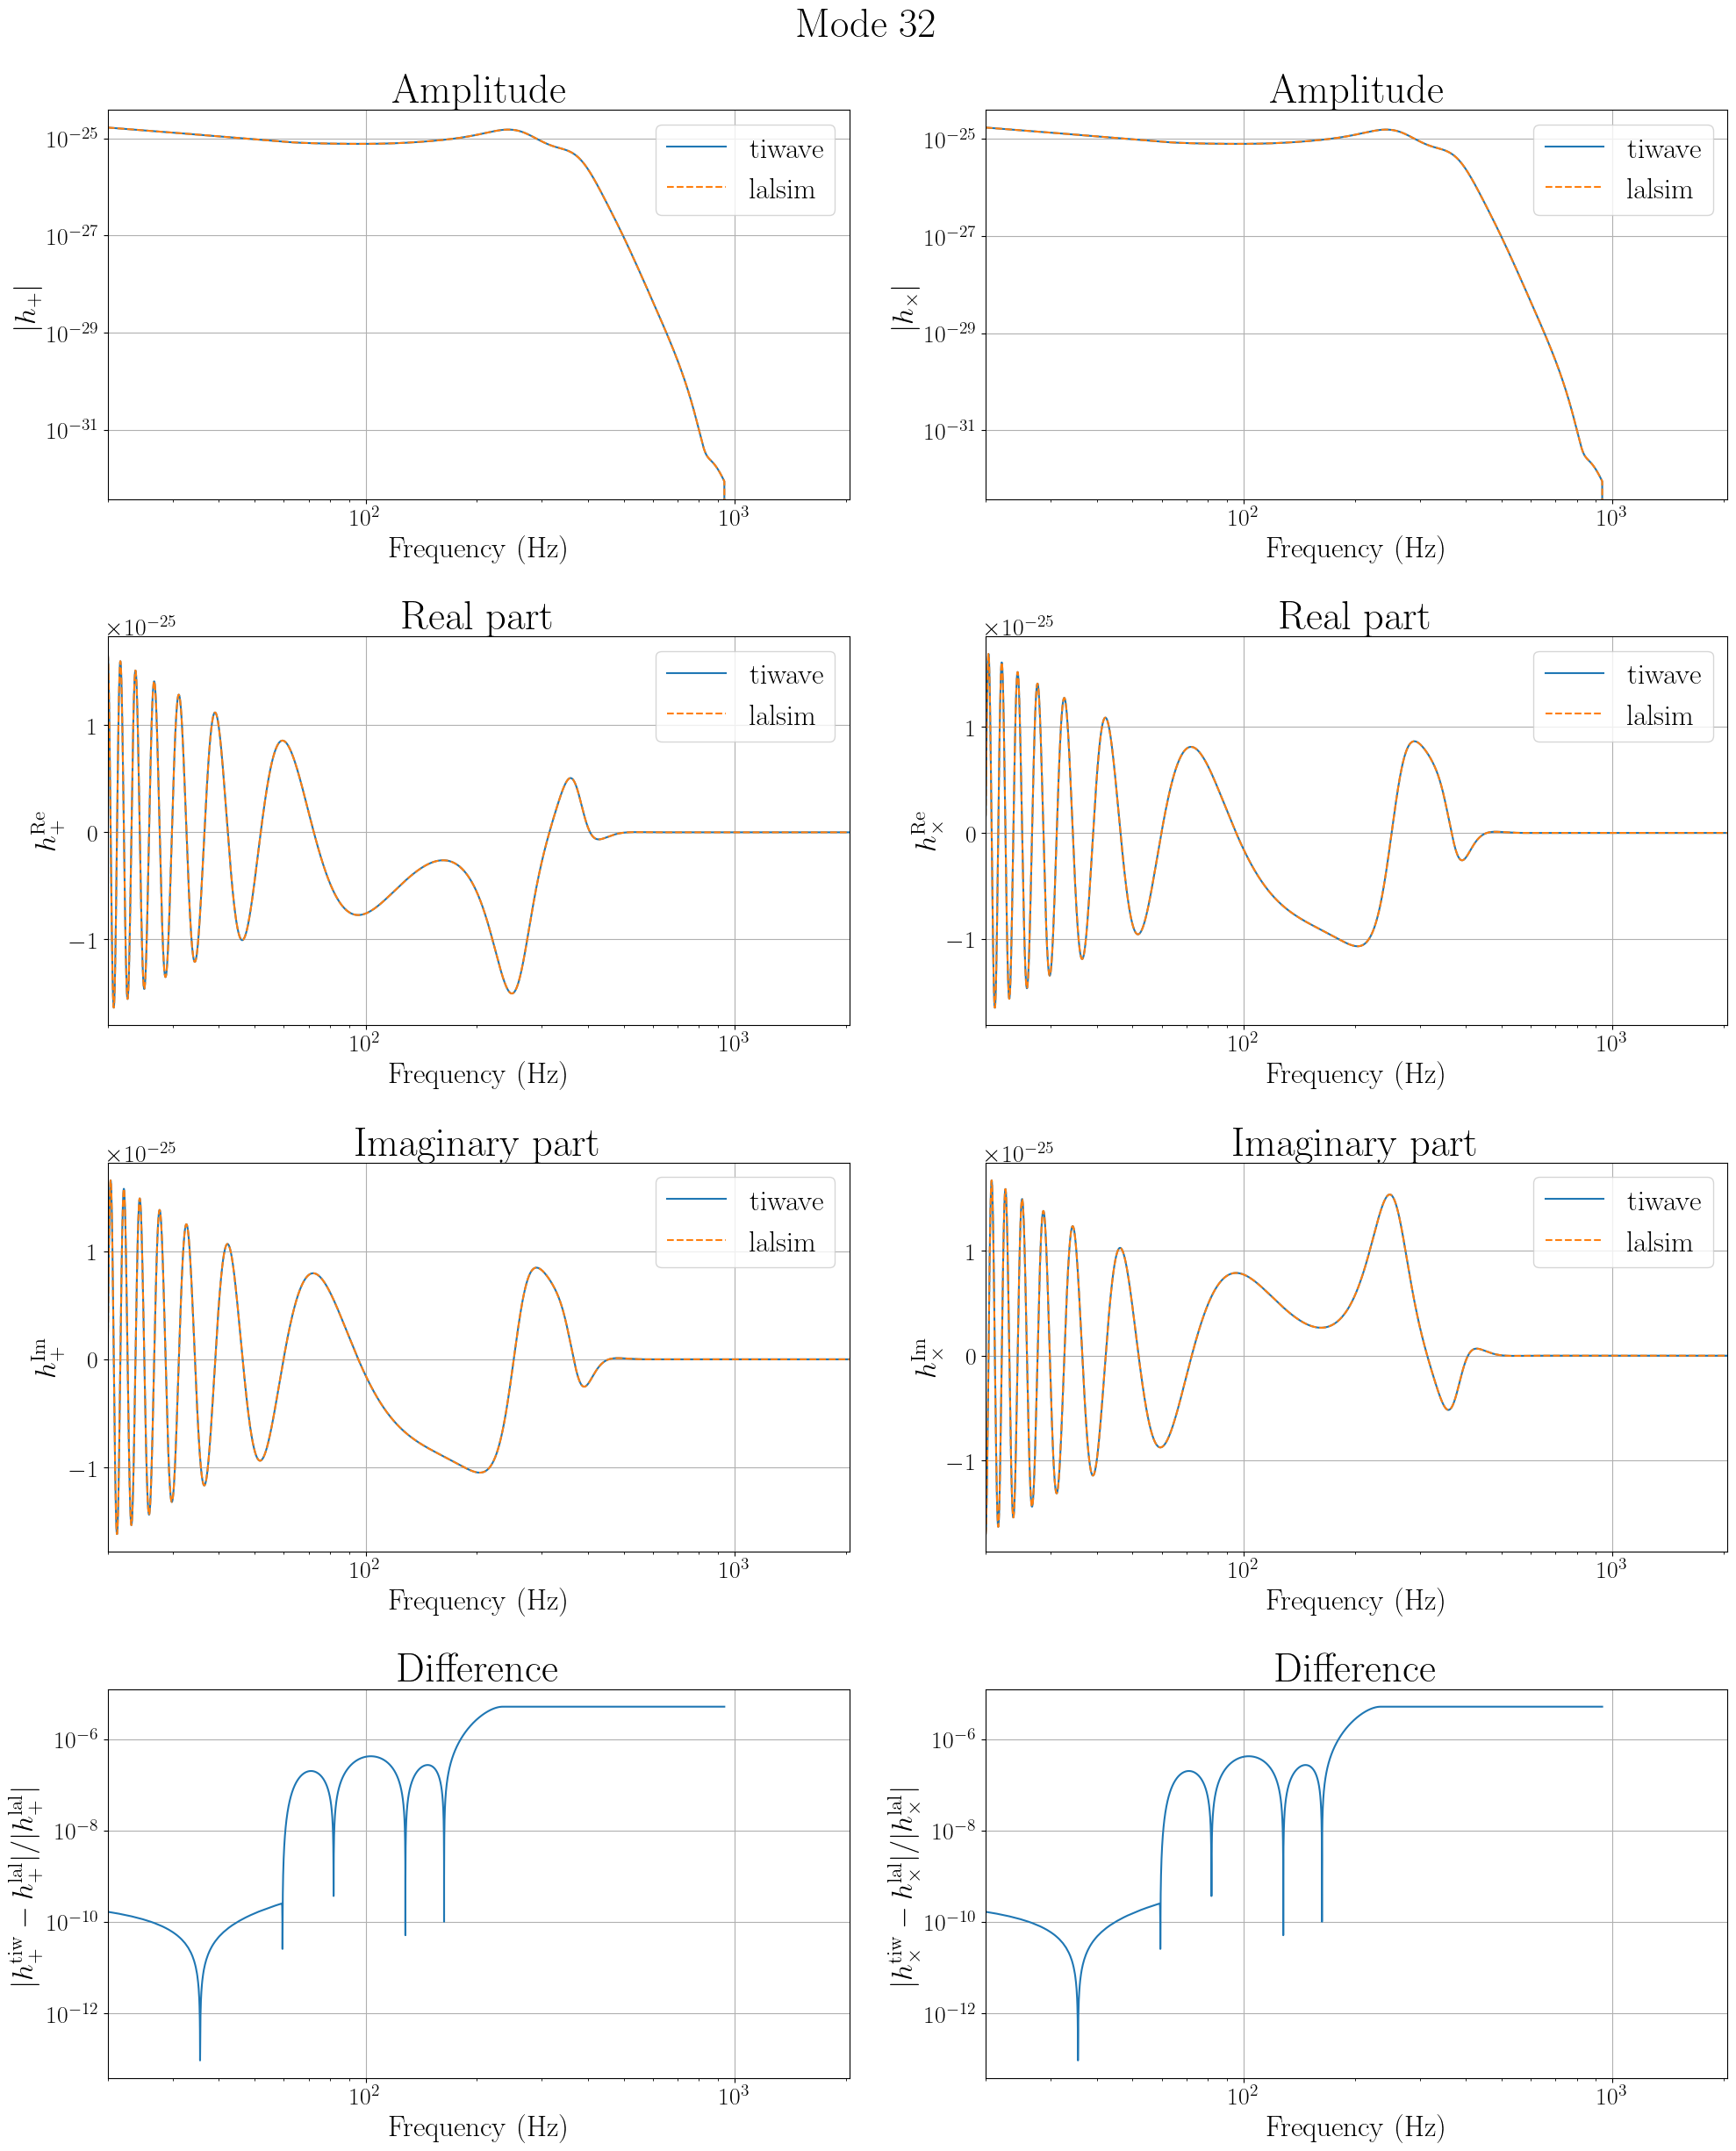

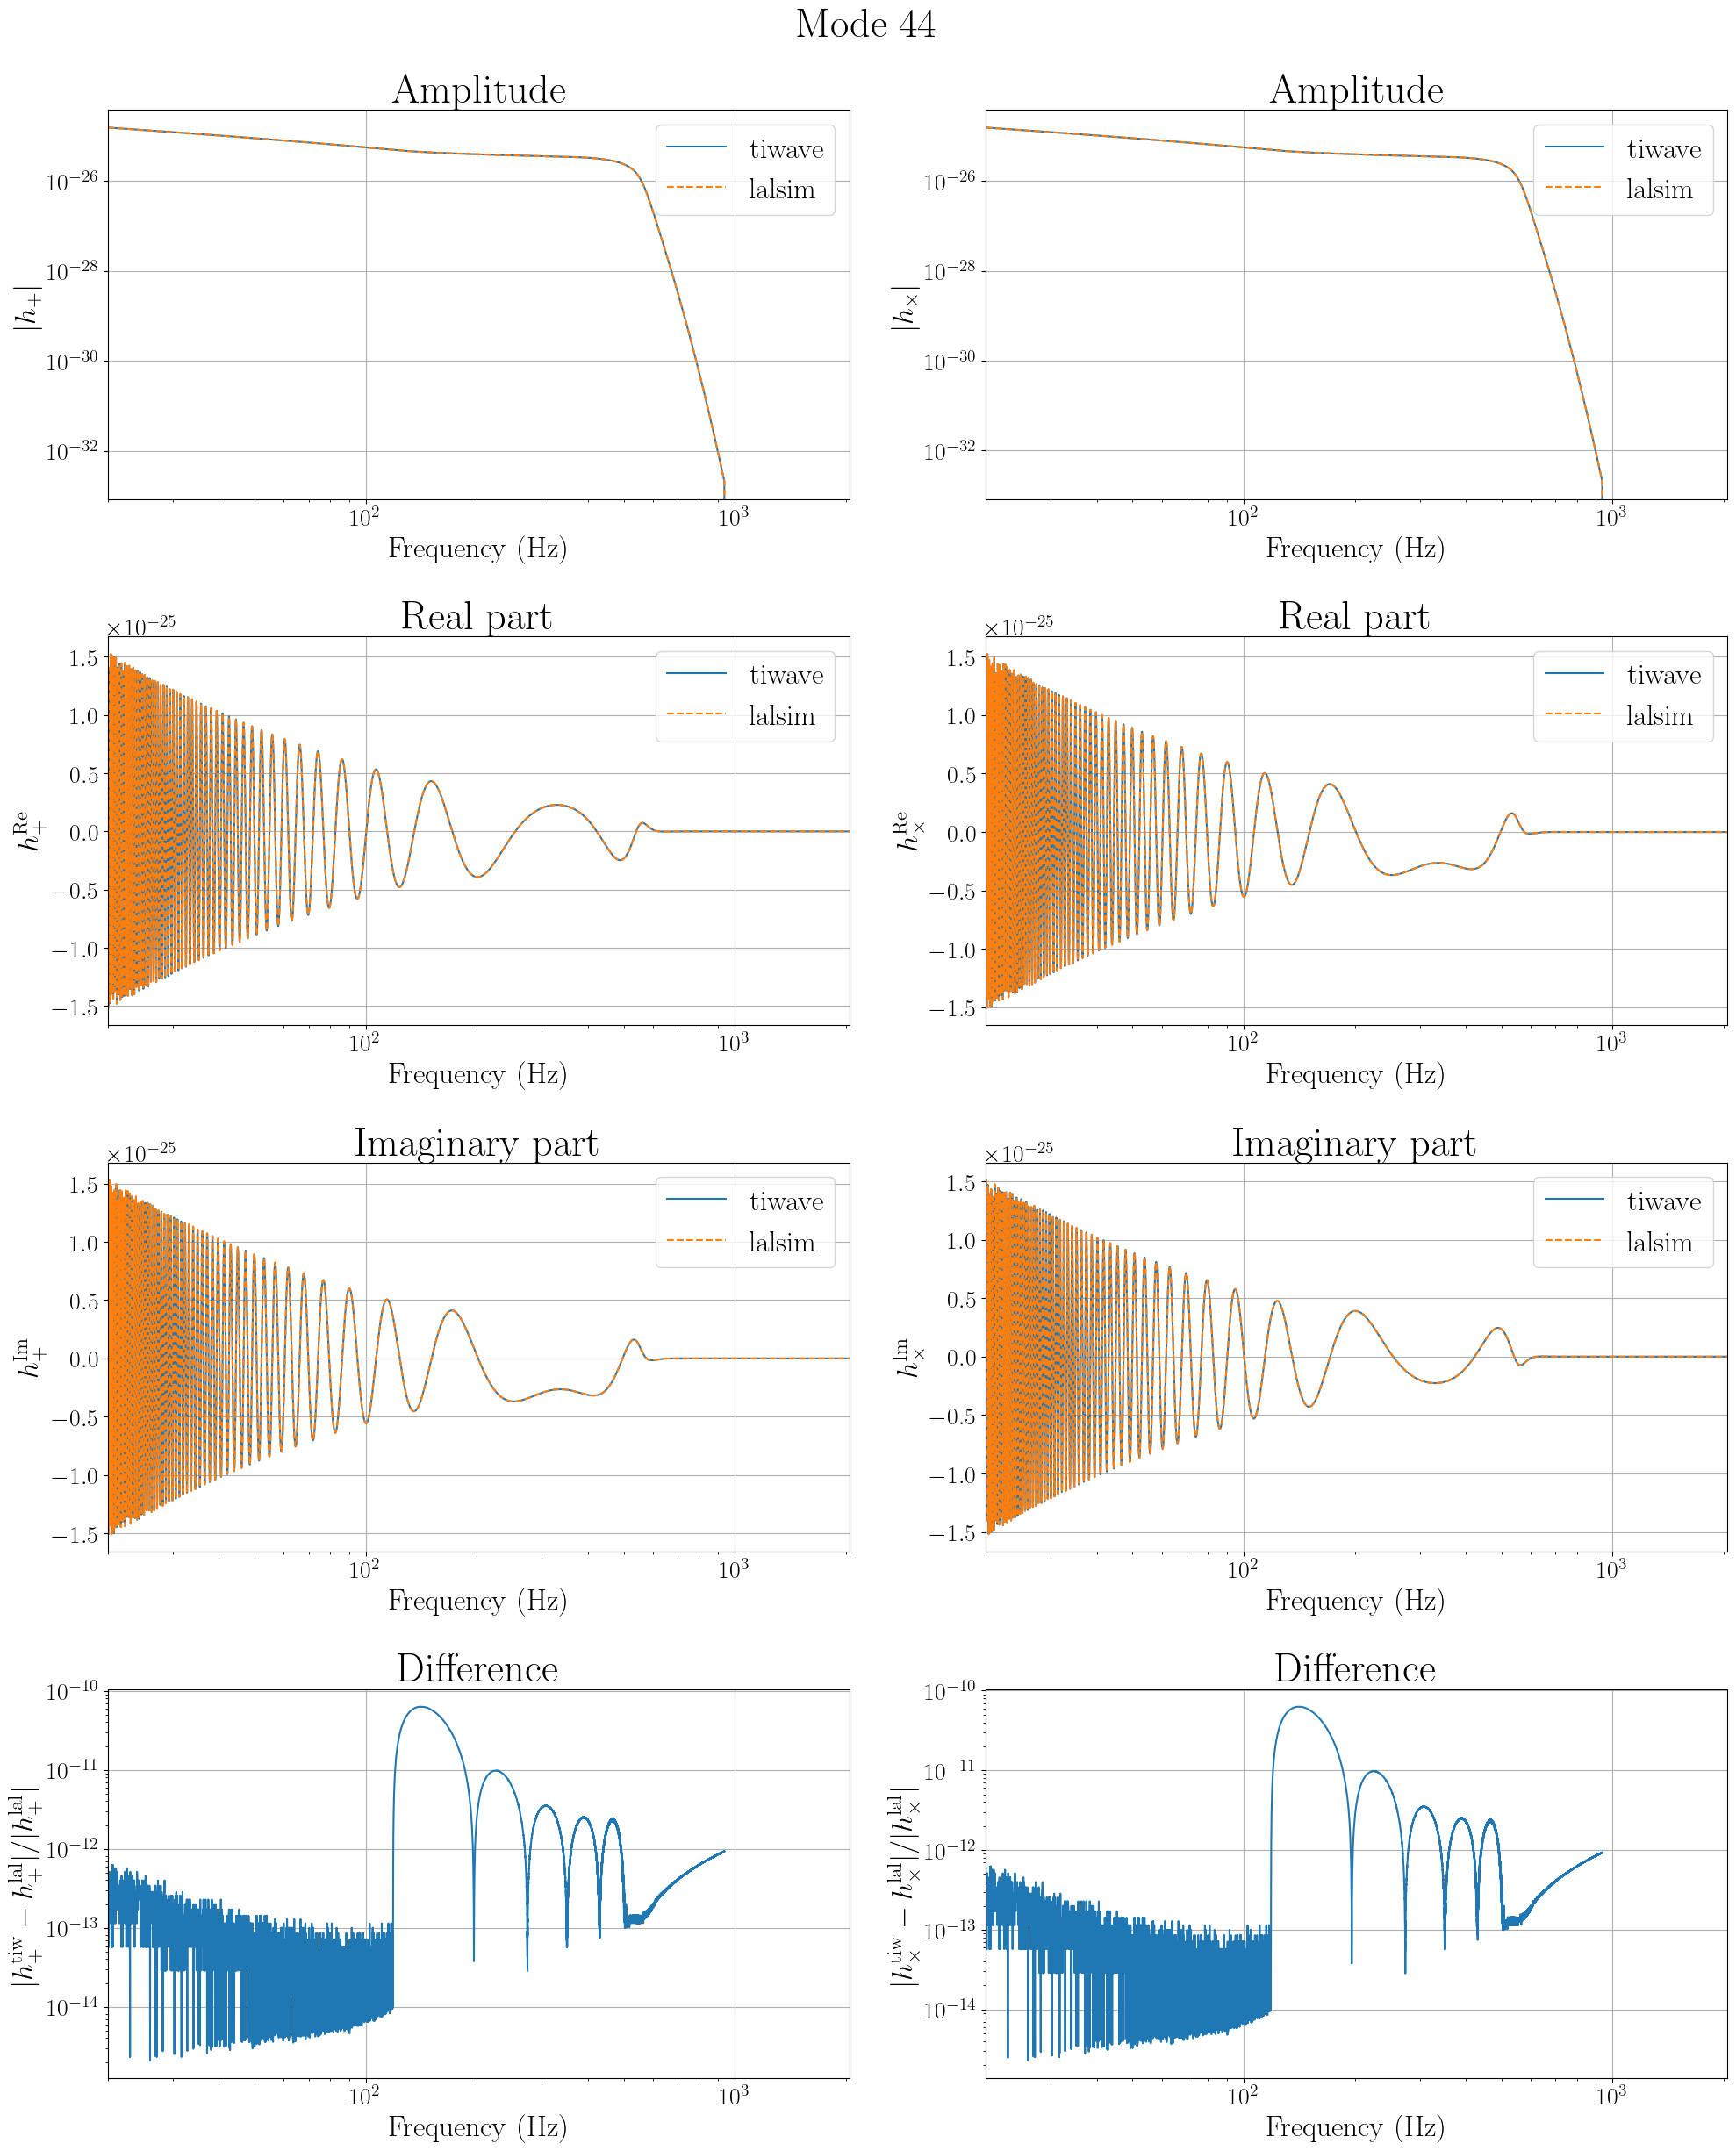

In [26]:
appro_xhm = lalsim.GetApproximantFromString("IMRPhenomXHM")

for mode in ["22", "21", "33", "32", "44"]:
    extra_params = lal.CreateDict()

    mode_array = [int(num) for num in mode]
    mode_array_lal = lalsim.SimInspiralCreateModeArray()
    lalsim.SimInspiralModeArrayActivateMode(mode_array_lal, *mode_array)
    lalsim.SimInspiralModeArrayActivateMode(
        mode_array_lal, mode_array[0], -mode_array[1]
    )
    lalsim.SimInspiralWaveformParamsInsertModeArray(extra_params, mode_array_lal)

    # turn-off multibanding
    lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(extra_params, 0)

    hp_lal, hc_lal = lalsim.SimInspiralChooseFDWaveform(
        float(parameters["mass_1"] * lal.MSUN_SI),
        float(parameters["mass_2"] * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(parameters["chi_1"]),
        float(0.0),
        float(0.0),
        float(parameters["chi_2"]),
        float(parameters["luminosity_distance"] * 1e6 * lal.PC_SI),
        float(parameters["inclination"]),
        float(parameters["reference_phase"]),
        float(long_asc_nodes),
        float(eccentricity),
        float(mean_per_ano),
        float(delta_f),
        float(freqs[0]),
        float(freqs[-1]),
        float(reference_frequency),
        extra_params,
        appro_xhm,
    )

    fig_mode = plot_waveform_comparison(
        xhm_tiw.waveform_container_numpy[mode],
        {"plus": hp_lal.data.data[freqs_mask], "cross": hc_lal.data.data[freqs_mask]},
    )
    fig_mode.suptitle(f"Mode {mode}")
    fig_mode.tight_layout()

/tmp/ipykernel_1425051/427251378.py:55: RuntimeWarning: invalid value encountered in divide
  axs[3, 0].loglog(freqs, np.abs(waveform_tiw["plus"] - waveform_lal["plus"])/np.abs(waveform_lal["plus"]))
/tmp/ipykernel_1425051/427251378.py:61: RuntimeWarning: invalid value encountered in divide
  axs[3, 1].loglog(freqs, np.abs(waveform_tiw["cross"] - waveform_lal["cross"])/np.abs(waveform_lal["cross"]))


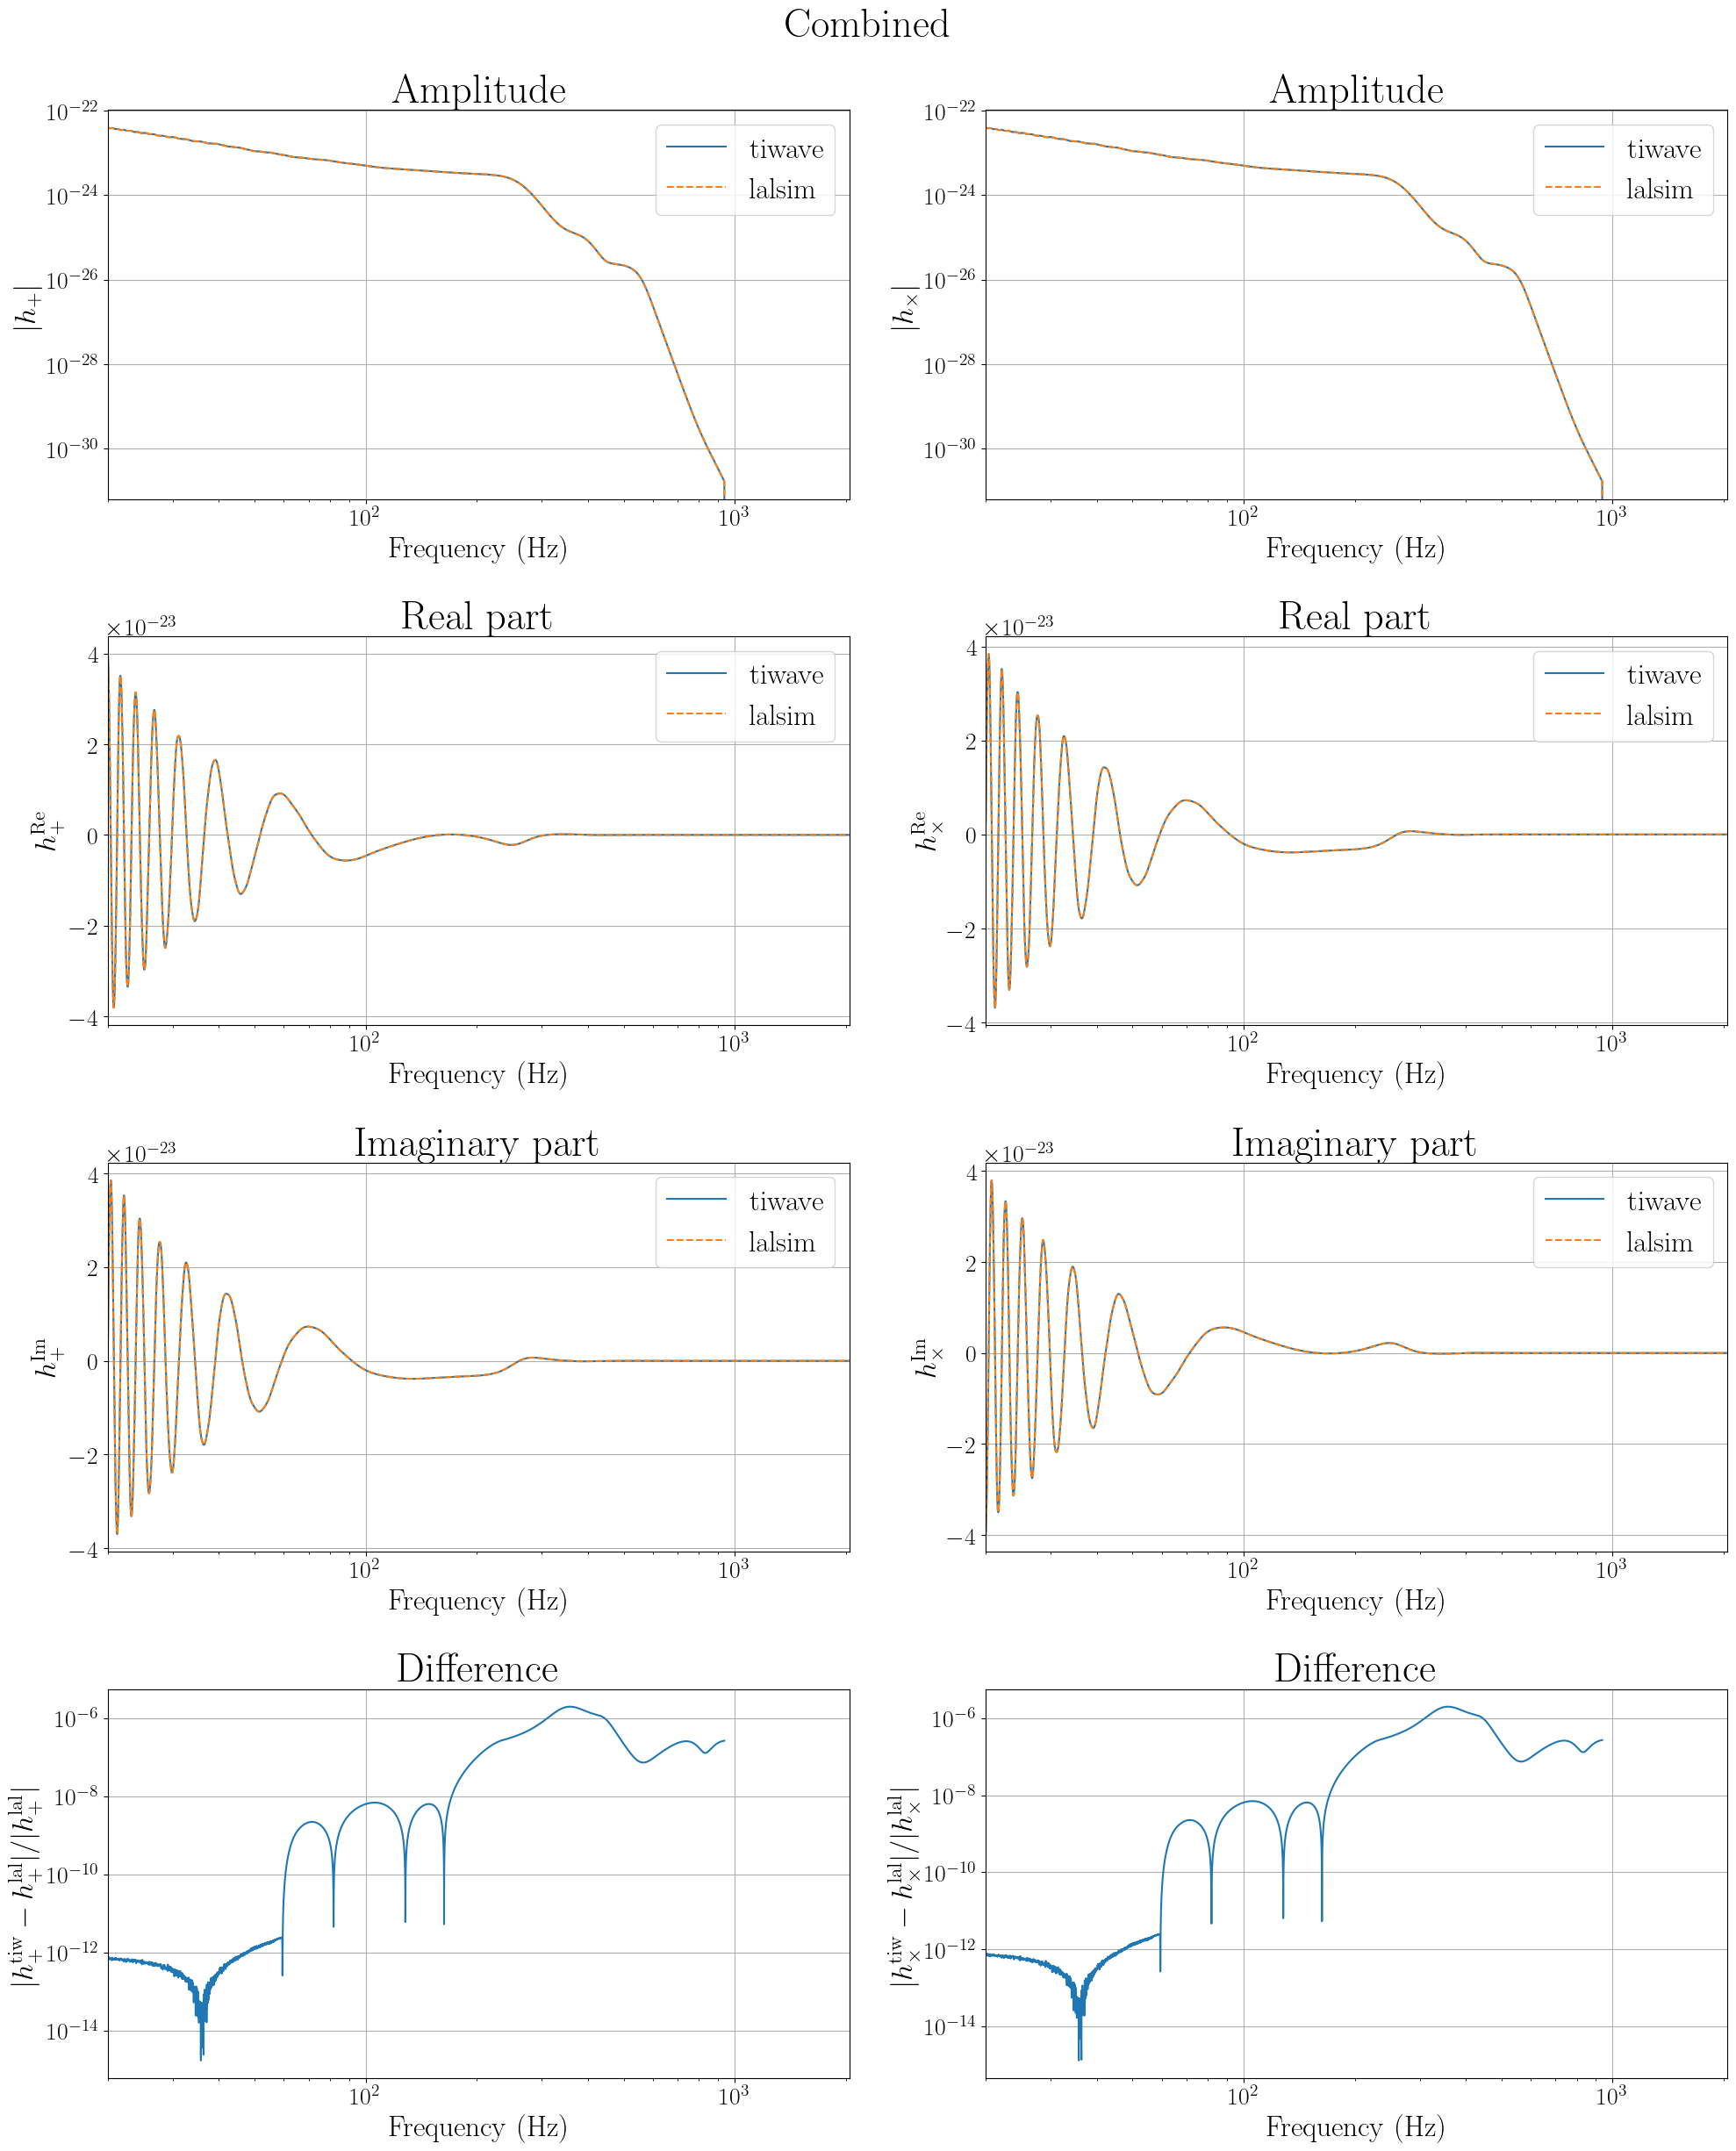

In [27]:
extra_params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(extra_params, 0)

hp_lal, hc_lal = lalsim.SimInspiralChooseFDWaveform(
    float(parameters["mass_1"] * lal.MSUN_SI),
    float(parameters["mass_2"] * lal.MSUN_SI),
    float(0.0),
    float(0.0),
    float(parameters["chi_1"]),
    float(0.0),
    float(0.0),
    float(parameters["chi_2"]),
    float(parameters["luminosity_distance"] * 1e6 * lal.PC_SI),
    float(parameters["inclination"]),
    float(parameters["reference_phase"]),
    float(long_asc_nodes),
    float(eccentricity),
    float(mean_per_ano),
    float(delta_f),
    float(freqs[0]),
    float(freqs[-1]),
    float(reference_frequency),
    extra_params,
    appro_xhm,
)
fig_combined = plot_waveform_comparison(
    xhm_tiw.waveform_container_numpy["combined"],
    {"plus": hp_lal.data.data[freqs_mask], "cross": hc_lal.data.data[freqs_mask]},
)
fig_combined.suptitle("Combined")
fig_combined.tight_layout()

### 3. Mismatch in the whole parameter space

In [28]:
appro_xhm = lalsim.GetApproximantFromString("IMRPhenomXHM")


def xhm_tiw_wrapper(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
    luminosity_distance,
    inclination,
    reference_phase,
):
    params_in = {
        "mass_1": mass_1,
        "mass_2": mass_2,
        "chi_1": chi_1,
        "chi_2": chi_2,
        "luminosity_distance": luminosity_distance,
        "inclination": inclination,
        "reference_phase": reference_phase,
    }
    # xhm_tiw is initialized externally, ensure high_modes is set correctly
    xhm_tiw.update_waveform(params_in)

    if len(xhm_tiw.high_modes) == 1:
        (ret_key,) = xhm_tiw.high_modes
    elif len(xhm_tiw.high_modes) == 4:
        ret_key = "combined"
    else:
        raise Exception()

    return xhm_tiw.waveform_container_numpy[ret_key]


def xhm_lal_wrapper(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
    luminosity_distance,
    inclination,
    reference_phase,
):
    # extra_params is created externally, ensure extra_params is set correctly
    hp, hc = lalsim.SimInspiralChooseFDWaveform(
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(luminosity_distance * 1e6 * lal.PC_SI),
        float(inclination),
        float(reference_phase),
        float(long_asc_nodes),
        float(eccentricity),
        float(mean_per_ano),
        float(delta_f),
        float(freqs[0]),
        float(freqs[-1]),
        float(reference_frequency),
        extra_params,
        appro_xhm,
    )

    return {"plus": hp.data.data[freqs_mask], "cross": hc.data.data[freqs_mask]}


mismatch_wrapper = partial(
    mismatch,
    tiw_wf_func=xhm_tiw_wrapper,
    lal_wf_func=xhm_lal_wrapper,
    psd_array=psd_array,
    delta_f=delta_f,
)

In [29]:
mism = {}

for mode in ["21", "33", "32", "44"]:
    extra_params = lal.CreateDict()
    mode_array = [int(num) for num in mode]
    mode_array_lal = lalsim.SimInspiralCreateModeArray()
    lalsim.SimInspiralModeArrayActivateMode(mode_array_lal, *mode_array)
    lalsim.SimInspiralModeArrayActivateMode(
        mode_array_lal, mode_array[0], -mode_array[1]
    )
    lalsim.SimInspiralWaveformParamsInsertModeArray(extra_params, mode_array_lal)
    # turn-off multibanding
    lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(extra_params, 0)

    xhm_tiw = IMRPhenomXHM(freqs_ti, reference_frequency, high_modes=(mode,))

    mism_mode = list(
        map(
            mismatch_wrapper,
            samples_x["mass_1"],
            samples_x["mass_2"],
            samples_x["chi_1"],
            samples_x["chi_2"],
            samples_x["luminosity_distance"],
            samples_x["inclination"],
            samples_x["reference_phase"],
        )
    )
    mism_mode = np.array(mism_mode)
    mism[mode] = mism_mode

/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/base_waveform.py:45: UserWarning: check_parameters is disable, make sure all parameters passed in are valid.
  warnings.warn(
/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/IMRPhenomXHM.py:7036: UserWarning: Mode 32 has relatively large numerical errors with lalsim, please make sure these errors are acceptable in your cases before using.
  warnings.warn(
/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/IMRPhenomXHM.py:7041: UserWarning: `tf` is required for mode 32, since the derivative of phase for merge-ringdown of mode 32 is obtained through numerical difference, if may not reliable for some cases.
  warnings.warn(


In [30]:
extra_params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(extra_params, 0)

xhm_tiw = IMRPhenomXHM(freqs_ti, reference_frequency, combine_modes=True)

mism_combined = list(
    map(
        mismatch_wrapper,
        samples_x["mass_1"],
        samples_x["mass_2"],
        samples_x["chi_1"],
        samples_x["chi_2"],
        samples_x["luminosity_distance"],
        samples_x["inclination"],
        samples_x["reference_phase"],
    )
)
mism_combined = np.array(mism_combined)
mism["combined"] = mism_combined

21
The maximum mismatch in samples is:  6.661338147750939e-16
The minimum mismatch in samples is:  -6.661338147750939e-16
33
The maximum mismatch in samples is:  1.2212453270876722e-15
The minimum mismatch in samples is:  -6.661338147750939e-16
32
The maximum mismatch in samples is:  0.8880319787522517
The minimum mismatch in samples is:  -4.440892098500626e-16
44
The maximum mismatch in samples is:  1.2212453270876722e-15
The minimum mismatch in samples is:  -6.661338147750939e-16
combined
The maximum mismatch in samples is:  0.0020310988448081213
The minimum mismatch in samples is:  -4.440892098500626e-16


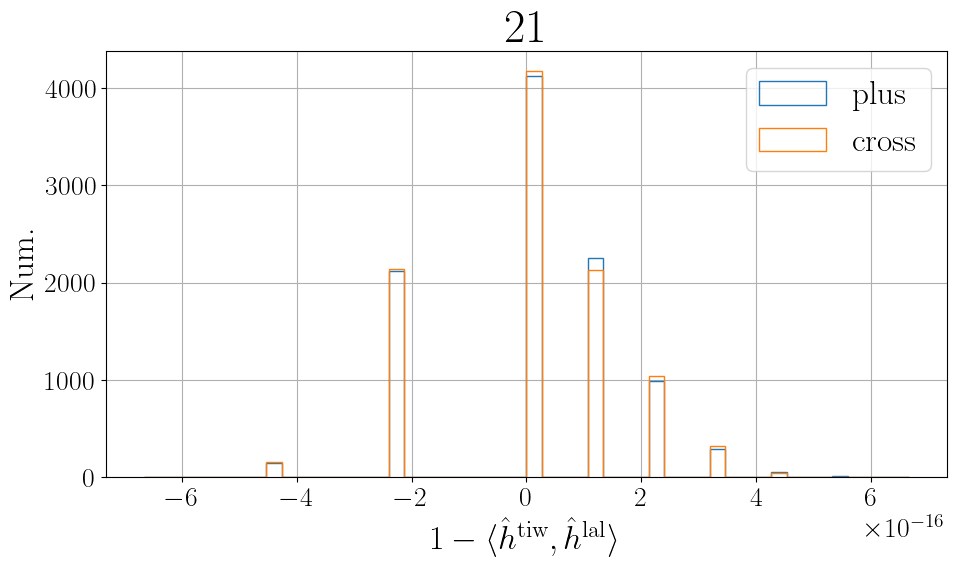

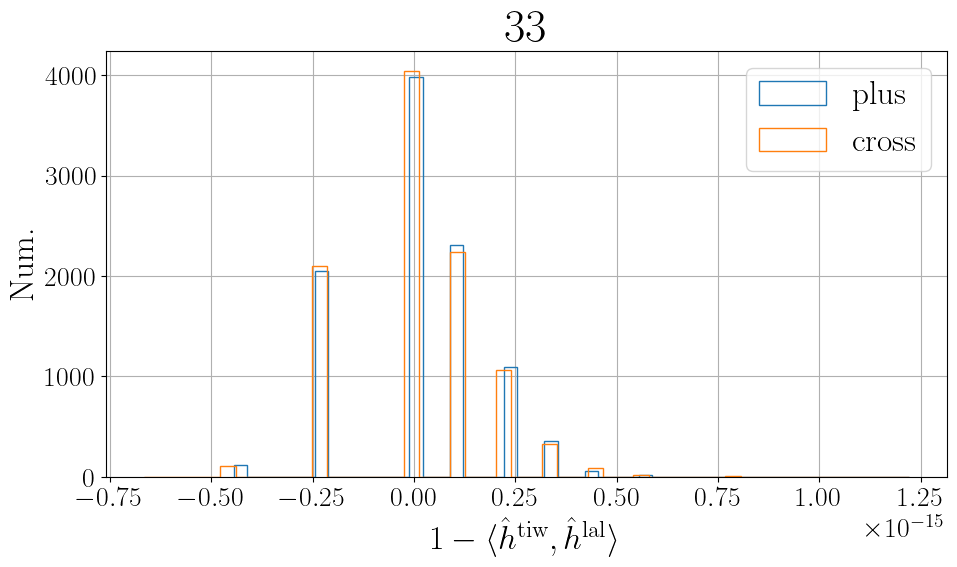

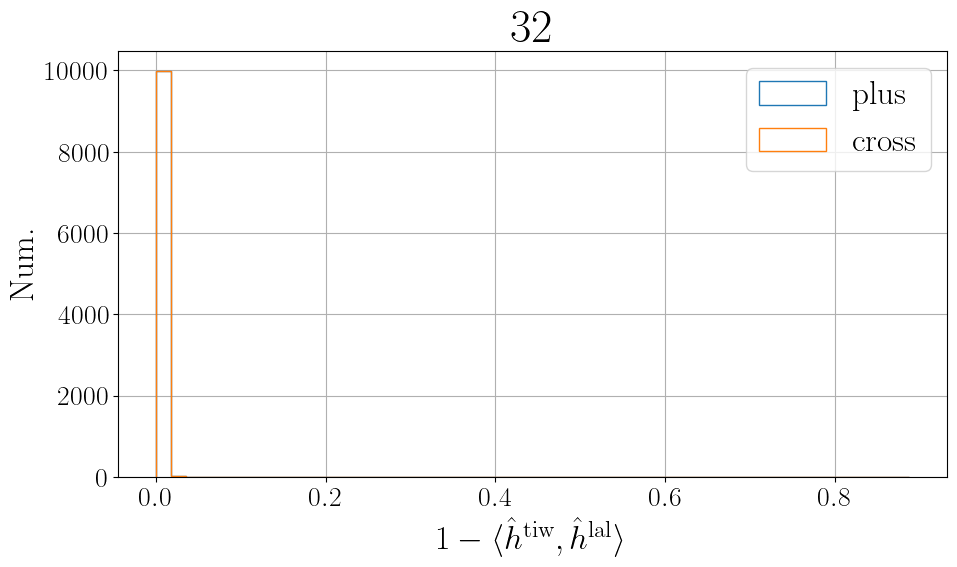

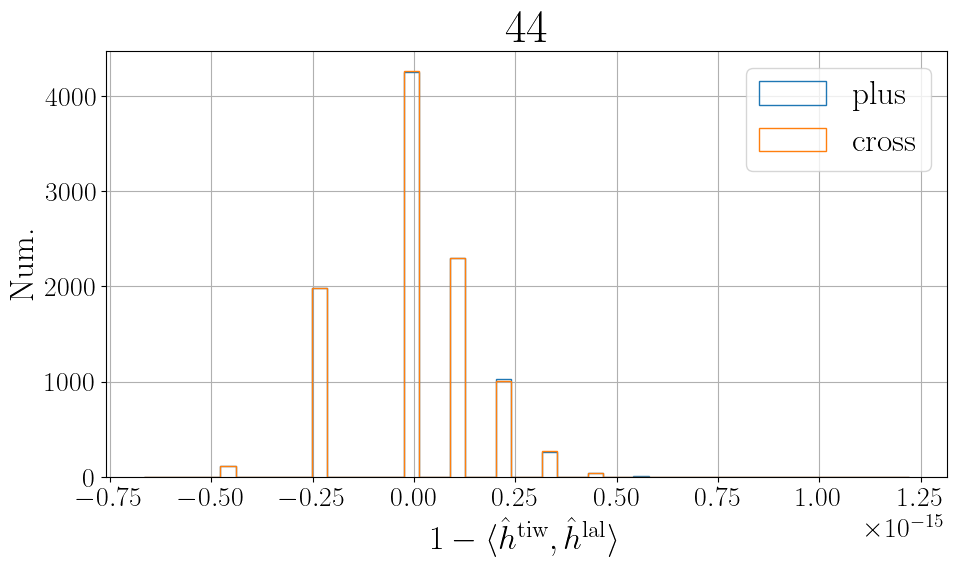

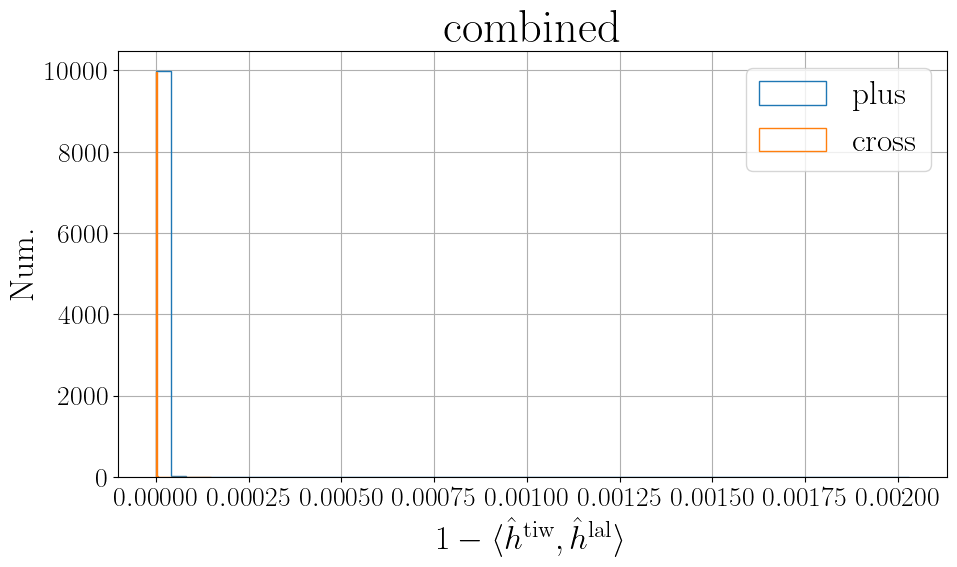

In [ ]:
for key in ["21", "33", "32", "44", "combined"]:

    print(key)
    print("The maximum mismatch in samples is: ", mism[key].max())
    print("The minimum mismatch in samples is: ", mism[key].min())

    fig, ax = plt.subplots()
    ax.hist(
        mism[key][:, 0],
        bins=50,
        histtype="step",
        label="plus",
    )
    ax.hist(
        mism[key][:, 1],
        bins=50,
        histtype="step",
        label="cross",
    )
    ax.set_xlabel(r"$1-\langle \hat{h}^{\rm tiw} , \hat{h}^{\rm lal}\rangle$")
    ax.set_ylabel("Num.")
    ax.legend()
    ax.set_title(key)
    fig.tight_layout()
    fig.show()

# note minus values are induced by numerical errors in the computation of the inner product

### 4. More checks for the mode 32

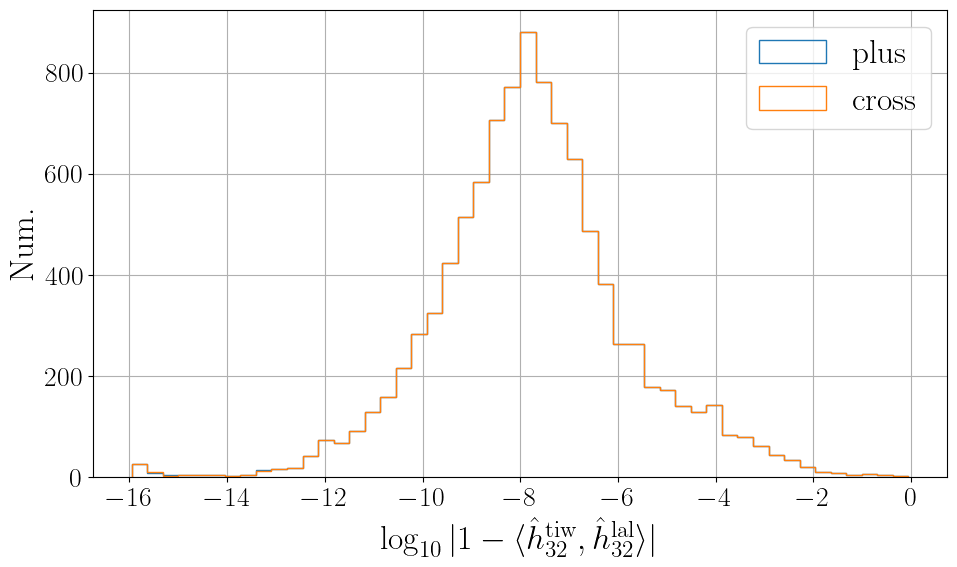

In [ ]:
mism_32_p = np.abs(mism["32"][:, 0])
mism_32_c = np.abs(mism["32"][:, 1])

fig, ax = plt.subplots()
ax.hist(
    np.log10(mism_32_p[mism_32_p > 0]),
    bins=50,
    histtype="step",
    label="plus",
)
ax.hist(
    np.log10(mism_32_c[mism_32_c > 0]),
    bins=50,
    histtype="step",
    label="cross",
)
ax.set_xlabel(
    r"$\log_{10}|1-\langle \hat{h}^{\rm tiw}_{32} , \hat{h}^{\rm lal}_{32}\rangle|$"
)
ax.set_ylabel("Num.")
ax.legend()
fig.tight_layout()
fig.show()

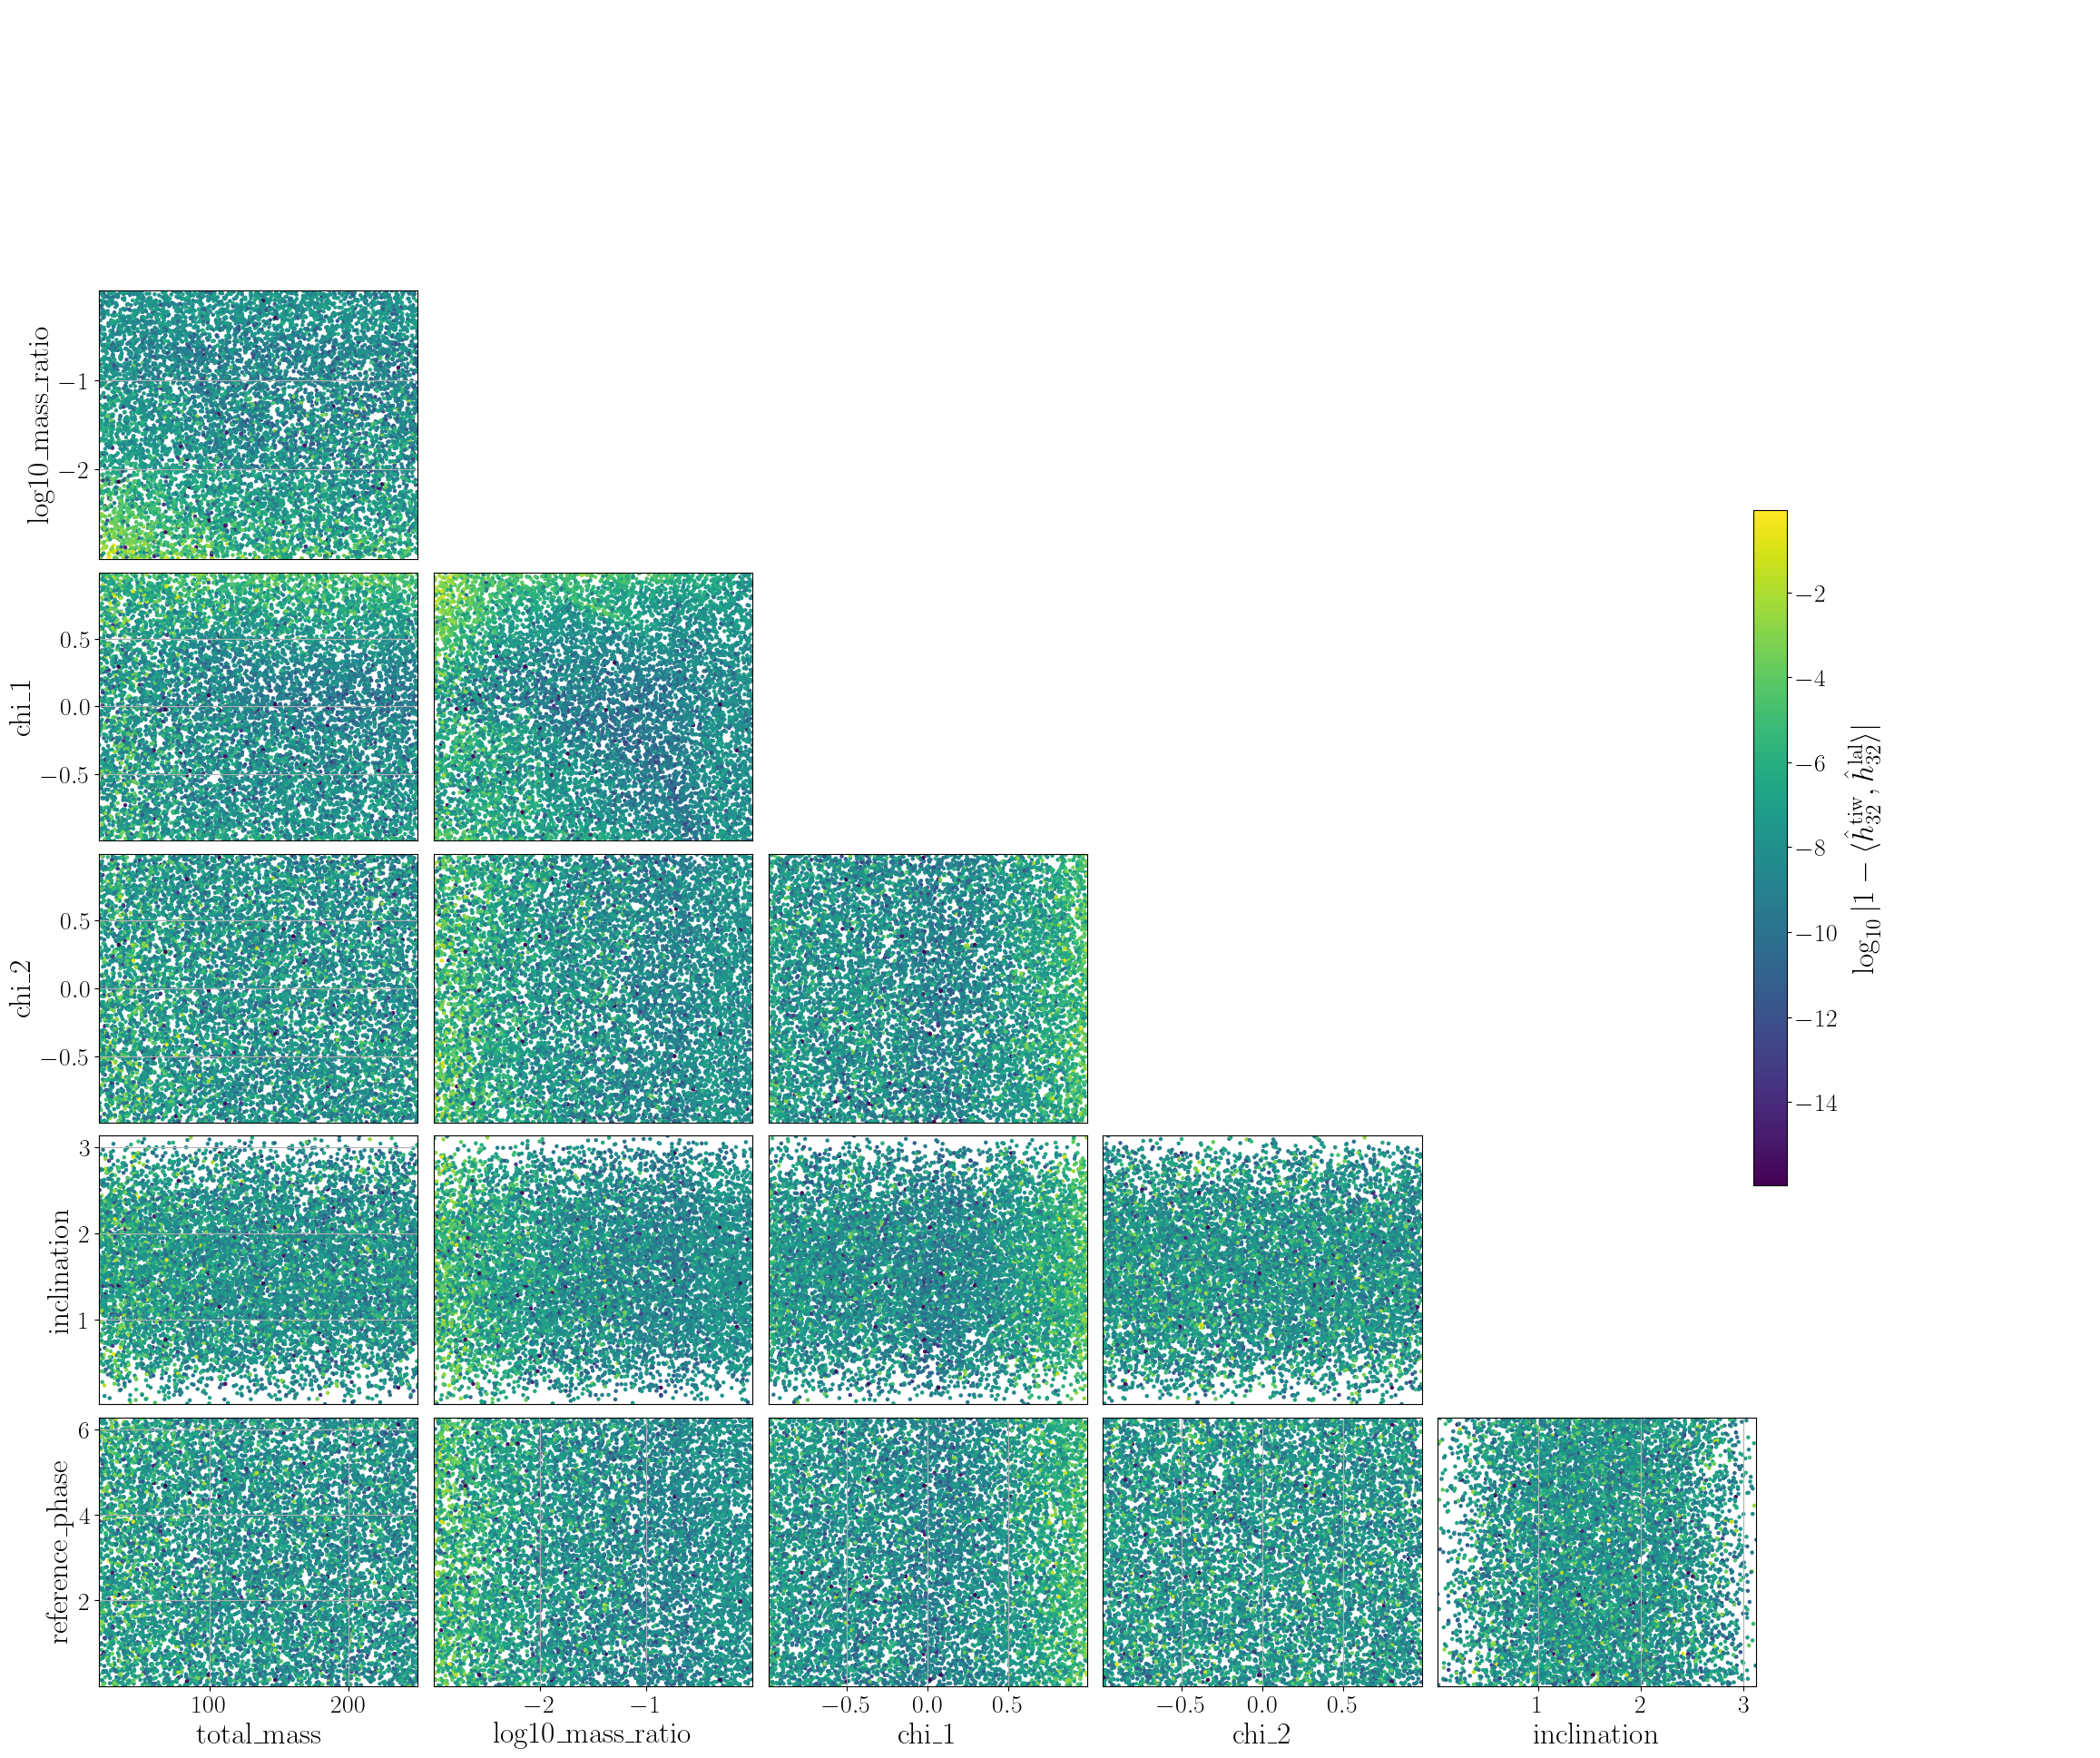

In [62]:
samples_x["log10_mass_ratio"] = np.log10(samples_x["mass_ratio"])

params_names = [
    "total_mass",
    "log10_mass_ratio",
    "chi_1",
    "chi_2",
    "inclination",
    "reference_phase",
]
num_params = 6

fig, axes = plt.subplots(num_params, num_params, figsize=(24, 24))
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for i in range(num_params):
    for j in range(num_params):
        ax = axes[i, j]
        ax.margins(0)

        if i <= j:
            ax.axis("off")
        else:
            scatter_handle = ax.scatter(
                samples_x[params_names[j]][mism_32_p > 0],
                samples_x[params_names[i]][mism_32_p > 0],
                s=5,
                c=np.log10(mism_32_p[mism_32_p > 0]),
            )

        if i == 5:
            ax.set_xlabel(params_names[j])
        else:
            ax.set_xticks([])

        if j == 0:
            ax.set_ylabel(params_names[i])
        else:
            ax.set_yticks([])

fig.colorbar(
    scatter_handle,
    ax=axes,
    orientation="vertical",
    fraction=0.02,
    pad=-0.2,
    label=r"$\log_{10}|1-\langle \hat{h}^{\rm tiw}_{32} , \hat{h}^{\rm lal}_{32}\rangle|$",
)

In [5]:
def mismatch_with_time_phase_shift(time_phase_shift, h1_norm, h2_norm):
    shift = 1j * (2 * np.pi * freqs * time_phase_shift[0] + time_phase_shift[1])
    h1_norm_shifted = h1_norm * np.exp(shift)
    return mismatch_core(h1_norm_shifted, h2_norm, psd_array, delta_f)


def minimized_mismatch(h1, h2):
    h1_norm = normalising(h1, psd_array, delta_f)
    h2_norm = normalising(h2, psd_array, delta_f)

    min_res = scipy.optimize.dual_annealing(
        mismatch_with_time_phase_shift,
        bounds=((-0.5, 0.5), (-np.pi, np.pi)),
        args=(h1_norm, h2_norm),
    )
    if min_res.success:
        return min_res.fun
    else:
        raise ValueError("minimizing func exited fail")

In [6]:
# Note the supported parameter space of NRHybSur3dq8 is different, generate new sample
num = 1000
samples_nrhyb = {}
samples_nrhyb["total_mass"] = rng.uniform(20, 250, num)
samples_nrhyb["mass_ratio"] = rng.uniform(0.125, 1.0, num)
samples_nrhyb["chi_1"] = rng.uniform(-0.8, 0.8, num)
samples_nrhyb["chi_2"] = rng.uniform(-0.8, 0.8, num)

samples_nrhyb = bilby.gw.conversion.generate_mass_parameters(samples_nrhyb)

luminosity_distance = 800.0
inclination = np.pi / 2  # For simplicity, only consider one polarization here
reference_phase = 1.2

In [7]:
# Roughly estimating the needed duration of time-domain waveform
# for high modes, we assume t_lm(f) = t_22(2/m f)
def frequency_at_time(tau, chirp_mass):
    # tau: time to coalescence, in seconds
    # chirp_mass: in unit of solar mass
    Mchirp_sec = chirp_mass * lal.MTSUN_SI
    return 1 / np.pi * (5 / 256 / tau) ** (3 / 8) * Mchirp_sec ** (-5 / 8)


def time_at_frequency(frequency, chirp_mass):
    # frequency: in Hz
    # chirp_mass: in solar mass
    Mchirp_sec = chirp_mass * lal.MTSUN_SI
    return 5 / 256 * Mchirp_sec ** (-5 / 3) * (np.pi * frequency) ** (-8 / 3)


# to make sure the tapering is ended before the signal evolving into the considered band,
# we use 5 Hz to intensional overestimate the time to coalescence.
taper_fraction = 0.1
fmin_redundancy = 5.0
duration_redundancy_factor = 2.0

In [8]:
appro_nrhyb = lalsim.GetApproximantFromString("NRHybSur3dq8")
extra_params = lal.CreateDict()
mode_array_lal = lalsim.SimInspiralCreateModeArray()
lalsim.SimInspiralModeArrayActivateMode(mode_array_lal, 3, 2)
lalsim.SimInspiralModeArrayActivateMode(mode_array_lal, 3, -2)
lalsim.SimInspiralWaveformParamsInsertModeArray(extra_params, mode_array_lal)

m = 2


def nrhyb_mode_32_wrapper(mass_1, mass_2, chi_1, chi_2):
    chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(mass_1, mass_2)
    time_at_fmin = time_at_frequency(fmin_redundancy * (2 / m), chirp_mass)
    taper_time = time_at_fmin * taper_fraction
    duration_safe = (
        np.maximum((time_at_fmin + taper_time), 32.0) * duration_redundancy_factor
    )
    fstart_safe = frequency_at_time(duration_safe, chirp_mass) * (2 / m)

    plus_nrhyb, _ = lalsim.SimInspiralChooseTDWaveform(
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(luminosity_distance * 1e6 * lal.PC_SI),
        float(inclination),
        float(reference_phase),
        float(long_asc_nodes),
        float(eccentricity),
        float(mean_per_ano),
        float(1.0 / sampling_rate),
        float(fstart_safe),
        float(reference_frequency),
        extra_params,
        appro_nrhyb,
    )

    full_length = plus_nrhyb.data.length
    t0 = float(plus_nrhyb.epoch)

    taper_width = int(np.floor(taper_time * sampling_rate))
    one_width = full_length - taper_width
    window = np.hanning(int(taper_width * 2))
    window = np.append(window[0:taper_width], np.ones(one_width))
    plus_nrhyb_tapered = plus_nrhyb.data.data * window

    plus_nrhyb_fd = np.fft.rfft(plus_nrhyb_tapered)
    freq_fft = np.fft.rfftfreq(full_length, 1.0 / sampling_rate)
    plus_nrhyb_fd = plus_nrhyb_fd * np.exp(-1j * 2 * np.pi * freq_fft * t0)

    plus_nrhyb_fd_interp = np.interp(freqs, freq_fft, plus_nrhyb_fd)
    plus_nrhyb_fd_interp *= 1.0 / sampling_rate

    return plus_nrhyb_fd_interp


wf_mode_32_nrhyb = list(
    map(
        nrhyb_mode_32_wrapper,
        samples_nrhyb["mass_1"],
        samples_nrhyb["mass_2"],
        samples_nrhyb["chi_1"],
        samples_nrhyb["chi_2"],
    )
)

In [9]:
xhm_mode_32_tiw = IMRPhenomXHM(freqs_ti, reference_frequency, high_modes=("32",))


def xhm_mode_32_tiw_wrapper(mass_1, mass_2, chi_1, chi_2):
    params_in = {
        "mass_1": mass_1,
        "mass_2": mass_2,
        "chi_1": chi_1,
        "chi_2": chi_2,
        "luminosity_distance": luminosity_distance,
        "inclination": inclination,
        "reference_phase": reference_frequency,
    }
    xhm_mode_32_tiw.update_waveform(params_in)
    return xhm_mode_32_tiw.waveform_container_numpy["32"]["plus"]


wf_mode_32_xhm_tiw = list(
    map(
        xhm_mode_32_tiw_wrapper,
        samples_nrhyb["mass_1"],
        samples_nrhyb["mass_2"],
        samples_nrhyb["chi_1"],
        samples_nrhyb["chi_2"],
    )
)

/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/base_waveform.py:45: UserWarning: check_parameters is disable, make sure all parameters passed in are valid.
  warnings.warn(
/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/IMRPhenomXHM.py:7036: UserWarning: Mode 32 has relatively large numerical errors with lalsim, especially for high spin and extreme mass ratio. See examples/checking_waveforms.ipynb for more details. Please make sure these errors are acceptable in your cases before using.
  warnings.warn(
/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/IMRPhenomXHM.py:7043: UserWarning: `tf` is required for mode 32, since the derivative of phase for merge-ringdown of mode 32 is obtained through numerical difference, if may not reliable for some cases.
  warnings.warn(


In [10]:
appro_xhm = lalsim.GetApproximantFromString("IMRPhenomXHM")

extra_params = lal.CreateDict()
mode_array_lal = lalsim.SimInspiralCreateModeArray()
lalsim.SimInspiralModeArrayActivateMode(mode_array_lal, 3, 2)
lalsim.SimInspiralModeArrayActivateMode(mode_array_lal, 3, -2)
lalsim.SimInspiralWaveformParamsInsertModeArray(extra_params, mode_array_lal)
# turn-off multibanding
lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(extra_params, 0)


def xhm_mode_32_lal_wrapper(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
):
    # extra_params is created externally, ensure extra_params is set correctly
    hp, _ = lalsim.SimInspiralChooseFDWaveform(
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(luminosity_distance * 1e6 * lal.PC_SI),
        float(inclination),
        float(reference_phase),
        float(long_asc_nodes),
        float(eccentricity),
        float(mean_per_ano),
        float(delta_f),
        float(freqs[0]),
        float(freqs[-1]),
        float(reference_frequency),
        extra_params,
        appro_xhm,
    )

    return hp.data.data[freqs_mask]


wf_mode_32_xhm_lal = list(
    map(
        xhm_mode_32_lal_wrapper,
        samples_nrhyb["mass_1"],
        samples_nrhyb["mass_2"],
        samples_nrhyb["chi_1"],
        samples_nrhyb["chi_2"],
    )
)

In [11]:
appro_hm = lalsim.GetApproximantFromString("IMRPhenomHM")

extra_params = lal.CreateDict()
mode_array_lal = lalsim.SimInspiralCreateModeArray()
lalsim.SimInspiralModeArrayActivateMode(mode_array_lal, 3, 2)
# lalsim.SimInspiralModeArrayActivateMode(mode_array_lal, 3, -2)
lalsim.SimInspiralWaveformParamsInsertModeArray(extra_params, mode_array_lal)


def hm_mode_32_lal_wrapper(
    mass_1,
    mass_2,
    chi_1,
    chi_2,
):
    # extra_params is created externally, ensure extra_params is set correctly
    hp, _ = lalsim.SimInspiralChooseFDWaveform(
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(luminosity_distance * 1e6 * lal.PC_SI),
        float(inclination),
        float(reference_phase),
        float(long_asc_nodes),
        float(eccentricity),
        float(mean_per_ano),
        float(delta_f),
        float(freqs[0]),
        float(freqs[-1]),
        float(reference_frequency),
        extra_params,
        appro_hm,
    )

    return hp.data.data[freqs_mask]


wf_mode_32_hm_lal = list(
    map(
        hm_mode_32_lal_wrapper,
        samples_nrhyb["mass_1"],
        samples_nrhyb["mass_2"],
        samples_nrhyb["chi_1"],
        samples_nrhyb["chi_2"],
    )
)

In [12]:
wf_mode_32_xhm_tiw_nrhyb_zip = np.stack([wf_mode_32_xhm_tiw, wf_mode_32_nrhyb], axis=1)
wf_mode_32_xhm_lal_nrhyb_zip = np.stack([wf_mode_32_xhm_lal, wf_mode_32_nrhyb], axis=1)
wf_mode_32_hm_lal_nrhyb_zip = np.stack([wf_mode_32_hm_lal, wf_mode_32_nrhyb], axis=1)
print(wf_mode_32_xhm_tiw_nrhyb_zip.shape)
print(wf_mode_32_xhm_lal_nrhyb_zip.shape)
print(wf_mode_32_hm_lal_nrhyb_zip.shape)

(1000, 2, 64897)
(1000, 2, 64897)
(1000, 2, 64897)


In [13]:
nproc = 72

with Pool(processes=nproc) as pool:
    mism_mode_32_xhm_tiw_nrhyb = list(
        pool.starmap(minimized_mismatch, wf_mode_32_xhm_tiw_nrhyb_zip)
    )
    mism_mode_32_xhm_lal_nrhyb = list(
        pool.starmap(minimized_mismatch, wf_mode_32_xhm_lal_nrhyb_zip)
    )
    mism_mode_32_hm_lal_nrhyb = list(
        pool.starmap(minimized_mismatch, wf_mode_32_hm_lal_nrhyb_zip)
    )

mism_mode_32_xhm_tiw = np.array(mism_mode_32_xhm_tiw_nrhyb)
mism_mode_32_xhm_lal = np.array(mism_mode_32_xhm_lal_nrhyb)
mism_mode_32_hm_lal = np.array(mism_mode_32_hm_lal_nrhyb)

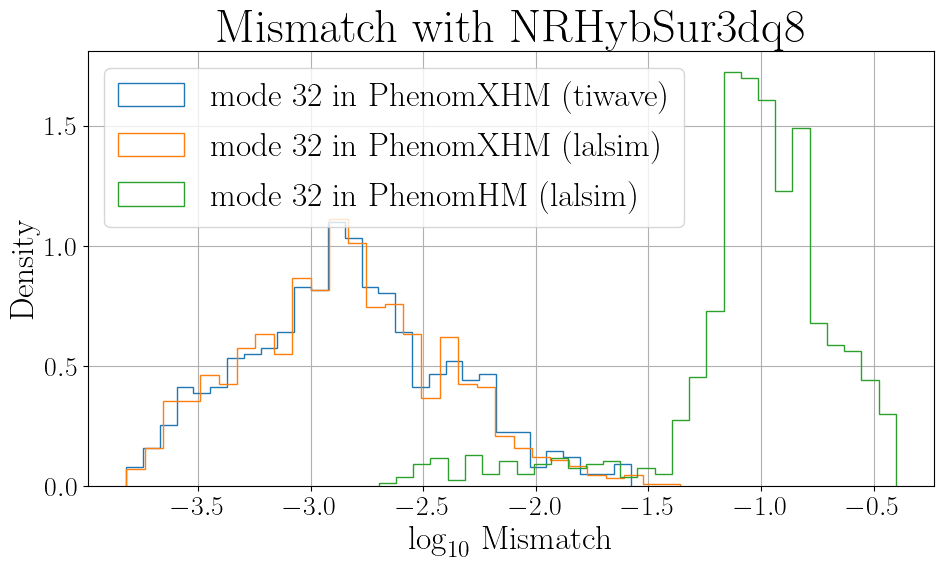

In [17]:
fig, ax = plt.subplots()
ax.set_title("Mismatch with NRHybSur3dq8")
ax.hist(
    np.log10(mism_mode_32_xhm_tiw),
    density=True,
    bins=30,
    histtype="step",
    label="mode 32 in PhenomXHM (tiwave)",
)
ax.hist(
    np.log10(mism_mode_32_xhm_lal),
    density=True,
    bins=30,
    histtype="step",
    label="mode 32 in PhenomXHM (lalsim)",
)
ax.hist(
    np.log10(mism_mode_32_hm_lal),
    density=True,
    bins=30,
    histtype="step",
    label="mode 32 in PhenomHM (lalsim)",
)
ax.set_xlabel(r"$\log_{10}\, \rm Mismatch$")
ax.set_ylabel("Density")
ax.legend()
fig.tight_layout()

**Explanation for the mismatch**

- The minus mismatch values are induced by numerical errors in the computation of the inner product, and maximum minus value can roughly represent the limit of the numerical precision;

- For the mode 33 and 44, we can observe the maximum mismatch is roughly twice the limit of numerical precision. Mismatch of these two modes is mainly from the intermediate amplitude where we use the analytic form of the derivative of inspiral amplitude to set the collocation value at the boundary, while the numerical derivative are used in lalsim. This can induce the difference of O(1e-5) in the ansatz coefficients, and a little bit high mismatch of the built waveforms;

- The mode 32 has relatively high difference with lalsim. The main reason is that the 2-ed derivative is used in the construction of intermediate phase. We have quite high numerical errors in computing this value. In lalsim float128 is used to reduce the loss of significance when computing substraction of two nearby numbers. But in taichi-lang float128 is not supported currently. We will address this issue in the future. However, by comparing with NRHybSur3dq8, We can find the mismatch of mode 32 in tiwave is similar to lalsim. Therefore, we think at least in the shared parameter space of NRHybSur3dq8 where q < 8, |chi_i| < 0.8, the tiwave can be safely used.

## IMRPhenomXPHM

### 1. Comparing values of coefficients in the waveform ansatz (TL; DR)

### 2. Comparing the waveform visually

### 3. Mismatch in the whole parameter space